In [67]:
import pandas as pd
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import seaborn as sns



In [198]:

def appliquer_transformation_fourier(fichier_entree, fichier_sortie, echantillonnage):
    # Charger le fichier CSV
    data_df = pd.read_csv(fichier_entree)
    
    # Extraire la première colonne (temps)
    temps = data_df.iloc[:, 0].to_numpy()
    
    # Supprimer la première colonne (temps) car elle ne fait pas partie des données de mesure
    data_df = data_df.drop(columns=data_df.columns[0])
    
    # Calculer les fréquences correspondantes
    n = len(temps)
    freqs = fftfreq(n, d=echantillonnage)
    
    # Appliquer la transformation de Fourier
    fft_df = pd.DataFrame()
    for col in data_df.columns:
        # Soustraire la moyenne pour enlever la composante continue
        signal = data_df[col].to_numpy()
        signal_centre = signal - np.mean(signal)
        
        # Calculer la FFT et les amplitudes correspondantes
        fft_col = np.abs(fft(signal_centre))
        fft_df[col] = fft_col
    
    # Ajouter la colonne des fréquences au DataFrame
    fft_df.insert(0, 'Frequence', freqs)
    
    # Sauvegarder les résultats dans un nouveau fichier CSV
    fft_df.to_csv(fichier_sortie, index=False)
    print(f"Transformation de Fourier appliquée et résultats sauvegardés dans {fichier_sortie}")
    
    return fft_df


def appliquer_transformation_fourier_positives(fichier_entree, fichier_sortie, echantillonnage):
    # Charger le fichier CSV
    data_df = pd.read_csv(fichier_entree)
    
    # Extraire la première colonne (temps)
    temps = data_df.iloc[:, 0].to_numpy()
    
    # Supprimer la première colonne (temps) car elle ne fait pas partie des données de mesure
    data_df = data_df.drop(columns=data_df.columns[0])
    
    # Calculer les fréquences correspondantes
    n = len(temps)
    freqs = fftfreq(n, d=echantillonnage)
    
    # Garder uniquement les fréquences positives
    mask = freqs >= 0
    freqs = freqs[mask]
    
    # Appliquer la transformation de Fourier et garder uniquement les fréquences positives
    fft_df = pd.DataFrame()
    for col in data_df.columns:
        # Soustraire la moyenne pour enlever la composante continue
        signal = data_df[col].to_numpy()
        signal_centre = signal - np.mean(signal)
        
        fft_col = np.abs(fft(signal_centre))[mask]
        fft_df[col] = fft_col
    
    # Ajouter la colonne des fréquences au DataFrame
    fft_df.insert(0, 'Frequence', freqs)
    
    # Sauvegarder les résultats dans un nouveau fichier CSV
    fft_df.to_csv(fichier_sortie, index=False)
    print(f"Transformation de Fourier appliquée et résultats sauvegardés dans {fichier_sortie}")
    
    return fft_df


In [201]:
def visualiser_matrice_fft_par_point(fft_df):
    # Vérifier que le DataFrame n'est pas None
    if fft_df is None:
        print("Erreur : Le DataFrame fft_df est None.")
        return
    
    try:
        # Visualisation de chaque point de mesure
        freqs = fft_df['Frequence']
        for col in fft_df.columns[1:]:
            plt.figure(figsize=(12, 8))
            plt.plot(freqs, fft_df[col])
            plt.title(f'Amplitude des fréquences pour {col}')
            plt.xlabel('Fréquence (Hz)')
            plt.ylabel('Amplitude')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Erreur lors de la visualisation de la matrice FFT : {e}")

In [203]:
def detecter_top_frequences(fft_df, top_n=5):
    top_freqs_df = pd.DataFrame()
    
    for col in fft_df.columns[1:]:
        # Trier les amplitudes en ordre décroissant et prendre les indices correspondants
        sorted_indices = np.argsort(fft_df[col])[::-1]
        
        # Prendre les top_n fréquences dominantes
        top_frequencies = fft_df['Frequence'].iloc[sorted_indices].head(top_n).to_numpy()
        top_amplitudes = fft_df[col].iloc[sorted_indices].head(top_n).to_numpy()
        
        # Ajouter les fréquences et amplitudes dominantes au DataFrame
        top_freqs_df[f"{col}_Top_{top_n}_Freqs"] = top_frequencies
        top_freqs_df[f"{col}_Top_{top_n}_Amplitudes"] = top_amplitudes
    
    return top_freqs_df



In [205]:
def tracer_top_frequences(top_frequencies_df, top_n=5):
    num_points = top_frequencies_df.shape[1] // 2
    num_cols = 3
    num_rows = (num_points + num_cols - 1) // num_cols  # Pour arrondir vers le haut
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()
    
    for i in range(0, top_frequencies_df.shape[1], 2):
        point = i // 2 + 1
        freqs = top_frequencies_df.iloc[:, i]
        amplitudes = top_frequencies_df.iloc[:, i + 1]
        
        ax = axes[point - 1]
        ax.scatter(freqs, amplitudes, label=f'Point {point}', s=100)
        ax.set_title(f'Point {point}')
        ax.set_xlabel('Fréquence (Hz)')
        ax.set_ylabel('Amplitude')
        ax.grid(True)
    
    # Supprimer les axes non utilisés
    for j in range(point, len(axes)):
        fig.delaxes(axes[j])
    
    fig.tight_layout()
    plt.show()


In [207]:
from scipy.signal import find_peaks

def identifier_composantes_periodiques(fft_vals, seuil=0.1):
    # Utiliser find_peaks pour identifier les pics dans le spectre de fréquence
    amplitude_max = np.max(fft_vals)
    peaks, _ = find_peaks(fft_vals, height=seuil * amplitude_max)
    return peaks

In [209]:
# Exemple d'utilisation de la fonction
fichier_entree = r"C:\Users\kamar\OneDrive\Bureau\stage\Experimentation\Experimentation\1er essai- petit bac et petit tuyau en bas\2A1L-ty en bas-fichier brut matrix.csv"
fichier_sortie = r"C:\Users\kamar\OneDrive\Bureau\stage\Experimentation\Experimentation\1er essai- petit bac et petit tuyau en bas\2A1L-ty en bas-fichier brut fft matrix.csv"

echantillonnage = 0.000610  # Remplacez par le pas de temps entre chaque mesure, ici pris de la première ligne du fichier fourni

appliquer_transformation_fourier(fichier_entree, fichier_sortie, echantillonnage)

Transformation de Fourier appliquée et résultats sauvegardés dans C:\Users\kamar\OneDrive\Bureau\stage\Experimentation\Experimentation\1er essai- petit bac et petit tuyau en bas\2A1L-ty en bas-fichier brut fft matrix.csv


Frequence       Point 1       Point 2       Point 3       Point 4  \
0      0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1      0.200115  1.383877e+06  1.339443e+06  1.314849e+06  1.318406e+06   
2      0.400231  1.115388e+06  1.110367e+06  1.069308e+06  1.062142e+06   
3      0.600346  9.858375e+05  1.023837e+06  1.062861e+06  1.051467e+06   
4      0.800461  1.115763e+06  1.040935e+06  1.010720e+06  1.005214e+06   
...         ...           ...           ...           ...           ...   
8187  -1.000576  1.295969e+06  1.176346e+06  1.062784e+06  9.962035e+05   
8188  -0.800461  1.115763e+06  1.040935e+06  1.010720e+06  1.005214e+06   
8189  -0.600346  9.858375e+05  1.023837e+06  1.062861e+06  1.051467e+06   
8190  -0.400231  1.115388e+06  1.110367e+06  1.069308e+06  1.062142e+06   
8191  -0.200115  1.383877e+06  1.339443e+06  1.314849e+06  1.318406e+06   

           Point 5       Point 6       Point 7       Point 8       Point 9  \
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     1.320981e+06  1.333330e+06  1.339515e+06  1.321374e+06  1.320282e+06   
2     1.087897e+06  1.123664e+06  1.128221e+06  1.070629e+06  1.043536e+06   
3     1.017890e+06  9.783208e+05  9.303829e+05  9.038892e+05  9.077278e+05   
4     1.000137e+06  1.026584e+06  1.071364e+06  1.136657e+06  1.187971e+06   
...            ...           ...           ...           ...           ...   
8187  9.745247e+05  1.010025e+06  1.044696e+06  1.047300e+06  1.028741e+06   
8188  1.000137e+06  1.026584e+06  1.071364e+06  1.136657e+06  1.187971e+06   
8189  1.017890e+06  9.783208e+05  9.303829e+05  9.038892e+05  9.077278e+05   
8190  1.087897e+06  1.123664e+06  1.128221e+06  1.070629e+06  1.043536e+06   
8191  1.320981e+06  1.333330e+06  1.339515e+06  1.321374e+06  1.320282e+06   

      ...      Point 25      Point 26      Point 27      Point 28  \
0     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     ...  1.333088e+06  1.323049e+06  1.325197e+06  1.309733e+06   
2     ...  9.873397e+05  9.860365e+05  9.795288e+05  9.639814e+05   
3     ...  8.971775e+05  9.218242e+05  9.790897e+05  1.034487e+06   
4     ...  1.190175e+06  1.165403e+06  1.163317e+06  1.148216e+06   
...   ...           ...           ...           ...           ...   
8187  ...  1.079810e+06  1.020053e+06  9.567354e+05  8.792186e+05   
8188  ...  1.190175e+06  1.165403e+06  1.163317e+06  1.148216e+06   
8189  ...  8.971775e+05  9.218242e+05  9.790897e+05  1.034487e+06   
8190  ...  9.873397e+05  9.860365e+05  9.795288e+05  9.639814e+05   
8191  ...  1.333088e+06  1.323049e+06  1.325197e+06  1.309733e+06   

          Point 29      Point 30      Point 31      Point 32      Point 33  \
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     1.312366e+06  1.312682e+06  1.317735e+06  1.316412e+06  1.304432e+06   
2     1.008727e+06  1.062024e+06  1.065493e+06  1.055435e+06  1.032549e+06   
3     1.033224e+06  1.000903e+06  9.727074e+05  9.641640e+05  9.571832e+05   
4     1.166995e+06  1.180910e+06  1.233718e+06  1.275246e+06  1.314611e+06   
...            ...           ...           ...           ...           ...   
8187  8.803304e+05  9.388695e+05  1.025673e+06  1.086847e+06  1.155106e+06   
8188  1.166995e+06  1.180910e+06  1.233718e+06  1.275246e+06  1.314611e+06   
8189  1.033224e+06  1.000903e+06  9.727074e+05  9.641640e+05  9.571832e+05   
8190  1.008727e+06  1.062024e+06  1.065493e+06  1.055435e+06  1.032549e+06   
8191  1.312366e+06  1.312682e+06  1.317735e+06  1.316412e+06  1.304432e+06   

          Point 34  
0     0.000000e+00  
1     1.254592e+06  
2     9.714330e+05  
3     9.520362e+05  
4     1.326168e+06  
...            ...  
8187  1.157364e+06  
8188  1.326168e+06  
8189  9.520362e+05  
8190  9.714330e+05  
8191  1.254592e+06  

[8192 rows x 35 columns]

In [211]:
dftemp=pd.read_csv(fichier_entree)
dftemp

Unnamed: 0  Point 1  Point 2  Point 3  Point 4  Point 5  Point 6  \
0       0.000000   1573.0   1576.0   1573.0   1572.0   1580.0   1587.0   
1       0.000610    713.0    705.0    708.0    716.0    721.0    720.0   
2       0.001221    905.0    900.0    899.0    911.0    912.0    915.0   
3       0.001831    994.0    991.0    989.0    999.0   1001.0   1006.0   
4       0.002441   1033.0   1028.0   1027.0   1037.0   1041.0   1042.0   
...          ...      ...      ...      ...      ...      ...      ...   
8187    4.996948    795.0    912.0    877.0    848.0    960.0   1084.0   
8188    4.997559    794.0    909.0    874.0    839.0    948.0   1060.0   
8189    4.998169    795.0    905.0    877.0    852.0    939.0   1048.0   
8190    4.998779    794.0    910.0    874.0    858.0    915.0   1075.0   
8191    4.999390    794.0    910.0    874.0    858.0    915.0   1075.0   

      Point 7  Point 8  Point 9  ...  Point 25  Point 26  Point 27  Point 28  \
0      1582.0   1579.0   1572.0  ...    1566.0    1573.0    1579.0    1565.0   
1       717.0    695.0    689.0  ...     657.0     661.0     673.0     678.0   
2       910.0    892.0    885.0  ...     851.0     857.0     866.0     874.0   
3       998.0    980.0    972.0  ...     946.0     950.0     954.0     963.0   
4      1036.0   1020.0   1006.0  ...     979.0     986.0     996.0    1002.0   
...       ...      ...      ...  ...       ...       ...       ...       ...   
8187   1121.0   1087.0    992.0  ...    1054.0    1144.0    1152.0    1088.0   
8188   1124.0   1091.0    993.0  ...    1052.0    1149.0    1153.0    1119.0   
8189   1148.0   1090.0    996.0  ...    1070.0    1147.0    1156.0    1088.0   
8190   1126.0   1084.0    991.0  ...    1063.0    1148.0    1153.0    1074.0   
8191   1126.0   1084.0    991.0  ...    1063.0    1148.0    1153.0    1074.0   

      Point 29  Point 30  Point 31  Point 32  Point 33  Point 34  
0       1579.0    1585.0    1570.0    1581.0    1585.0    1586.0  
1        683.0     694.0     699.0     697.0     693.0     698.0  
2        881.0     891.0     894.0     888.0     893.0     895.0  
3        970.0     981.0     985.0     980.0     980.0     981.0  
4       1008.0    1017.0    1022.0    1017.0    1019.0    1022.0  
...        ...       ...       ...       ...       ...       ...  
8187    1082.0    1116.0    1159.0    1177.0    1230.0    1246.0  
8188    1034.0    1092.0    1182.0    1187.0    1245.0    1251.0  
8189    1043.0    1096.0    1171.0    1176.0    1261.0    1284.0  
8190    1057.0    1095.0    1134.0    1173.0    1260.0    1284.0  
8191    1057.0    1095.0    1134.0    1173.0    1260.0    1284.0  

[8192 rows x 35 columns]

In [213]:
df=pd.read_csv(fichier_sortie)
df

Frequence       Point 1       Point 2       Point 3       Point 4  \
0      0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1      0.200115  1.383877e+06  1.339443e+06  1.314849e+06  1.318406e+06   
2      0.400231  1.115388e+06  1.110367e+06  1.069308e+06  1.062142e+06   
3      0.600346  9.858375e+05  1.023837e+06  1.062861e+06  1.051467e+06   
4      0.800461  1.115763e+06  1.040935e+06  1.010720e+06  1.005214e+06   
...         ...           ...           ...           ...           ...   
8187  -1.000576  1.295969e+06  1.176346e+06  1.062784e+06  9.962035e+05   
8188  -0.800461  1.115763e+06  1.040935e+06  1.010720e+06  1.005214e+06   
8189  -0.600346  9.858375e+05  1.023837e+06  1.062861e+06  1.051467e+06   
8190  -0.400231  1.115388e+06  1.110367e+06  1.069308e+06  1.062142e+06   
8191  -0.200115  1.383877e+06  1.339443e+06  1.314849e+06  1.318406e+06   

           Point 5       Point 6       Point 7       Point 8       Point 9  \
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     1.320981e+06  1.333330e+06  1.339515e+06  1.321374e+06  1.320282e+06   
2     1.087897e+06  1.123664e+06  1.128221e+06  1.070629e+06  1.043536e+06   
3     1.017890e+06  9.783208e+05  9.303829e+05  9.038892e+05  9.077278e+05   
4     1.000137e+06  1.026584e+06  1.071364e+06  1.136657e+06  1.187971e+06   
...            ...           ...           ...           ...           ...   
8187  9.745247e+05  1.010025e+06  1.044696e+06  1.047300e+06  1.028741e+06   
8188  1.000137e+06  1.026584e+06  1.071364e+06  1.136657e+06  1.187971e+06   
8189  1.017890e+06  9.783208e+05  9.303829e+05  9.038892e+05  9.077278e+05   
8190  1.087897e+06  1.123664e+06  1.128221e+06  1.070629e+06  1.043536e+06   
8191  1.320981e+06  1.333330e+06  1.339515e+06  1.321374e+06  1.320282e+06   

      ...      Point 25      Point 26      Point 27      Point 28  \
0     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     ...  1.333088e+06  1.323049e+06  1.325197e+06  1.309733e+06   
2     ...  9.873397e+05  9.860365e+05  9.795288e+05  9.639814e+05   
3     ...  8.971775e+05  9.218242e+05  9.790897e+05  1.034487e+06   
4     ...  1.190175e+06  1.165403e+06  1.163317e+06  1.148216e+06   
...   ...           ...           ...           ...           ...   
8187  ...  1.079810e+06  1.020053e+06  9.567354e+05  8.792186e+05   
8188  ...  1.190175e+06  1.165403e+06  1.163317e+06  1.148216e+06   
8189  ...  8.971775e+05  9.218242e+05  9.790897e+05  1.034487e+06   
8190  ...  9.873397e+05  9.860365e+05  9.795288e+05  9.639814e+05   
8191  ...  1.333088e+06  1.323049e+06  1.325197e+06  1.309733e+06   

          Point 29      Point 30      Point 31      Point 32      Point 33  \
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     1.312366e+06  1.312682e+06  1.317735e+06  1.316412e+06  1.304432e+06   
2     1.008727e+06  1.062024e+06  1.065493e+06  1.055435e+06  1.032549e+06   
3     1.033224e+06  1.000903e+06  9.727074e+05  9.641640e+05  9.571832e+05   
4     1.166995e+06  1.180910e+06  1.233718e+06  1.275246e+06  1.314611e+06   
...            ...           ...           ...           ...           ...   
8187  8.803304e+05  9.388695e+05  1.025673e+06  1.086847e+06  1.155106e+06   
8188  1.166995e+06  1.180910e+06  1.233718e+06  1.275246e+06  1.314611e+06   
8189  1.033224e+06  1.000903e+06  9.727074e+05  9.641640e+05  9.571832e+05   
8190  1.008727e+06  1.062024e+06  1.065493e+06  1.055435e+06  1.032549e+06   
8191  1.312366e+06  1.312682e+06  1.317735e+06  1.316412e+06  1.304432e+06   

          Point 34  
0     0.000000e+00  
1     1.254592e+06  
2     9.714330e+05  
3     9.520362e+05  
4     1.326168e+06  
...            ...  
8187  1.157364e+06  
8188  1.326168e+06  
8189  9.520362e+05  
8190  9.714330e+05  
8191  1.254592e+06  

[8192 rows x 35 columns]

In [215]:
fft_df = appliquer_transformation_fourier_positives(fichier_entree, fichier_sortie, echantillonnage)


Transformation de Fourier appliquée et résultats sauvegardés dans C:\Users\kamar\OneDrive\Bureau\stage\Experimentation\Experimentation\1er essai- petit bac et petit tuyau en bas\2A1L-ty en bas-fichier brut fft matrix.csv


In [217]:
fft_df

Frequence       Point 1       Point 2       Point 3       Point 4  \
0       0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1       0.200115  1.383877e+06  1.339443e+06  1.314849e+06  1.318406e+06   
2       0.400231  1.115388e+06  1.110367e+06  1.069308e+06  1.062142e+06   
3       0.600346  9.858375e+05  1.023837e+06  1.062861e+06  1.051467e+06   
4       0.800461  1.115763e+06  1.040935e+06  1.010720e+06  1.005214e+06   
...          ...           ...           ...           ...           ...   
4091  818.671555  2.601627e+03  3.406567e+03  1.225150e+03  3.700039e+03   
4092  818.871670  3.170172e+02  1.777690e+03  4.731725e+03  1.741599e+03   
4093  819.071785  8.550201e+02  4.617967e+02  2.809620e+03  3.694979e+03   
4094  819.271901  5.366952e+02  1.725308e+03  9.790821e+02  1.789312e+03   
4095  819.472016  2.481356e+03  3.387799e+03  2.711681e+03  2.940730e+03   

           Point 5       Point 6       Point 7       Point 8       Point 9  \
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     1.320981e+06  1.333330e+06  1.339515e+06  1.321374e+06  1.320282e+06   
2     1.087897e+06  1.123664e+06  1.128221e+06  1.070629e+06  1.043536e+06   
3     1.017890e+06  9.783208e+05  9.303829e+05  9.038892e+05  9.077278e+05   
4     1.000137e+06  1.026584e+06  1.071364e+06  1.136657e+06  1.187971e+06   
...            ...           ...           ...           ...           ...   
4091  1.819682e+03  7.285751e+02  2.906877e+03  2.753167e+03  1.211346e+03   
4092  2.784185e+03  1.281035e+03  1.699879e+03  2.661972e+03  1.019041e+03   
4093  3.029426e+03  6.586202e+02  4.033893e+03  5.291024e+03  3.370133e+03   
4094  3.142809e+03  1.231927e+03  3.620870e+03  7.283337e+03  2.374171e+03   
4095  8.151963e+02  7.967764e+02  5.270390e+03  6.362607e+03  3.283675e+03   

      ...      Point 25      Point 26      Point 27      Point 28  \
0     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     ...  1.333088e+06  1.323049e+06  1.325197e+06  1.309733e+06   
2     ...  9.873397e+05  9.860365e+05  9.795288e+05  9.639814e+05   
3     ...  8.971775e+05  9.218242e+05  9.790897e+05  1.034487e+06   
4     ...  1.190175e+06  1.165403e+06  1.163317e+06  1.148216e+06   
...   ...           ...           ...           ...           ...   
4091  ...  1.607488e+03  2.611583e+03  4.274939e+02  1.692089e+03   
4092  ...  5.271068e+02  1.676993e+03  4.376203e+03  3.043889e+03   
4093  ...  1.250568e+03  3.624886e+03  3.714685e+03  5.930894e+03   
4094  ...  3.861439e+03  4.053735e+03  4.213929e+03  3.828207e+03   
4095  ...  1.669607e+02  4.159782e+03  3.319663e+03  2.086862e+03   

          Point 29      Point 30      Point 31      Point 32      Point 33  \
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     1.312366e+06  1.312682e+06  1.317735e+06  1.316412e+06  1.304432e+06   
2     1.008727e+06  1.062024e+06  1.065493e+06  1.055435e+06  1.032549e+06   
3     1.033224e+06  1.000903e+06  9.727074e+05  9.641640e+05  9.571832e+05   
4     1.166995e+06  1.180910e+06  1.233718e+06  1.275246e+06  1.314611e+06   
...            ...           ...           ...           ...           ...   
4091  4.540315e+03  4.152422e+03  4.663071e+02  3.418136e+03  5.592907e+03   
4092  1.273586e+03  2.727367e+03  6.364548e+03  3.518571e+03  1.990735e+03   
4093  2.607754e+03  2.063982e+03  7.583549e+03  4.509162e+03  4.246123e+03   
4094  2.783885e+03  2.687483e+03  4.620807e+03  7.431706e+03  5.678665e+03   
4095  1.450200e+03  2.897621e+03  5.538402e+03  3.839611e+03  5.049357e+03   

          Point 34  
0     0.000000e+00  
1     1.254592e+06  
2     9.714330e+05  
3     9.520362e+05  
4     1.326168e+06  
...            ...  
4091  2.652374e+03  
4092  3.757899e+03  
4093  5.373930e+03  
4094  4.312441e+03  
4095  5.833085e+03  

[4096 rows x 35 columns]

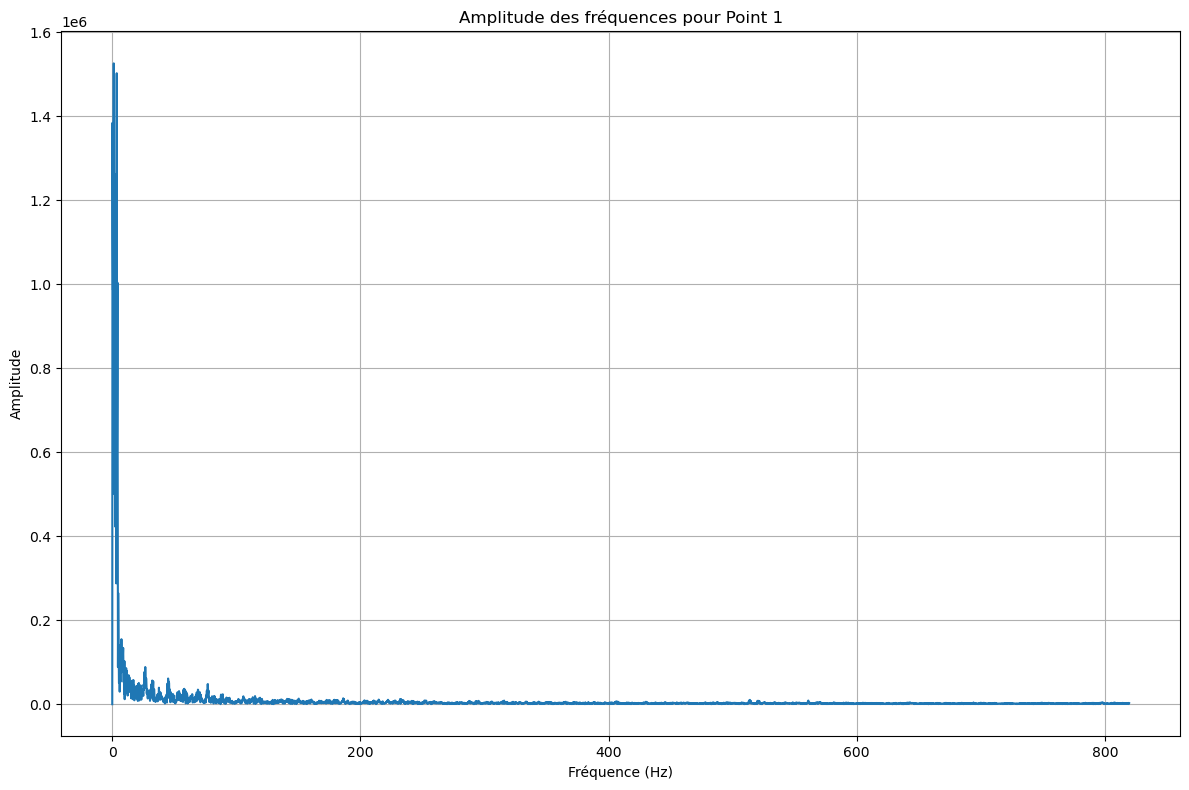

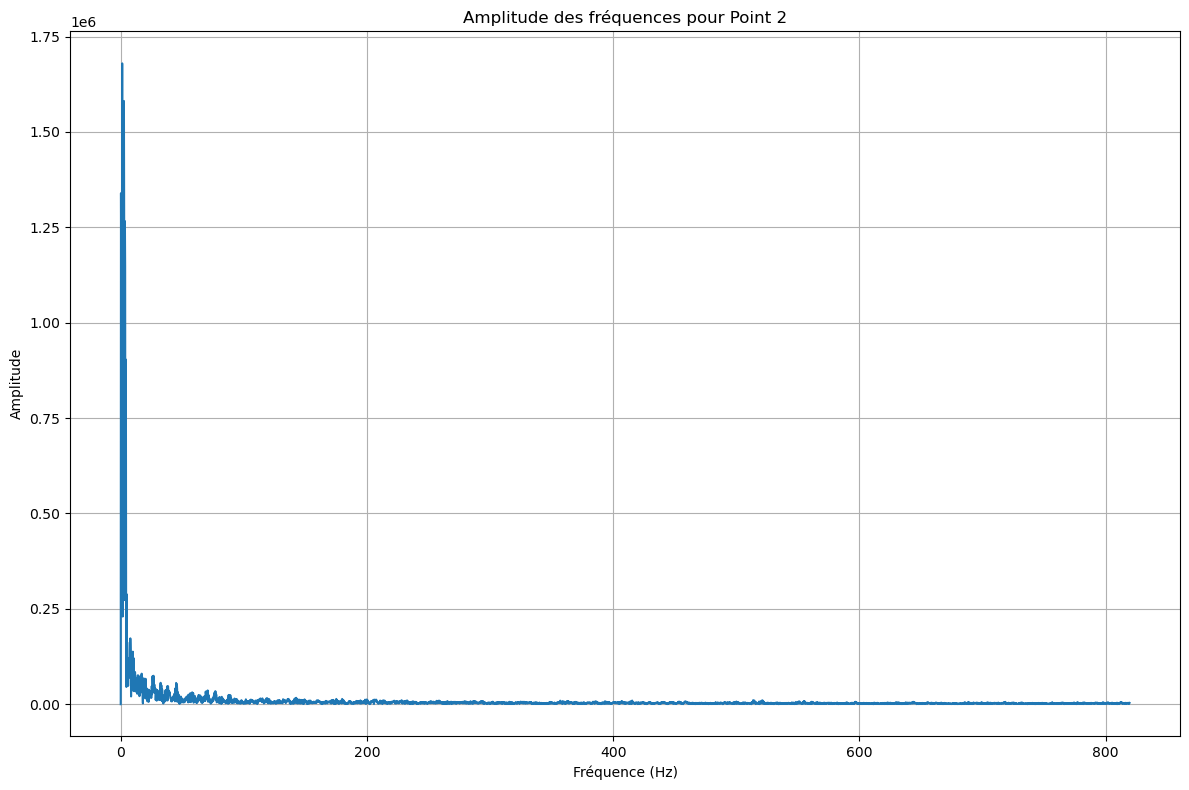

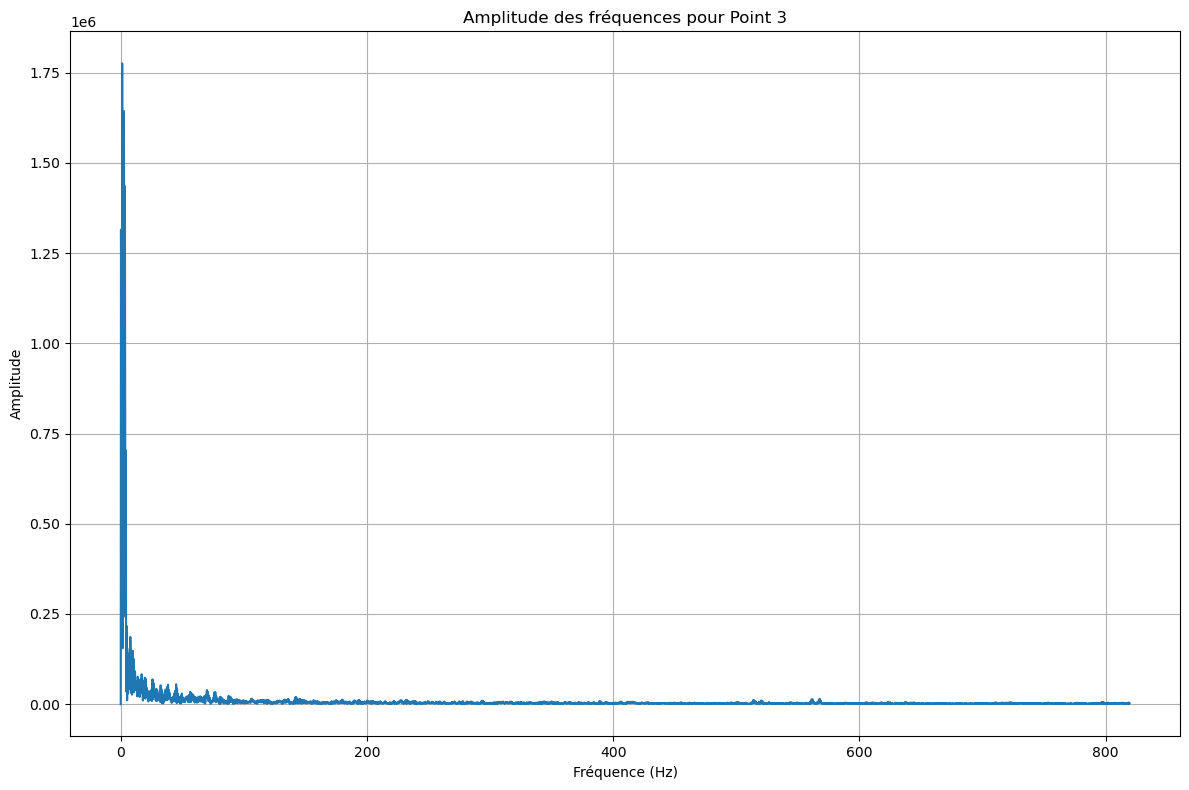

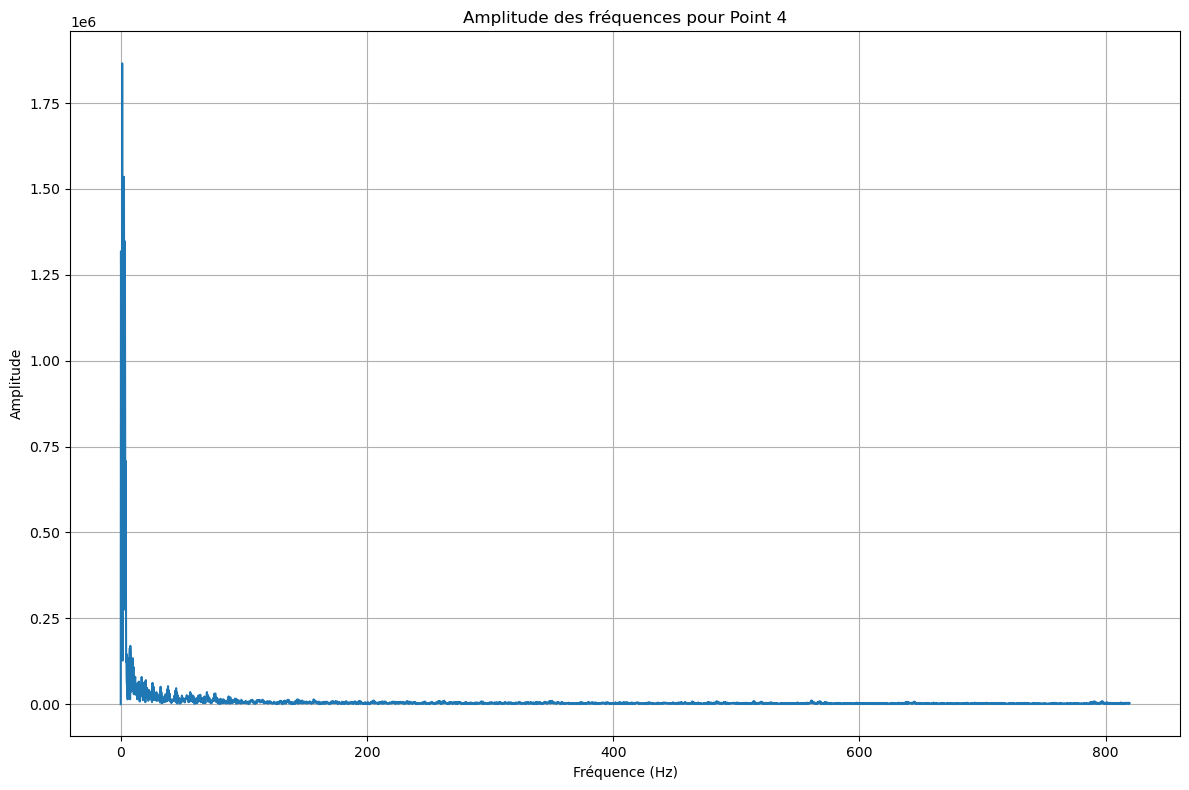

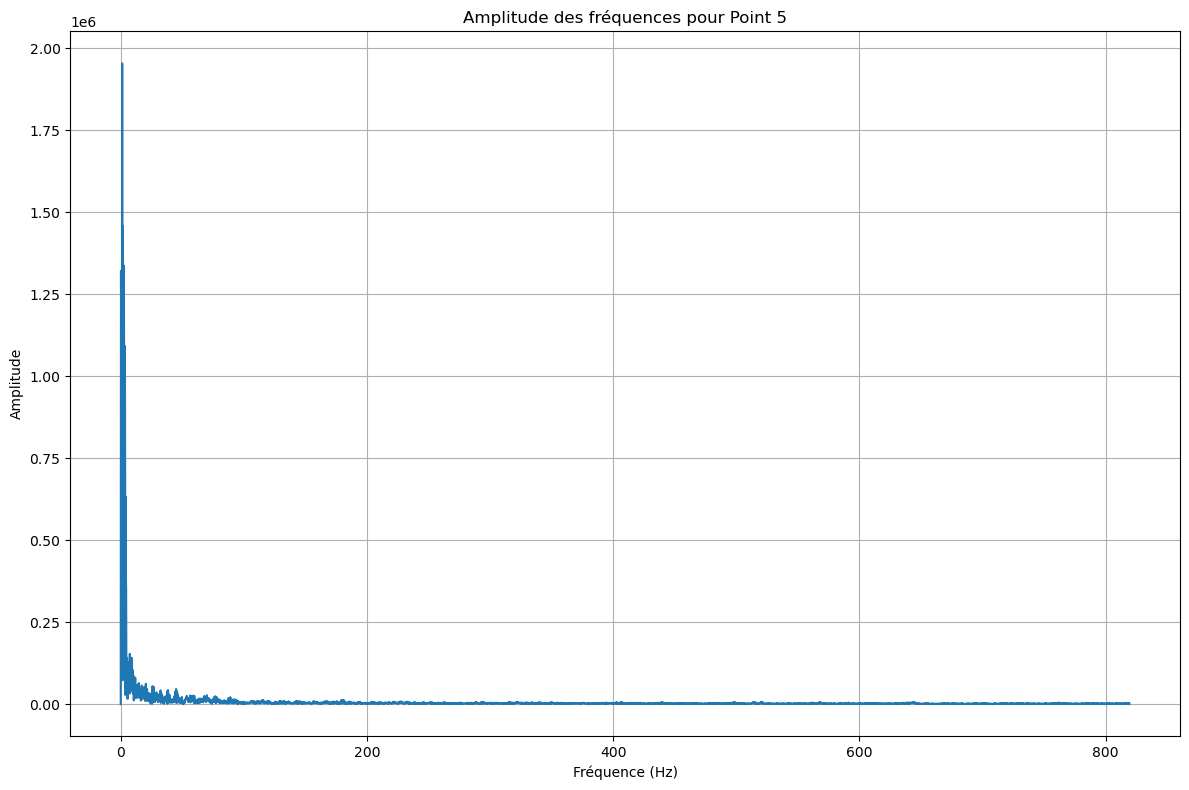

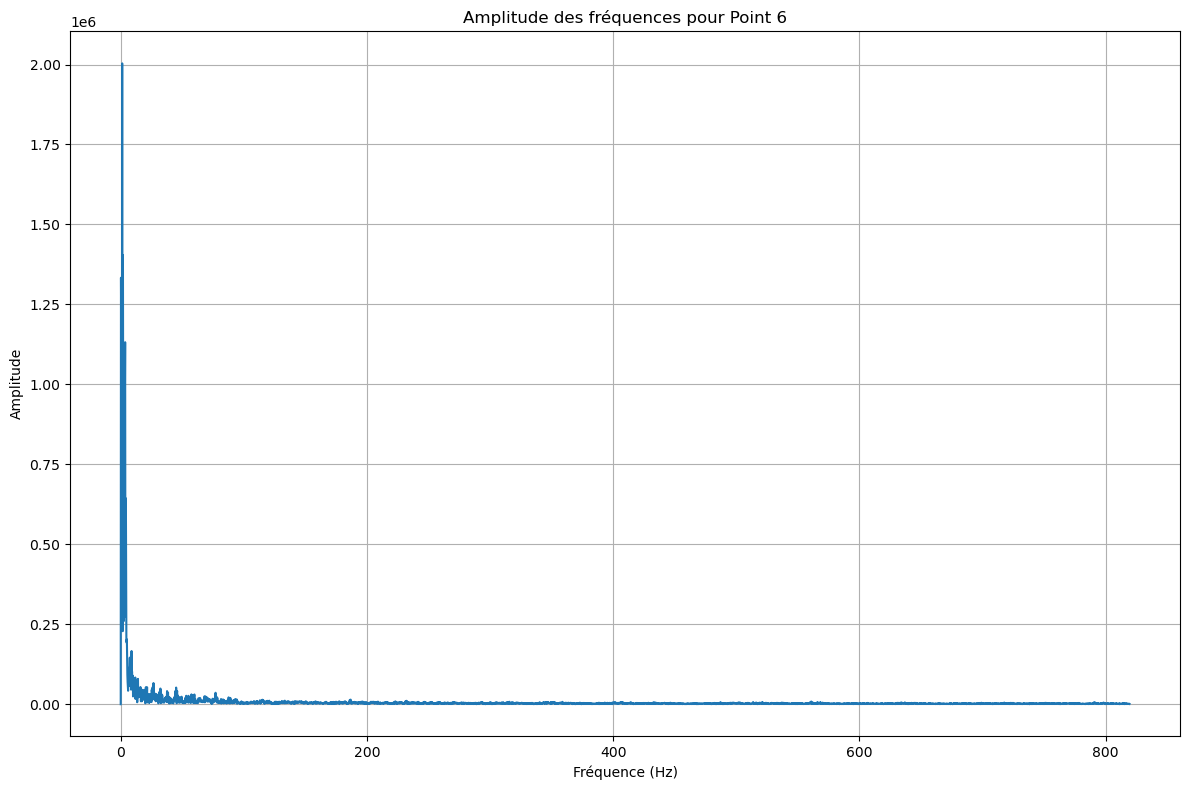

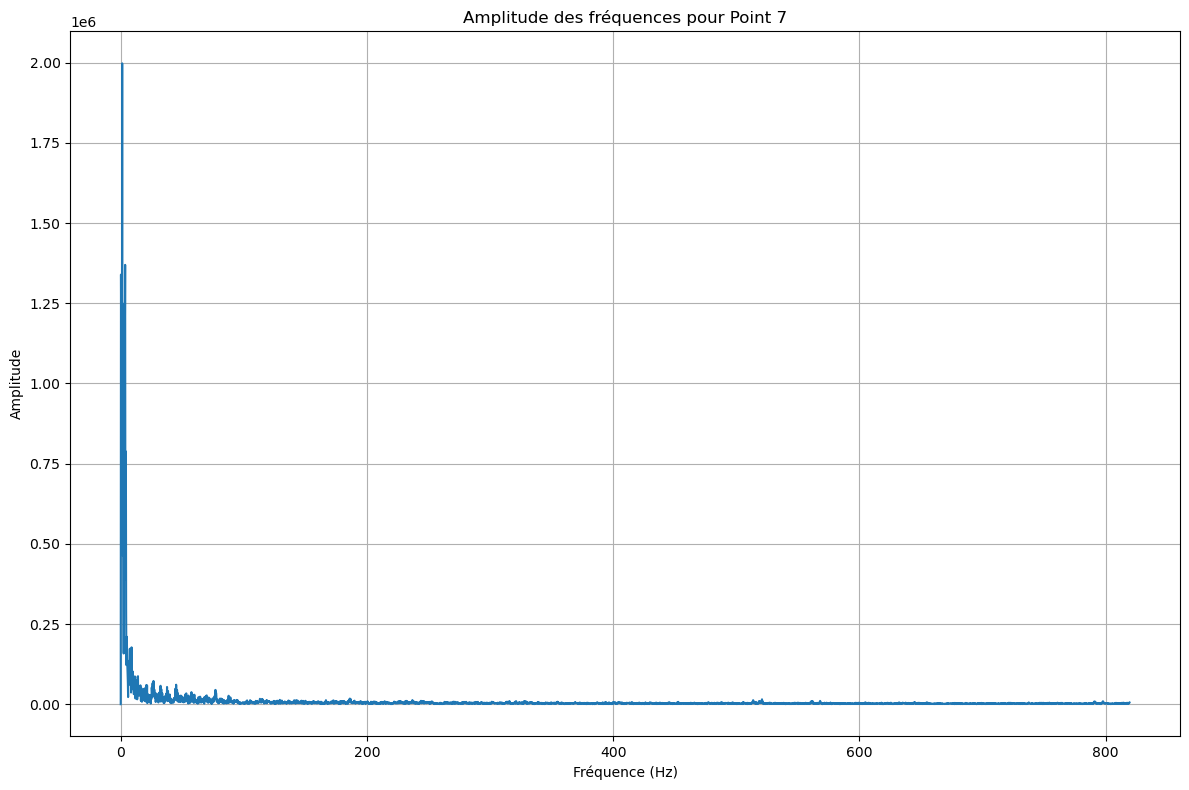

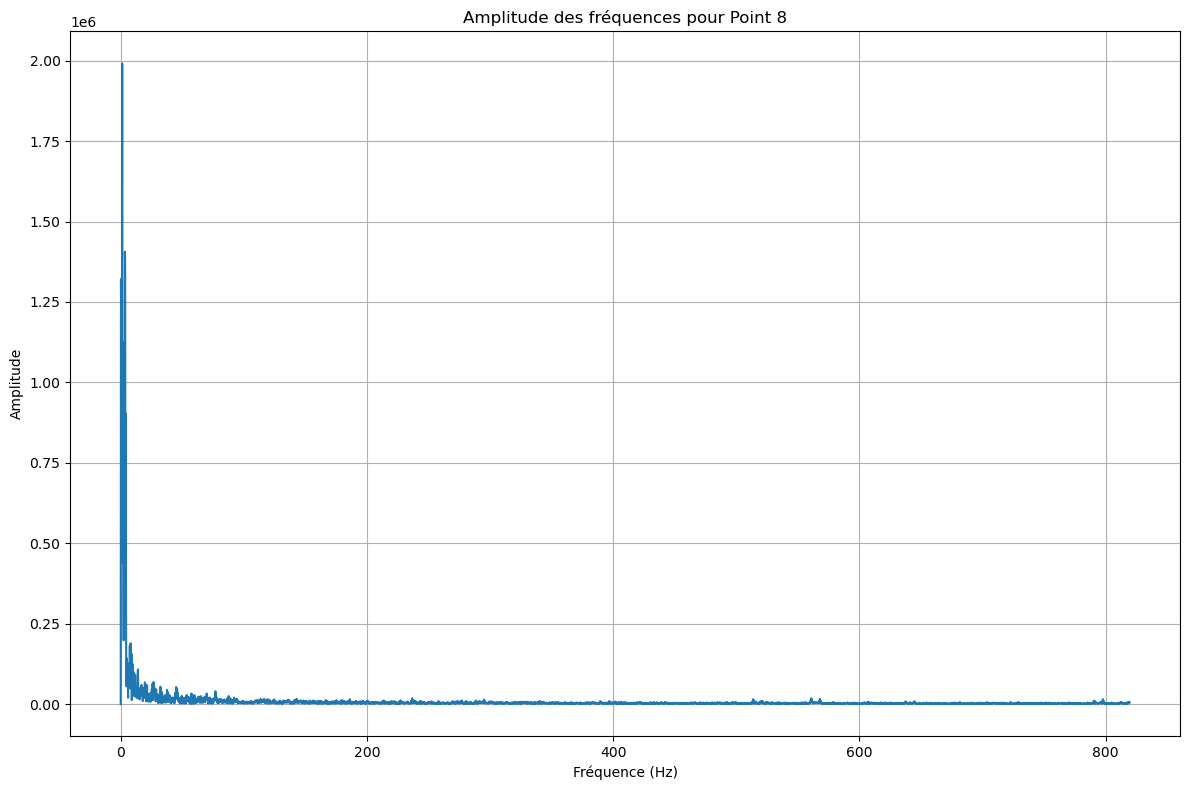

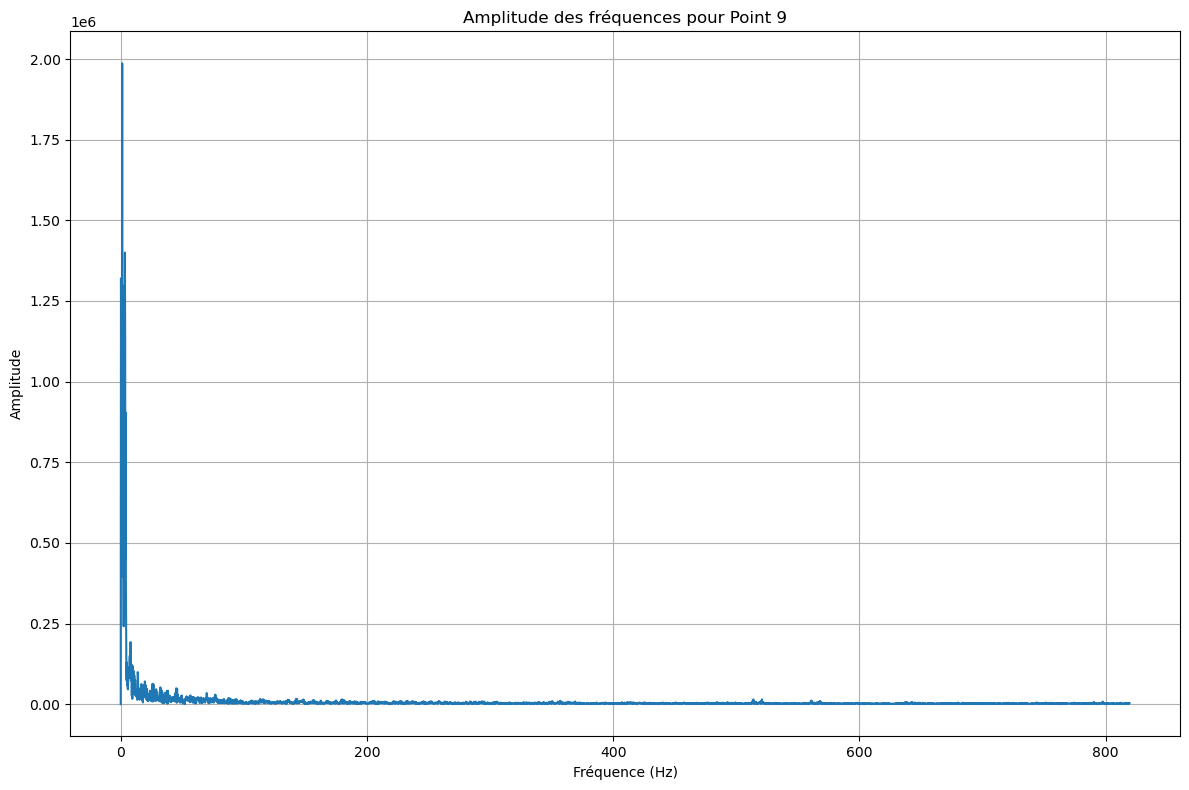

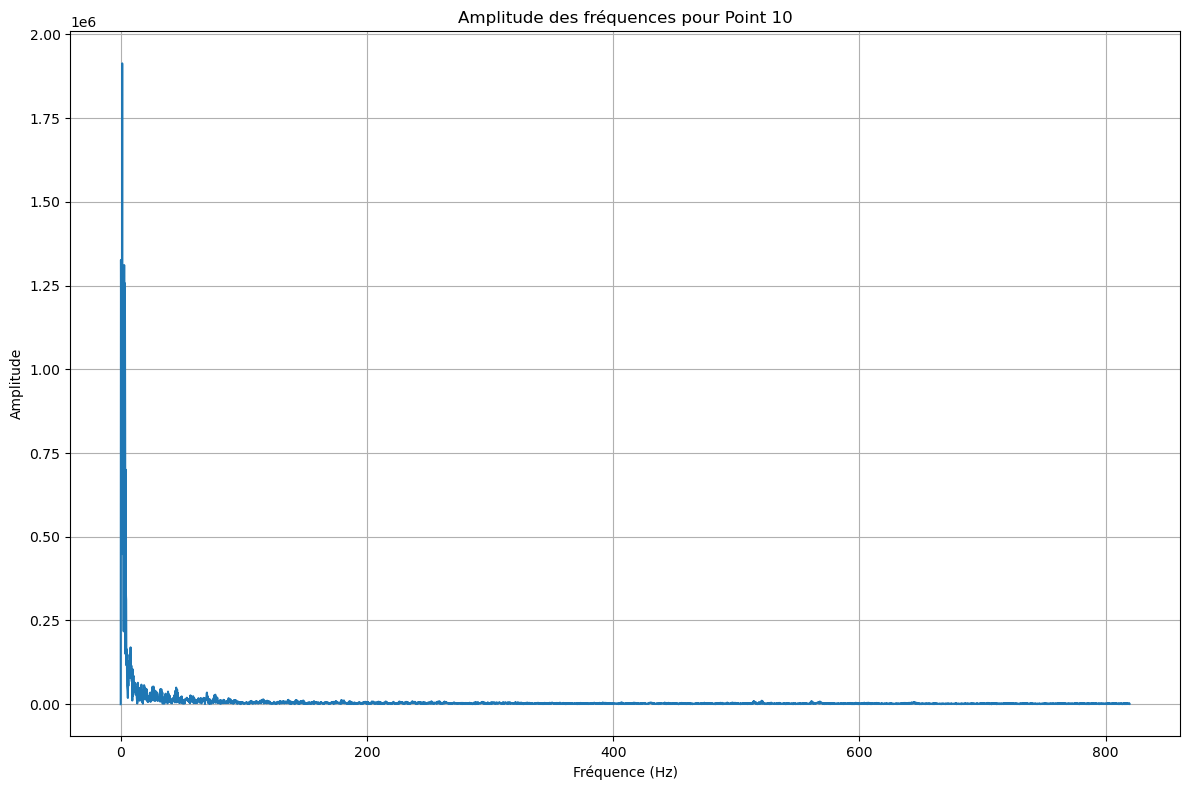

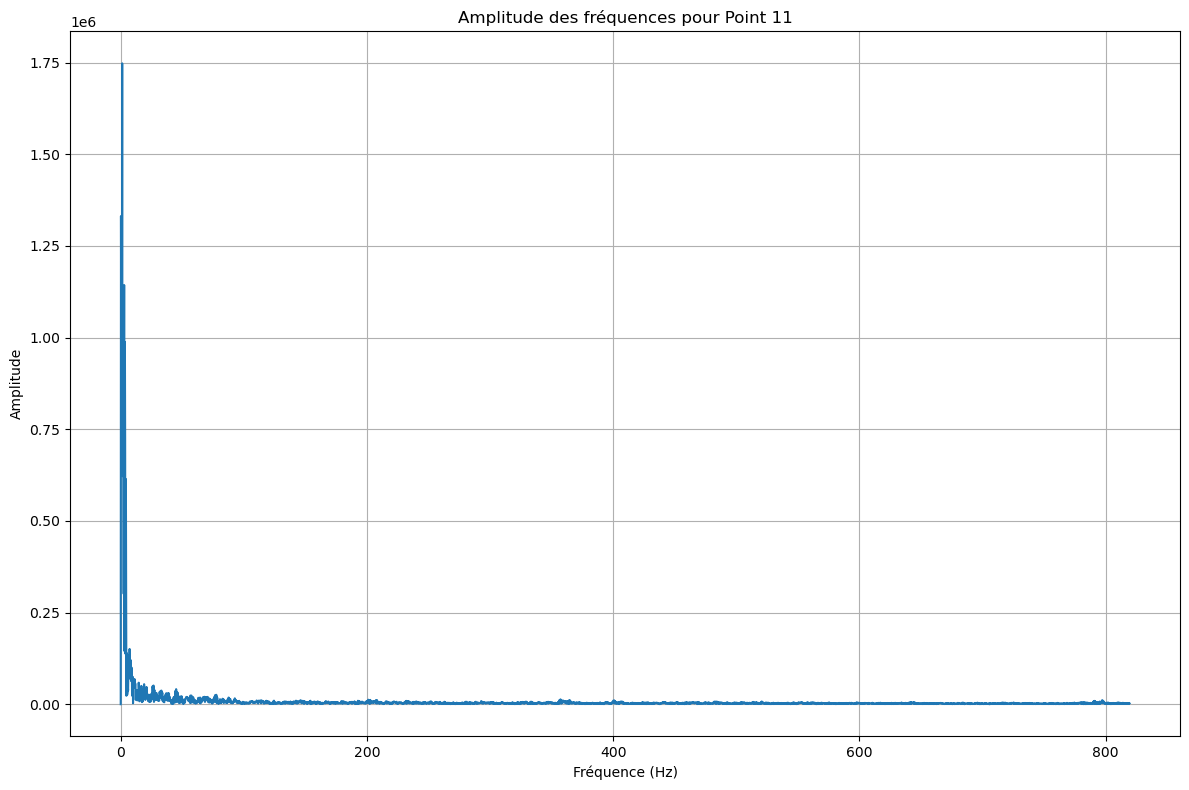

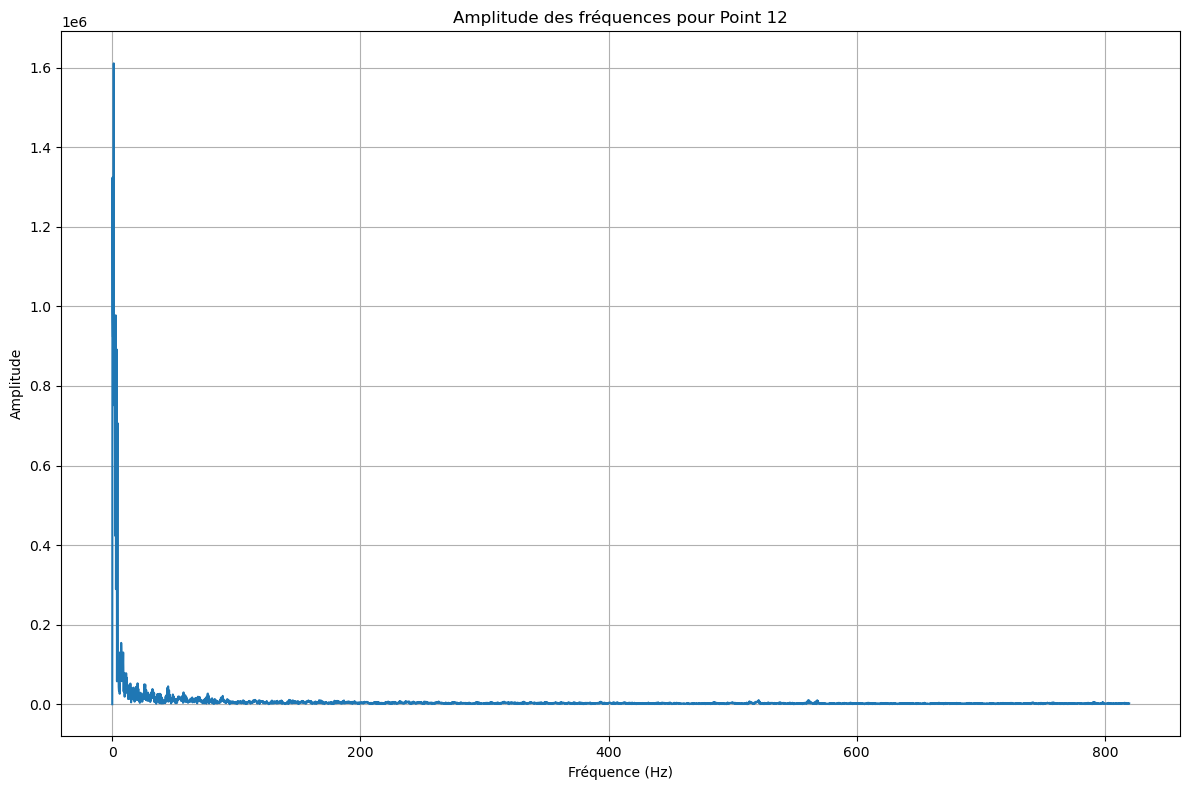

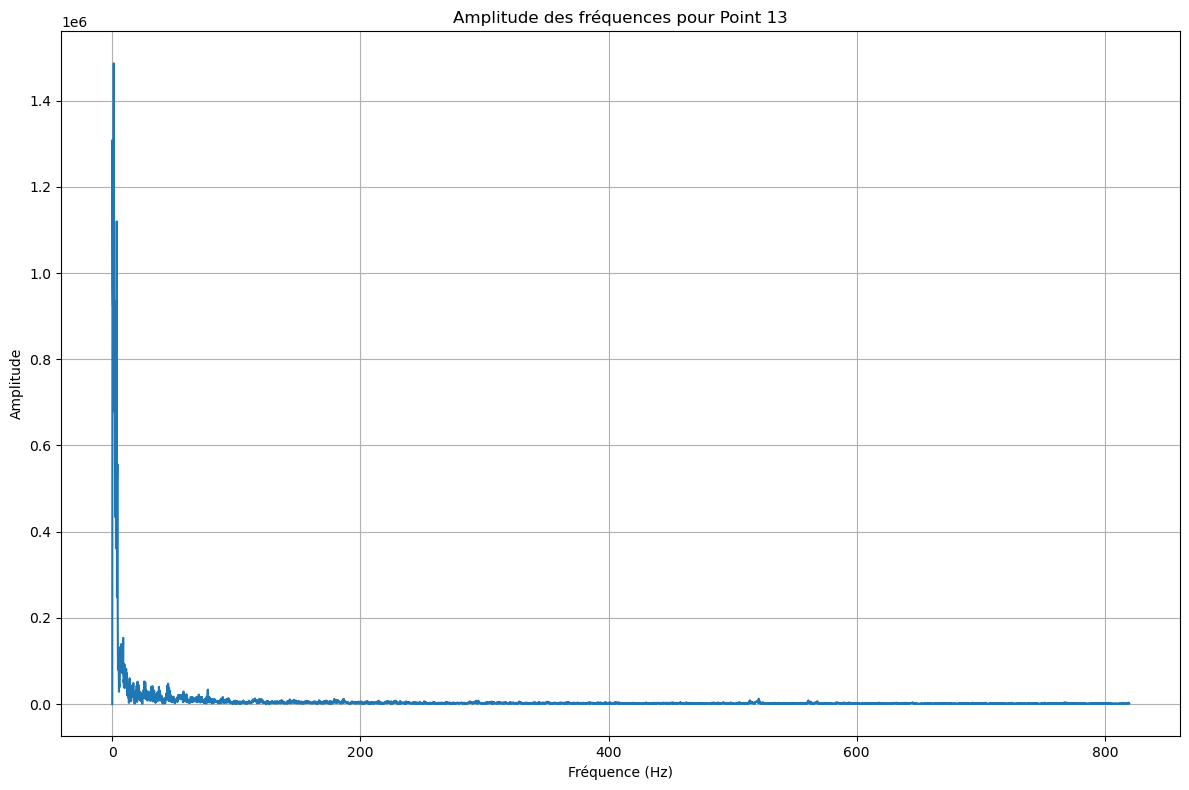

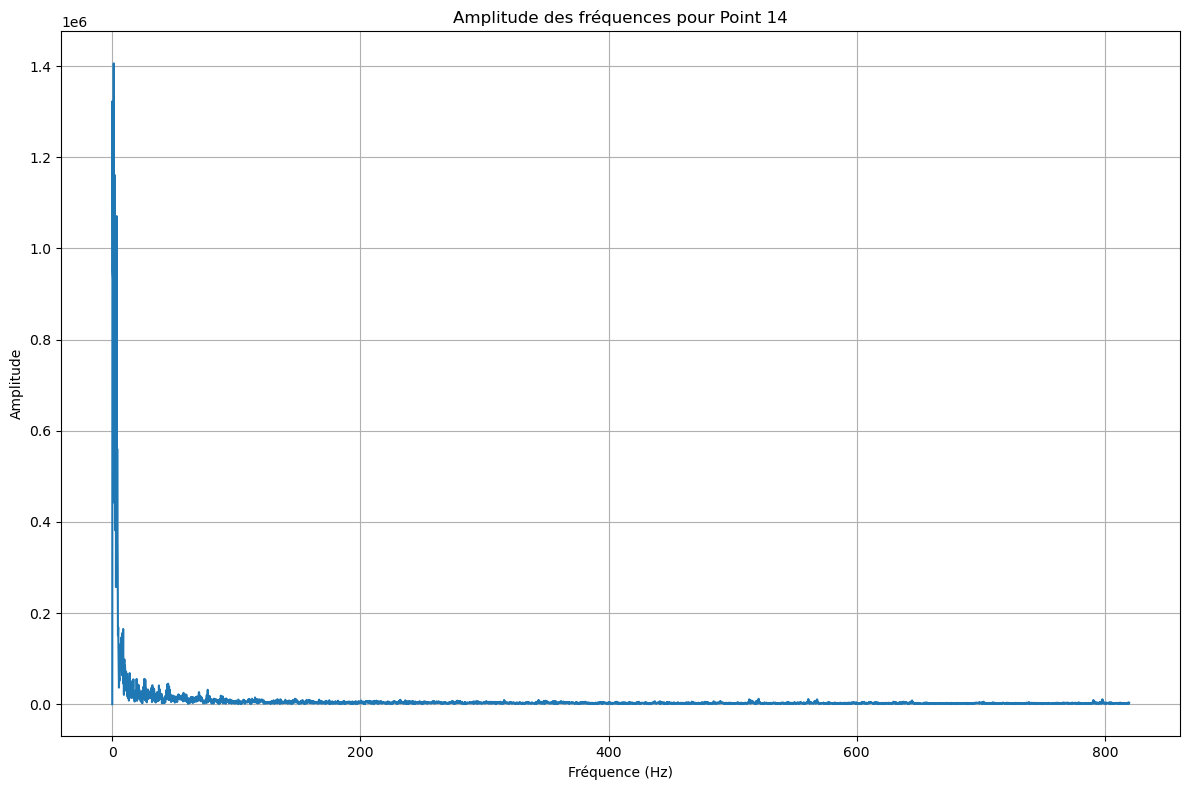

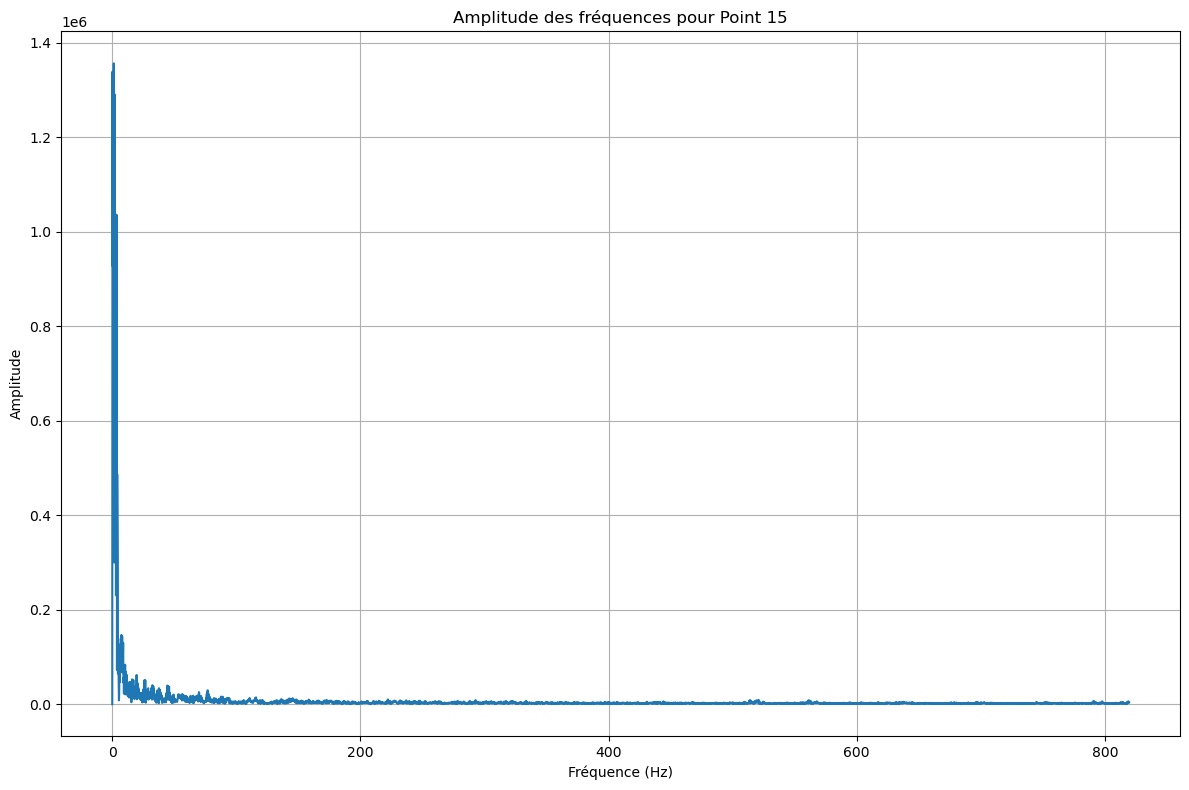

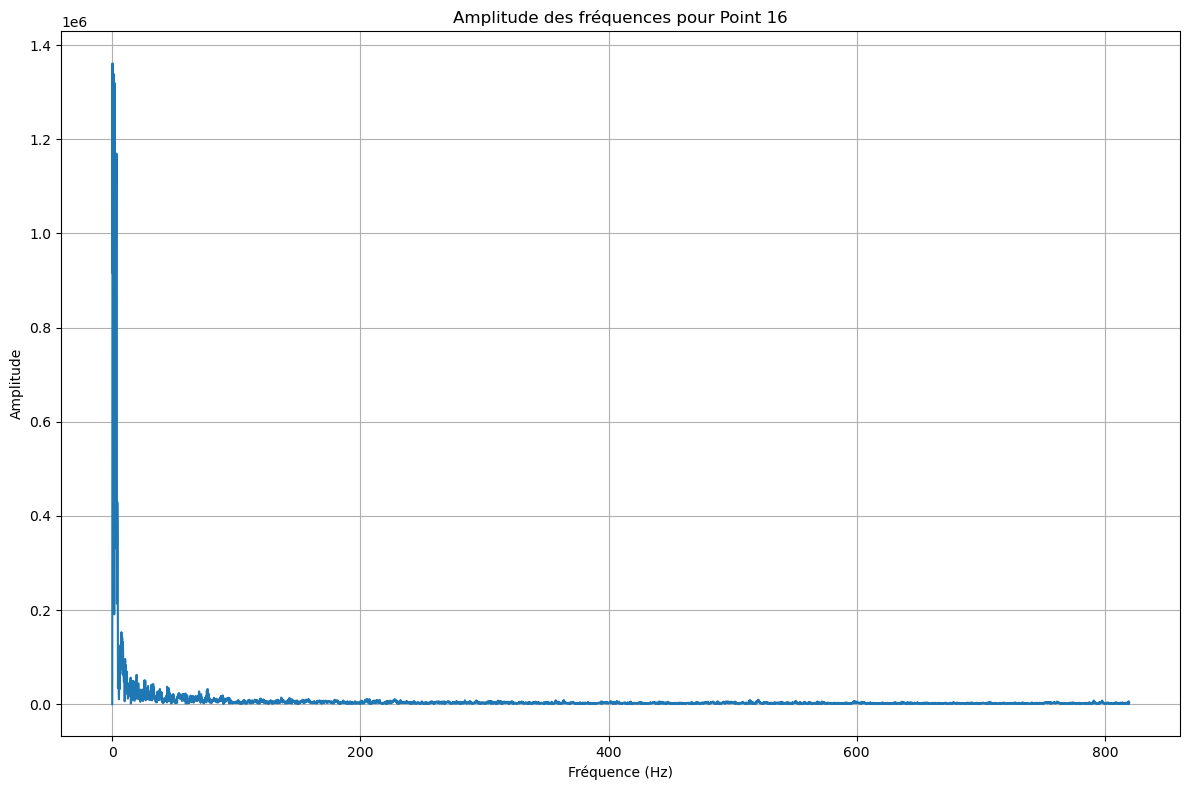

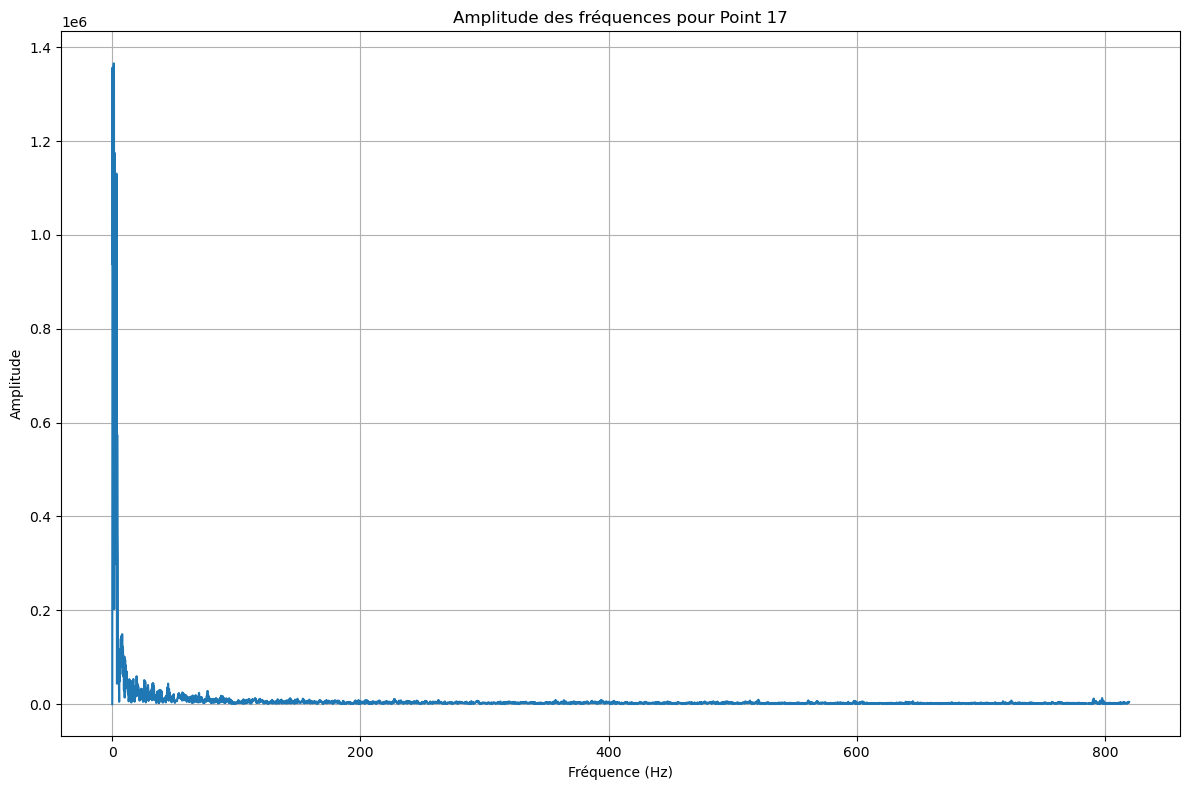

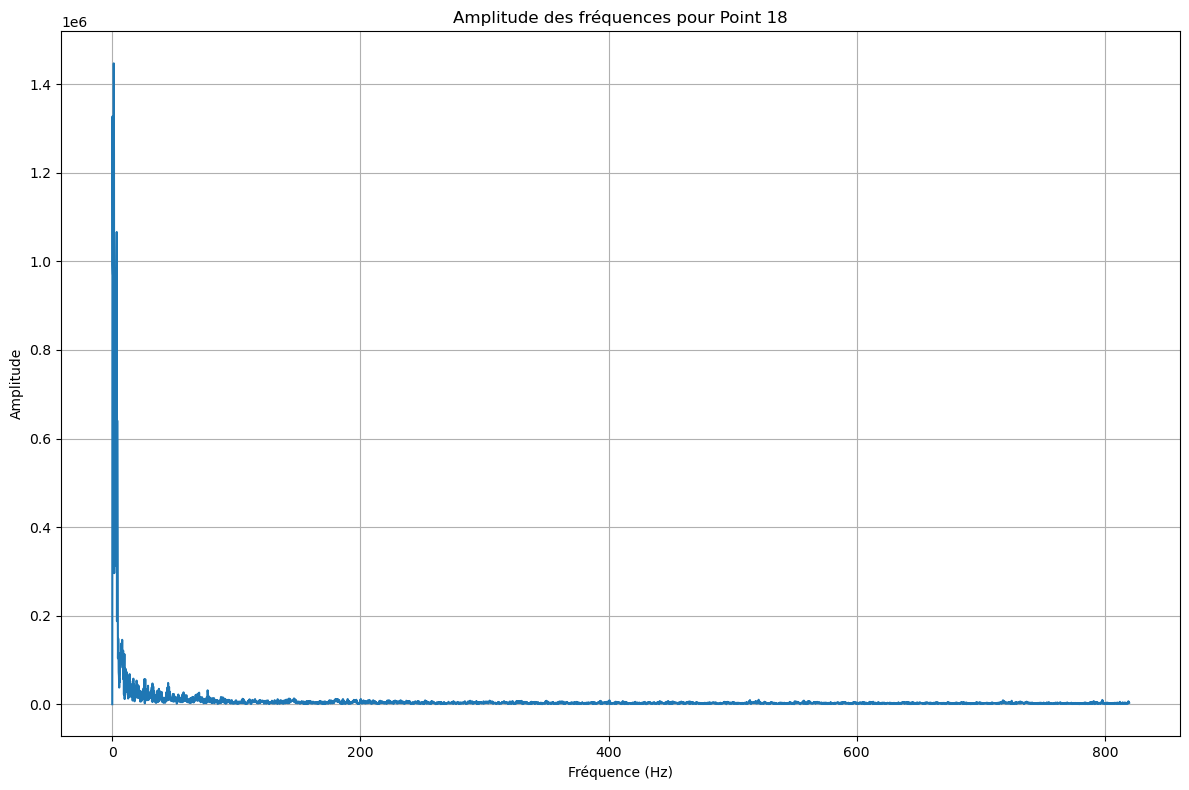

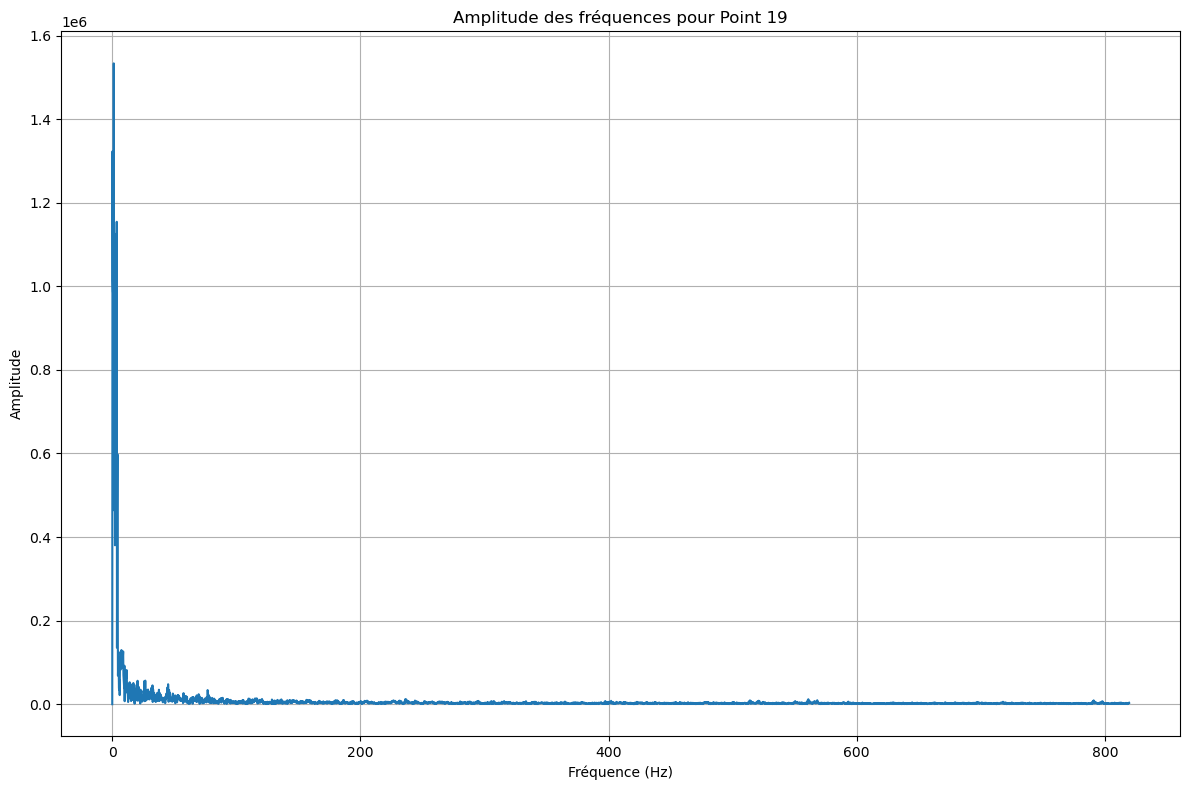

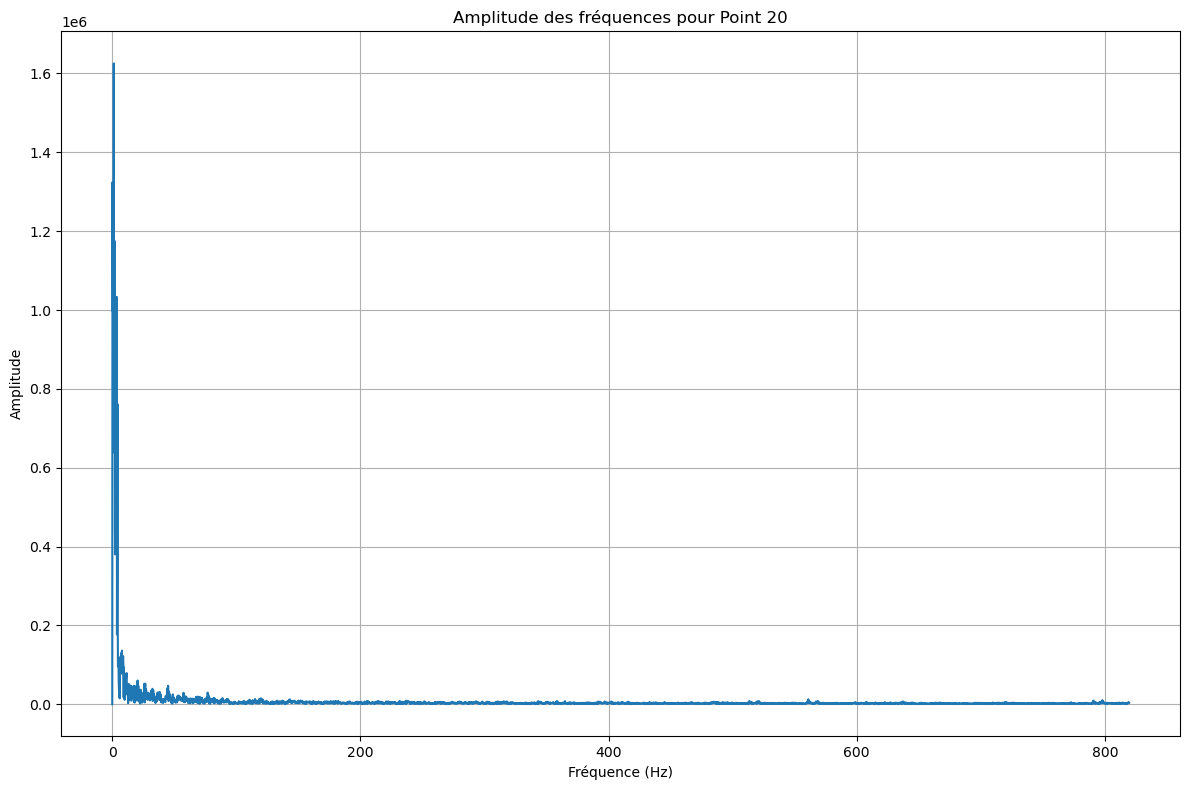

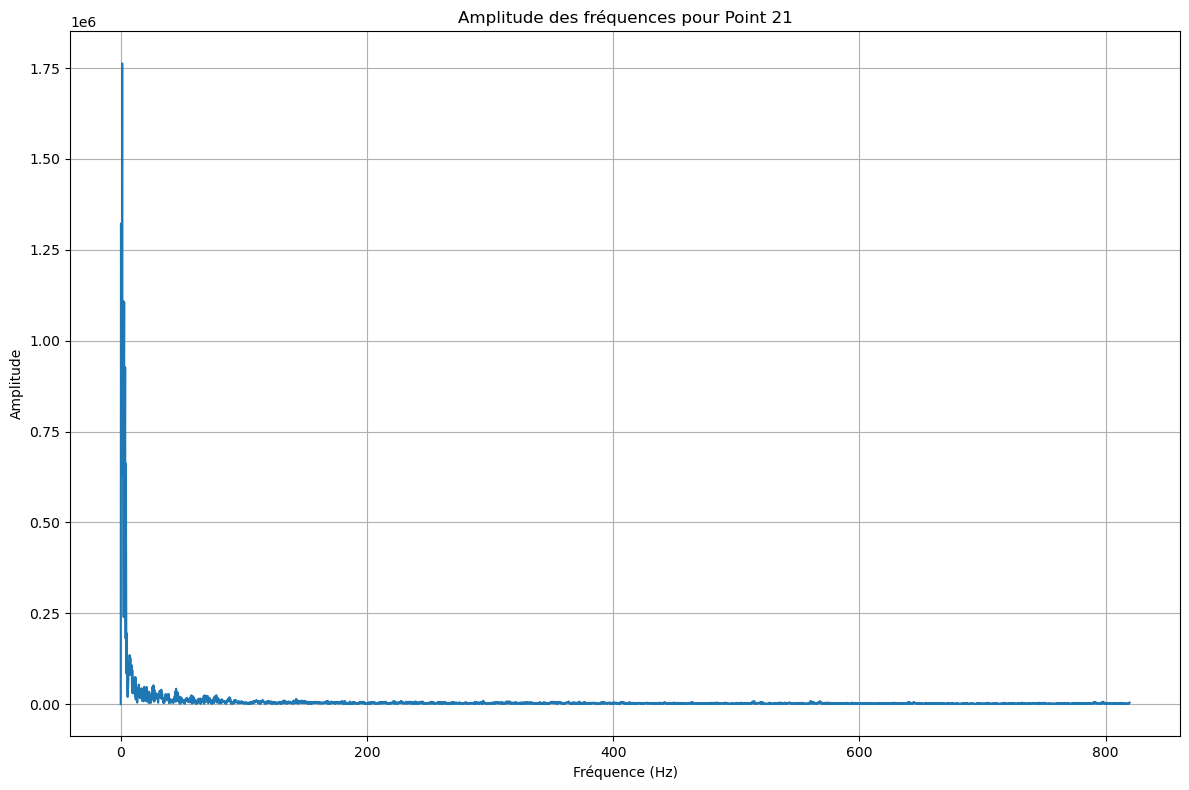

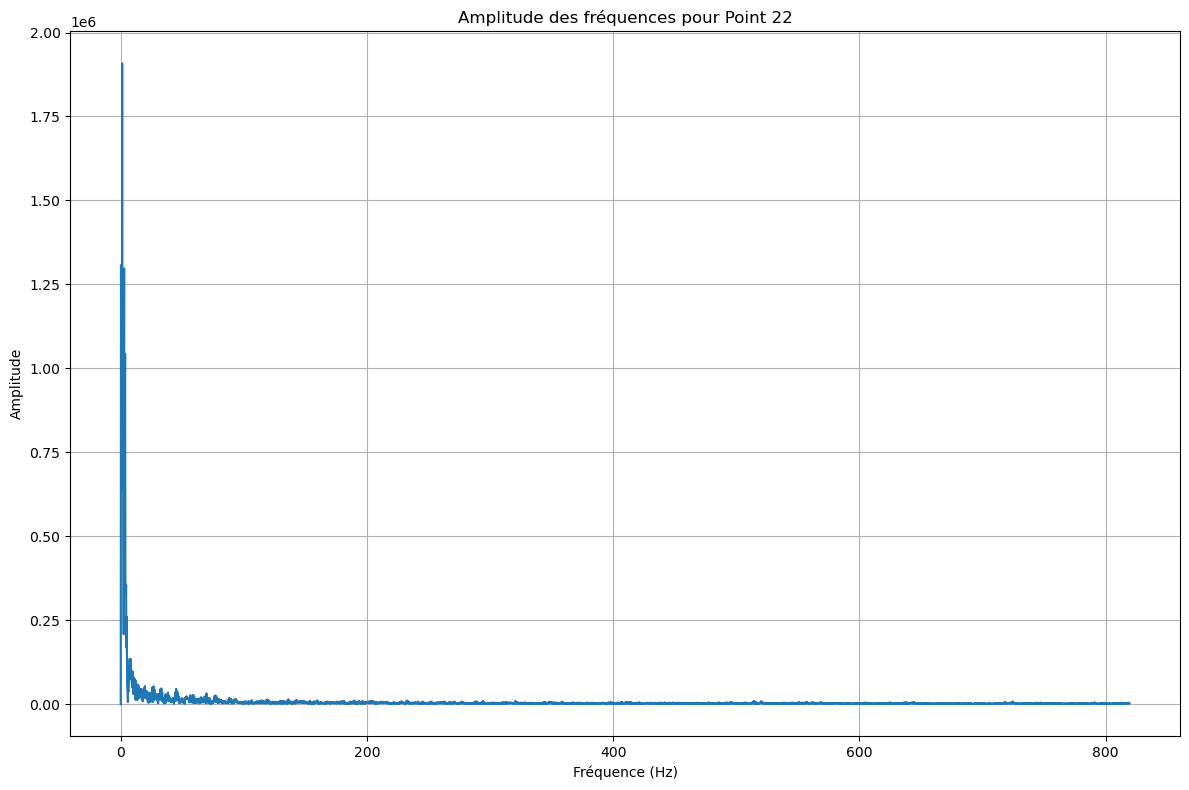

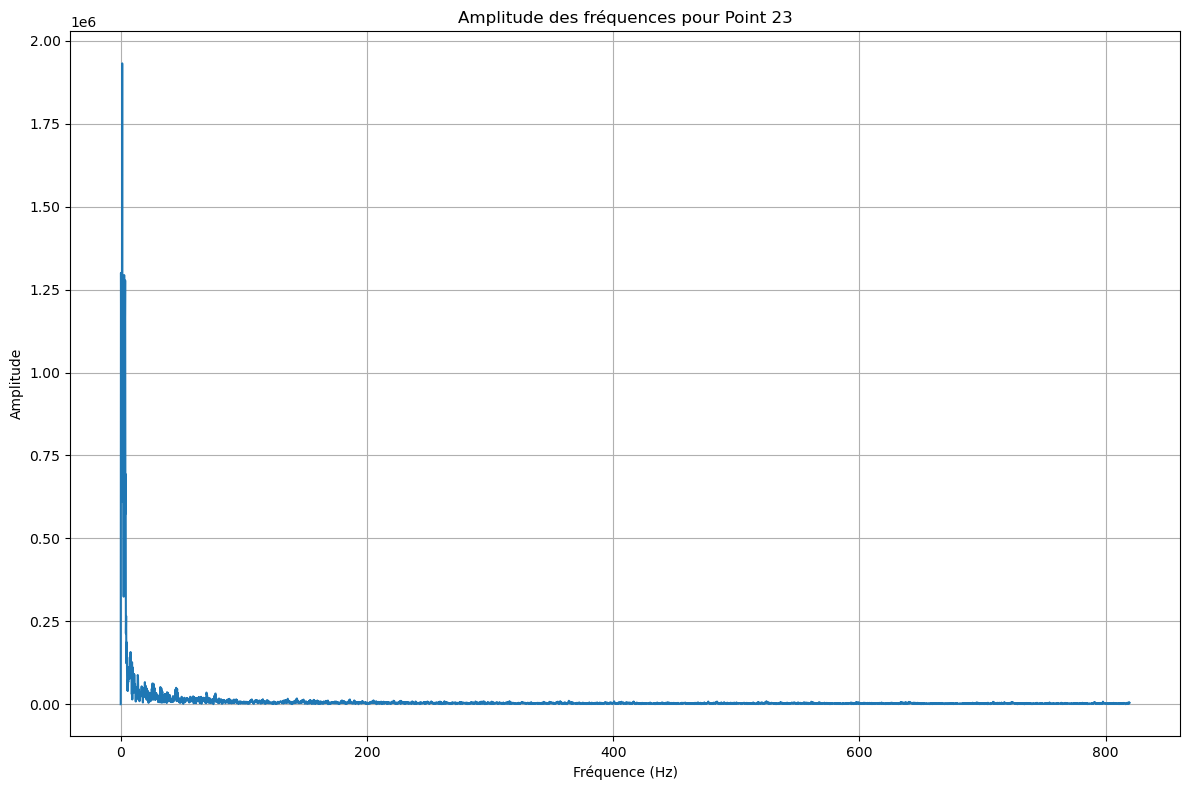

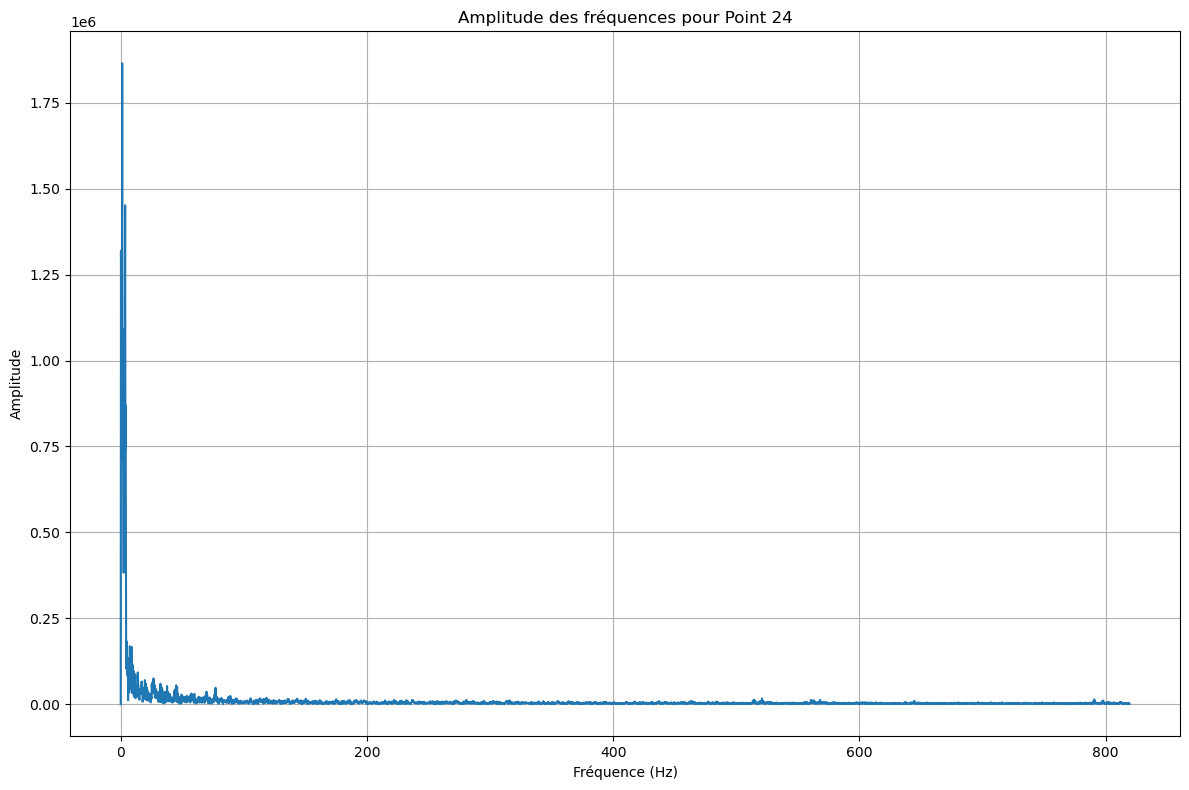

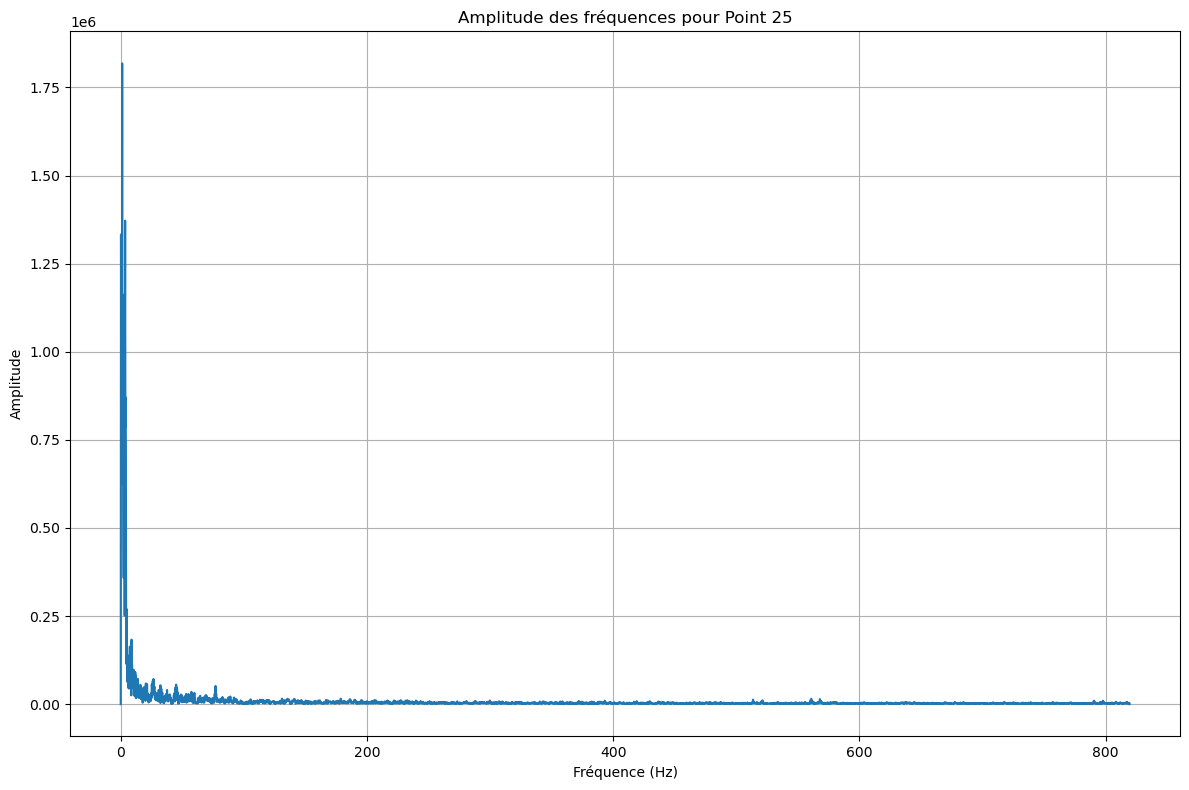

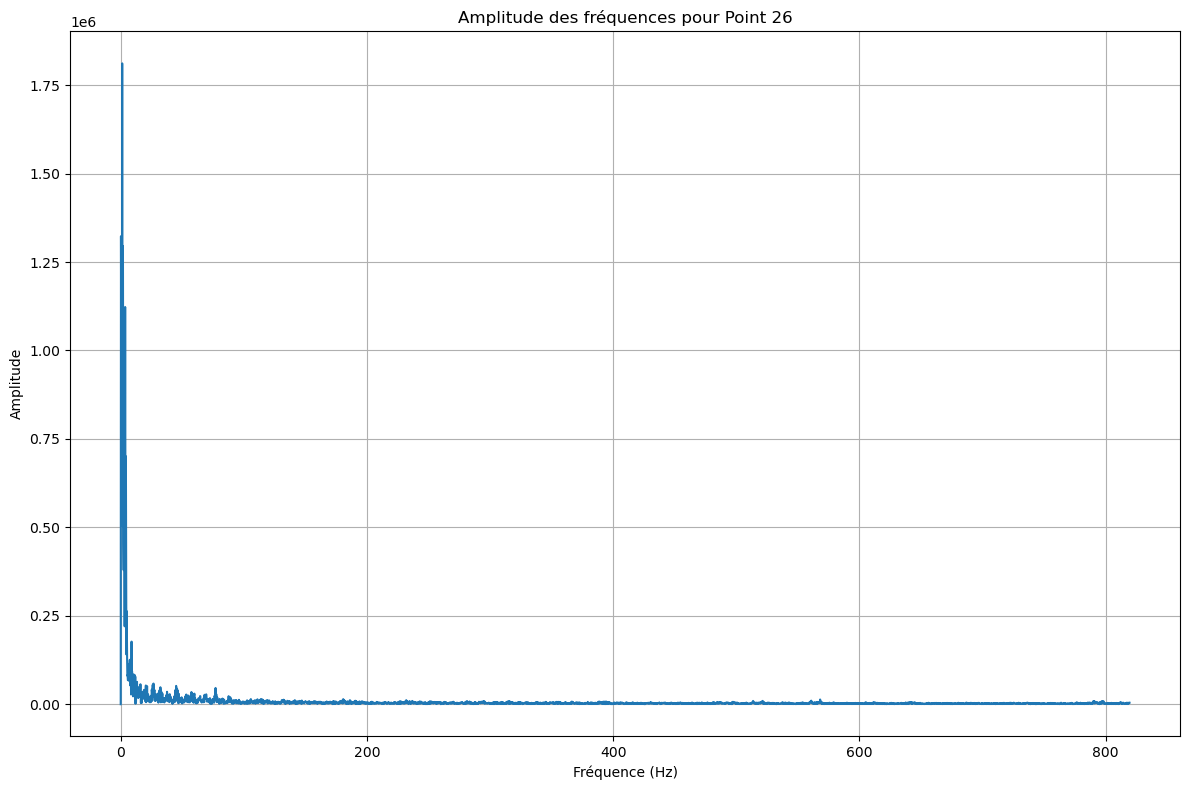

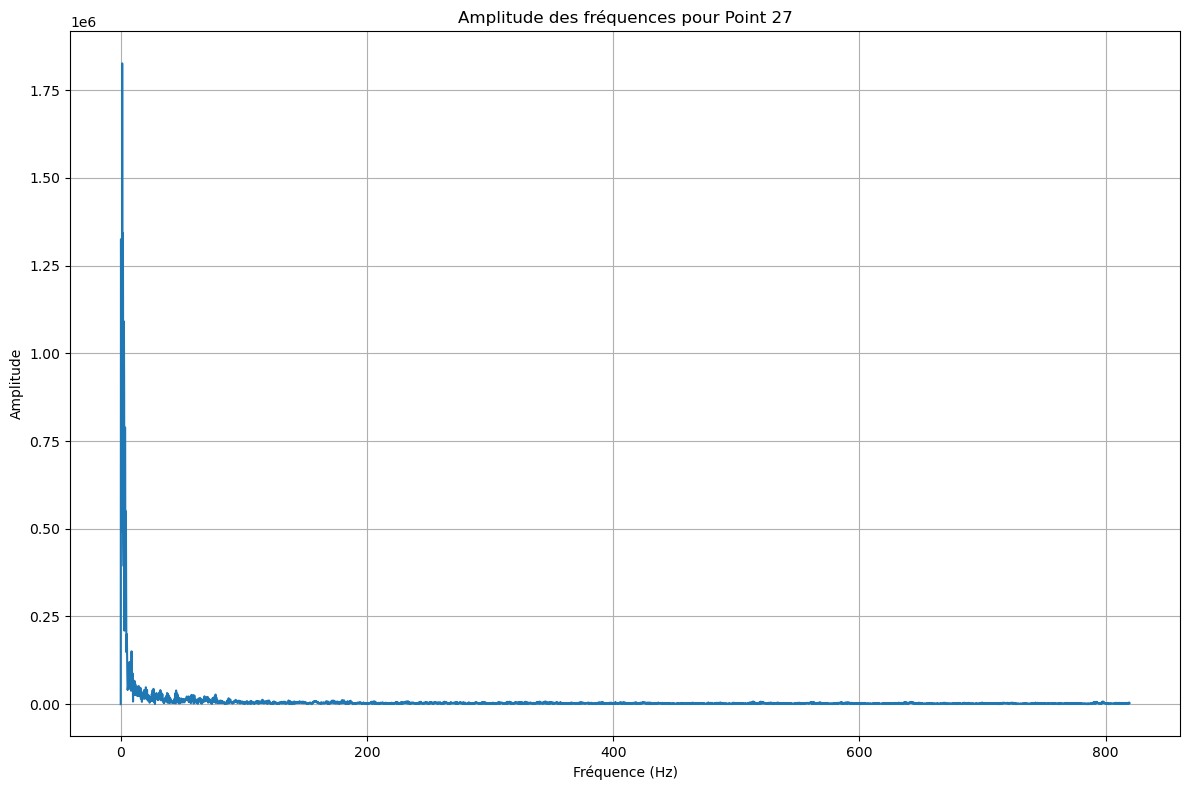

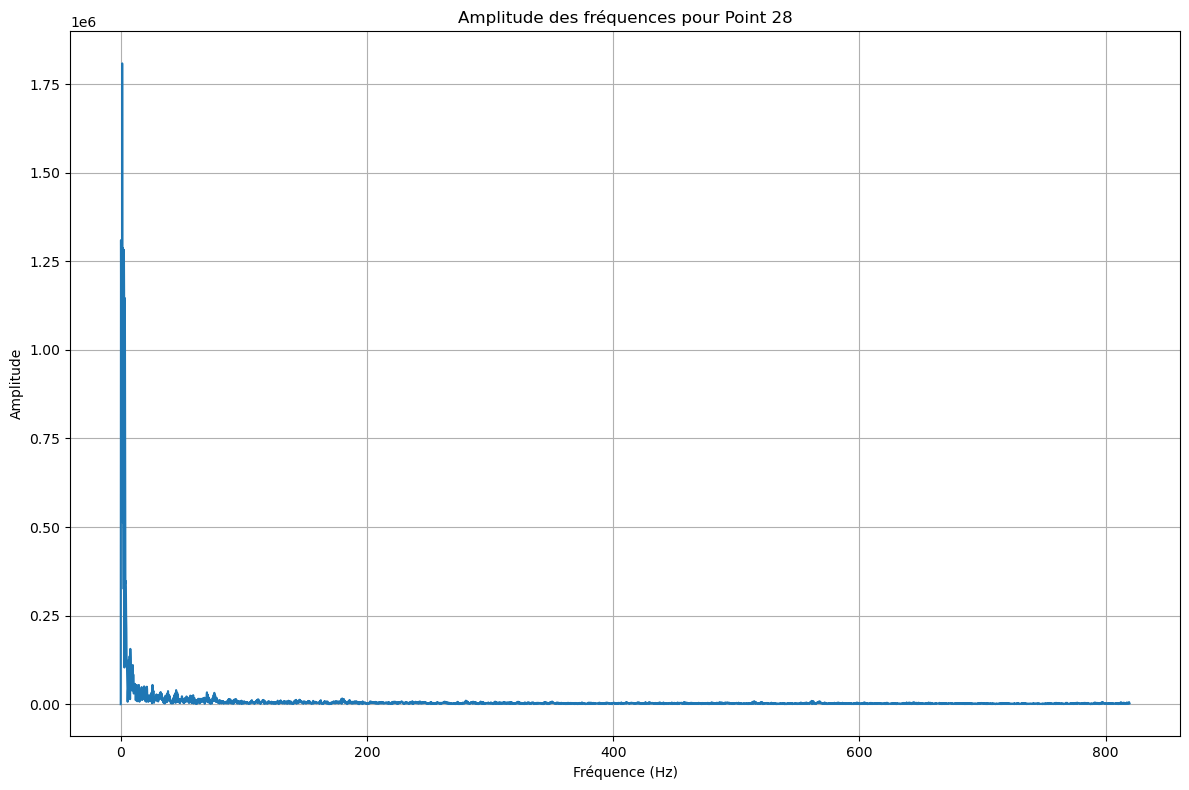

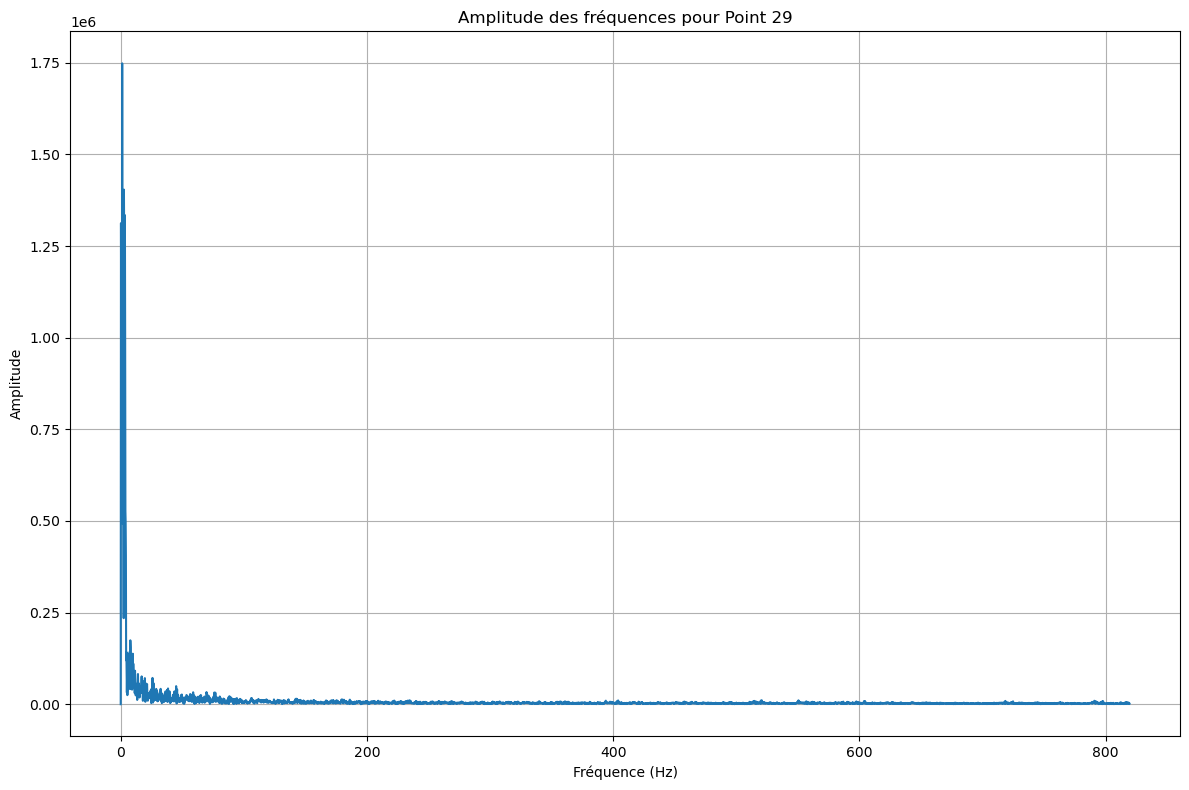

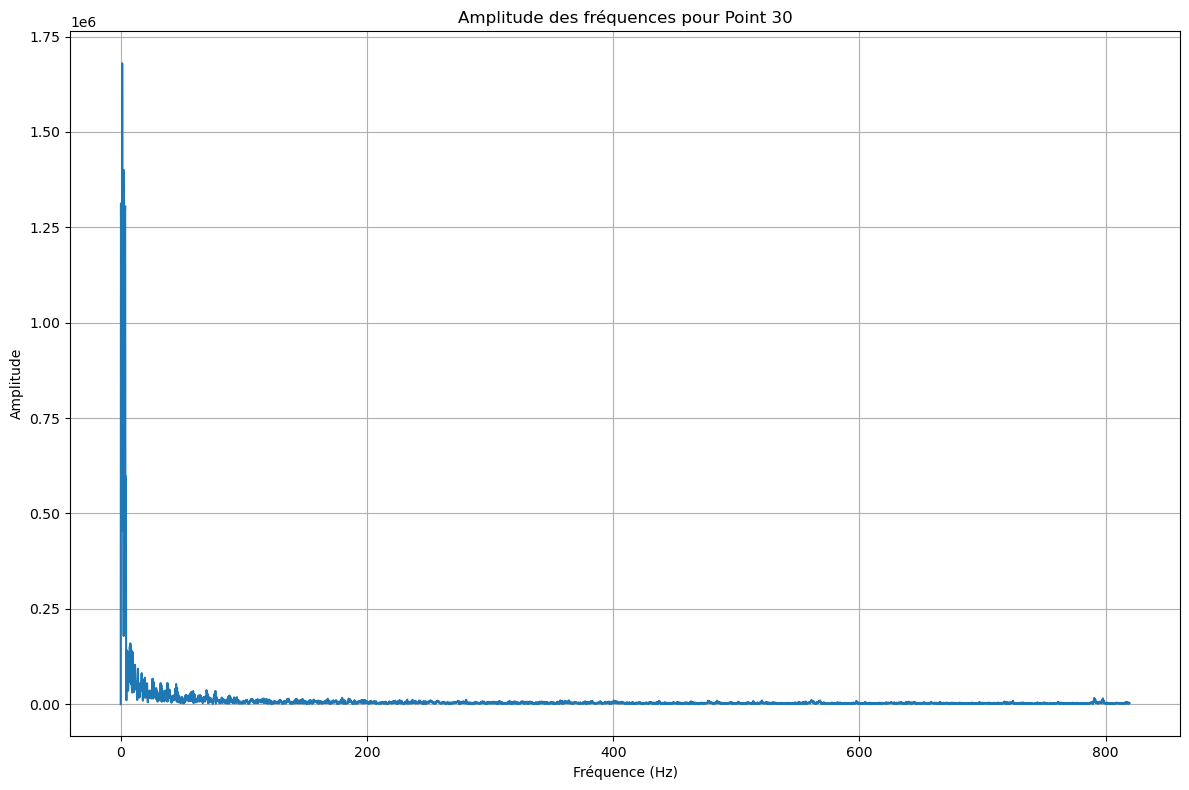

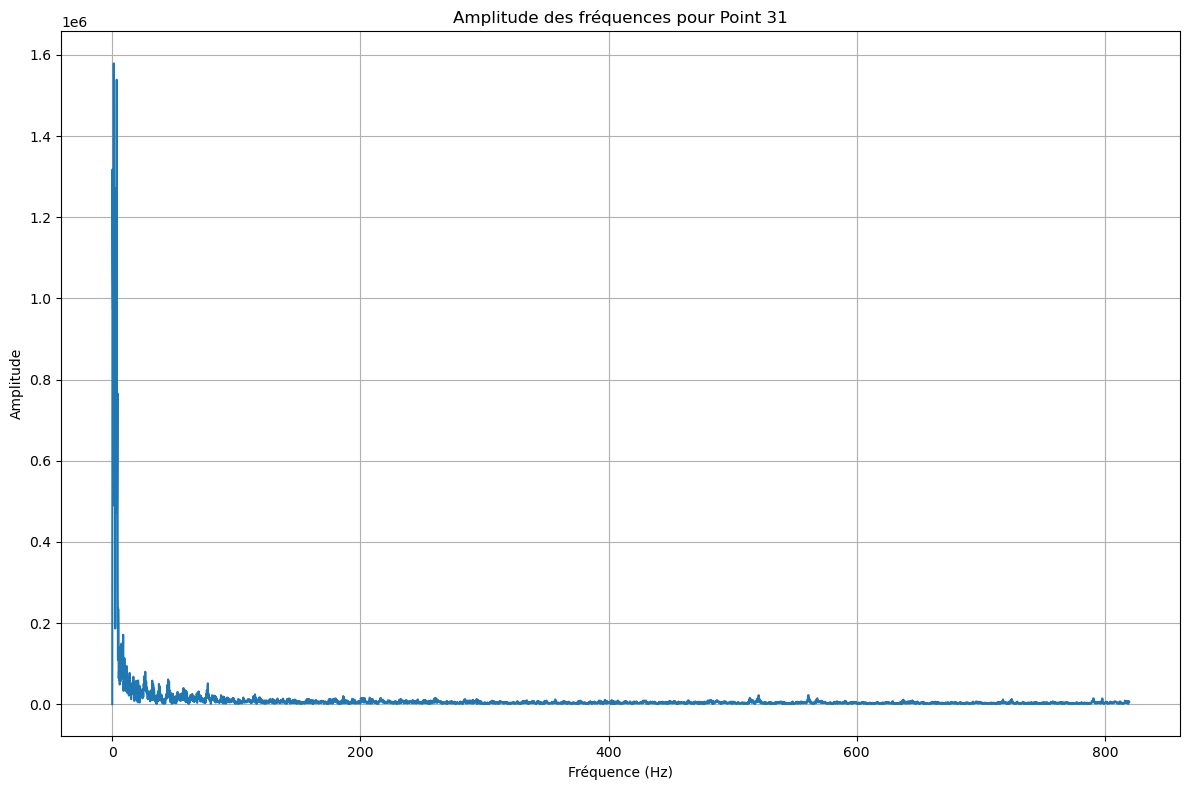

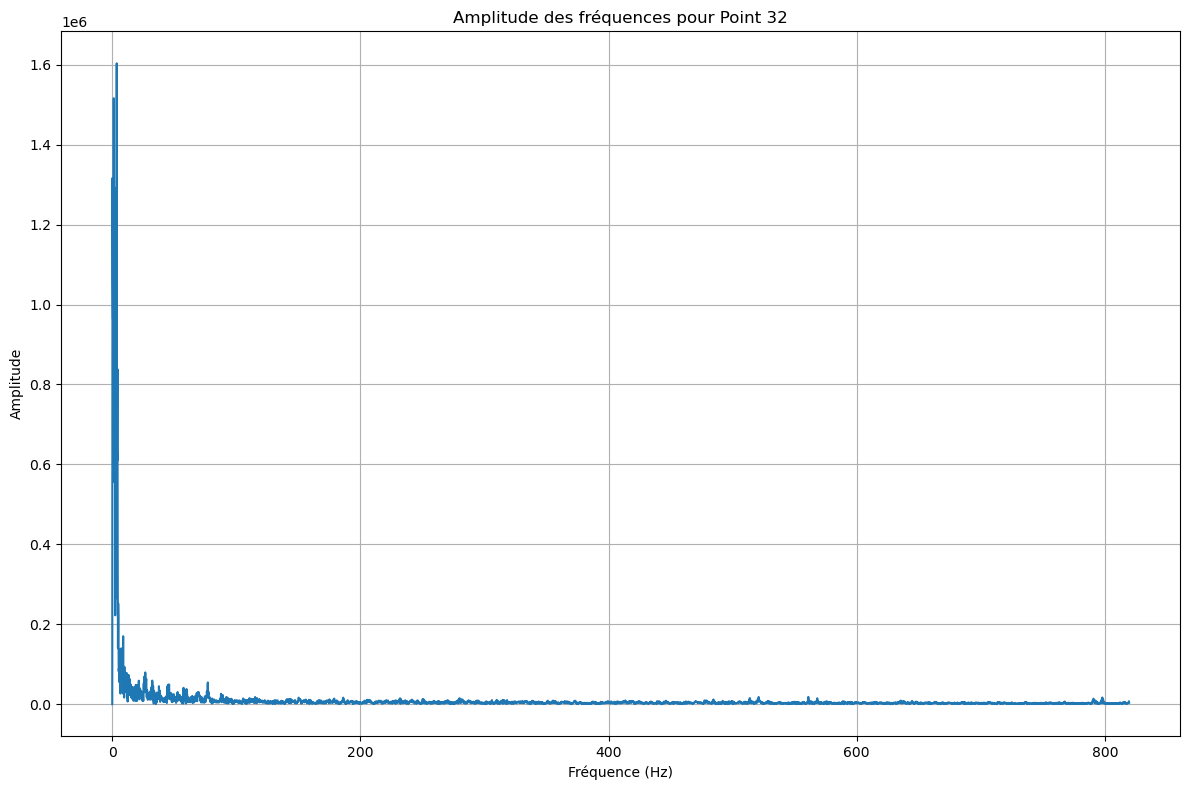

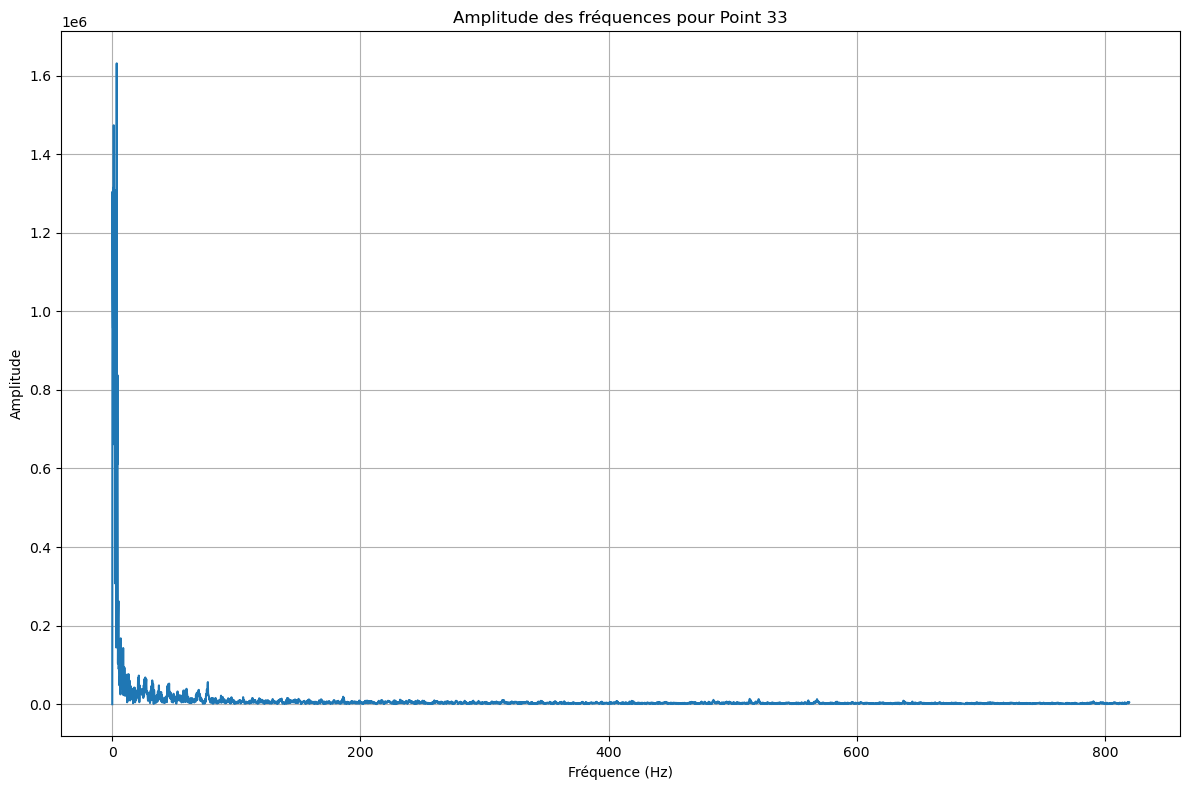

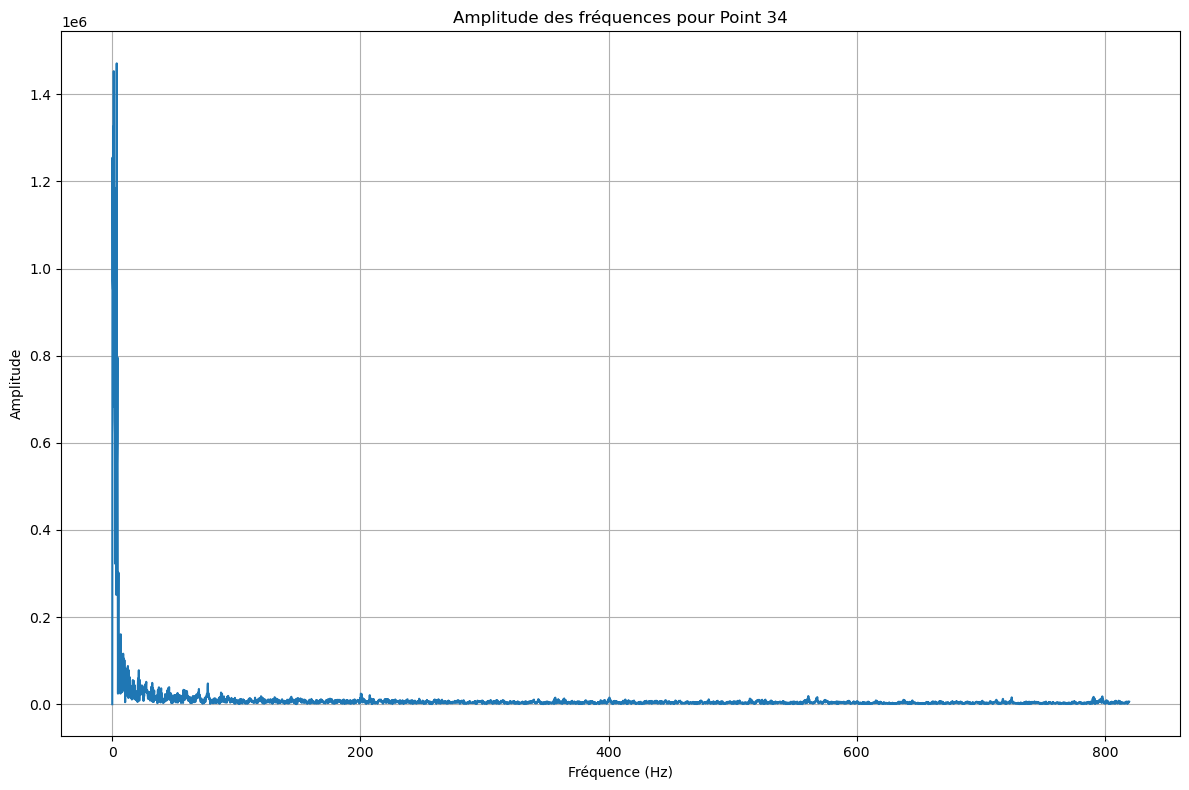

In [221]:
visualiser_matrice_fft_par_point(fft_df)


In [222]:
def visualiser_matrice_fft_par_pointZOOM(fft_df, max_freq=20):
    # Vérifier que le DataFrame n'est pas None
    if fft_df is None:
        print("Erreur : Le DataFrame fft_df est None.")
        return
    
    try:
        # Visualisation de chaque point de mesure
        freqs = fft_df['Frequence']
        mask = freqs <= max_freq  # Limiter les fréquences affichées à max_freq Hz
        
        for col in fft_df.columns[1:]:
            plt.figure(figsize=(12, 8))
            plt.plot(freqs[mask], fft_df[col][mask])
            plt.title(f'Amplitude des fréquences pour {col}')
            plt.xlabel('Fréquence (Hz)')
            plt.ylabel('Amplitude')
            plt.grid(True)
            plt.tight_layout()
            plt.xlim(0, max_freq)  # Limiter l'axe x à 0-100 Hz
            plt.show()
    except Exception as e:
        print(f"Erreur lors de la visualisation de la matrice FFT : {e}")

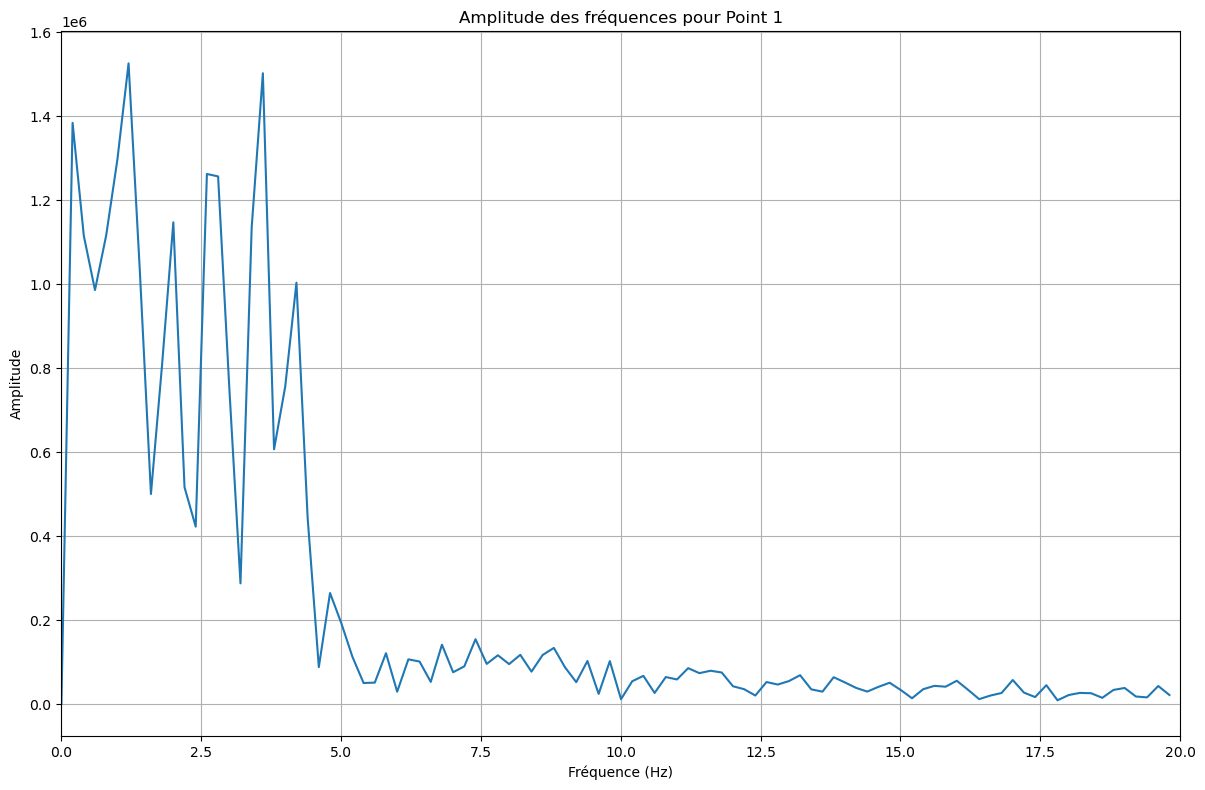

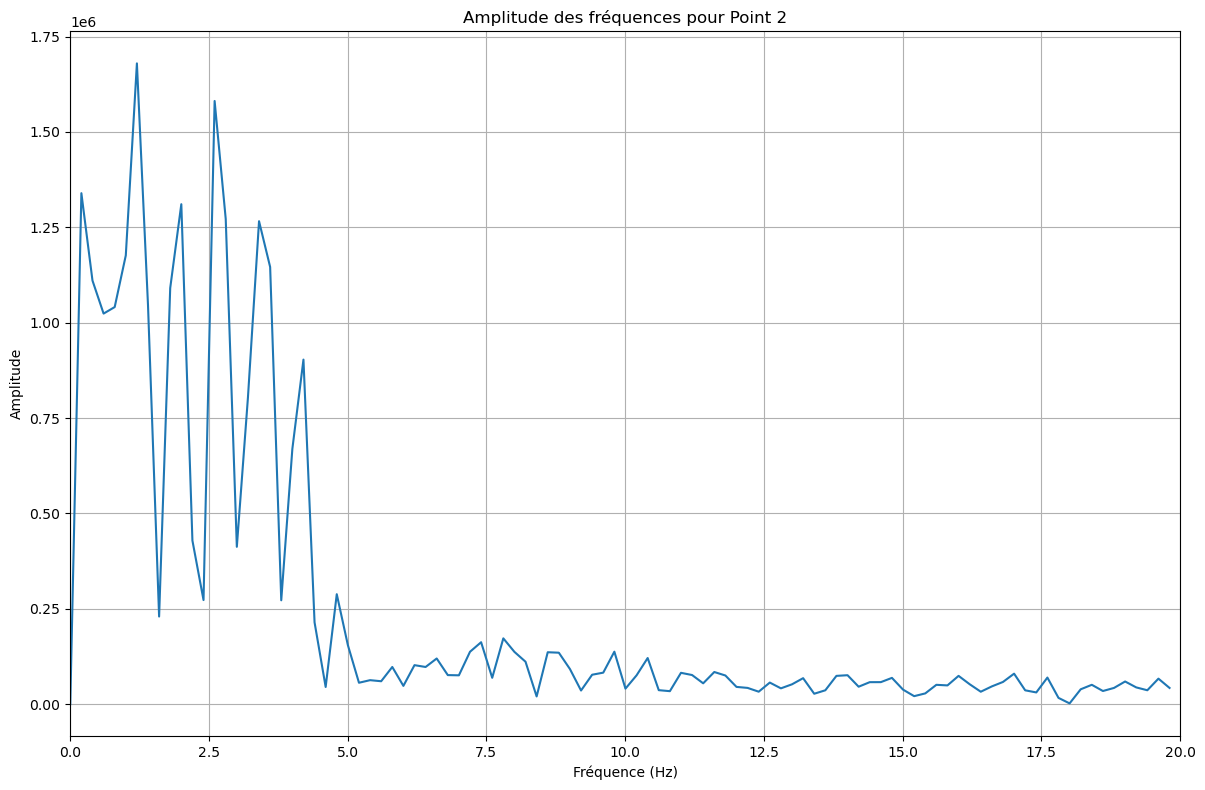

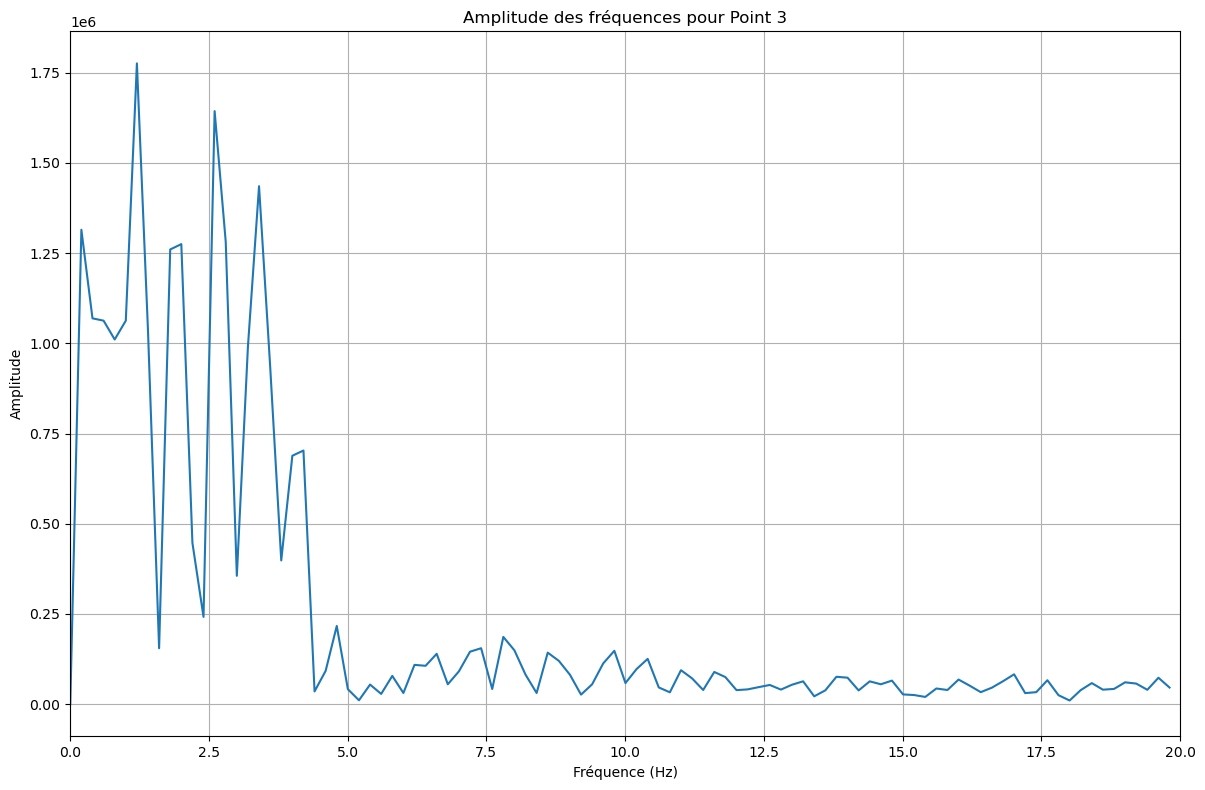

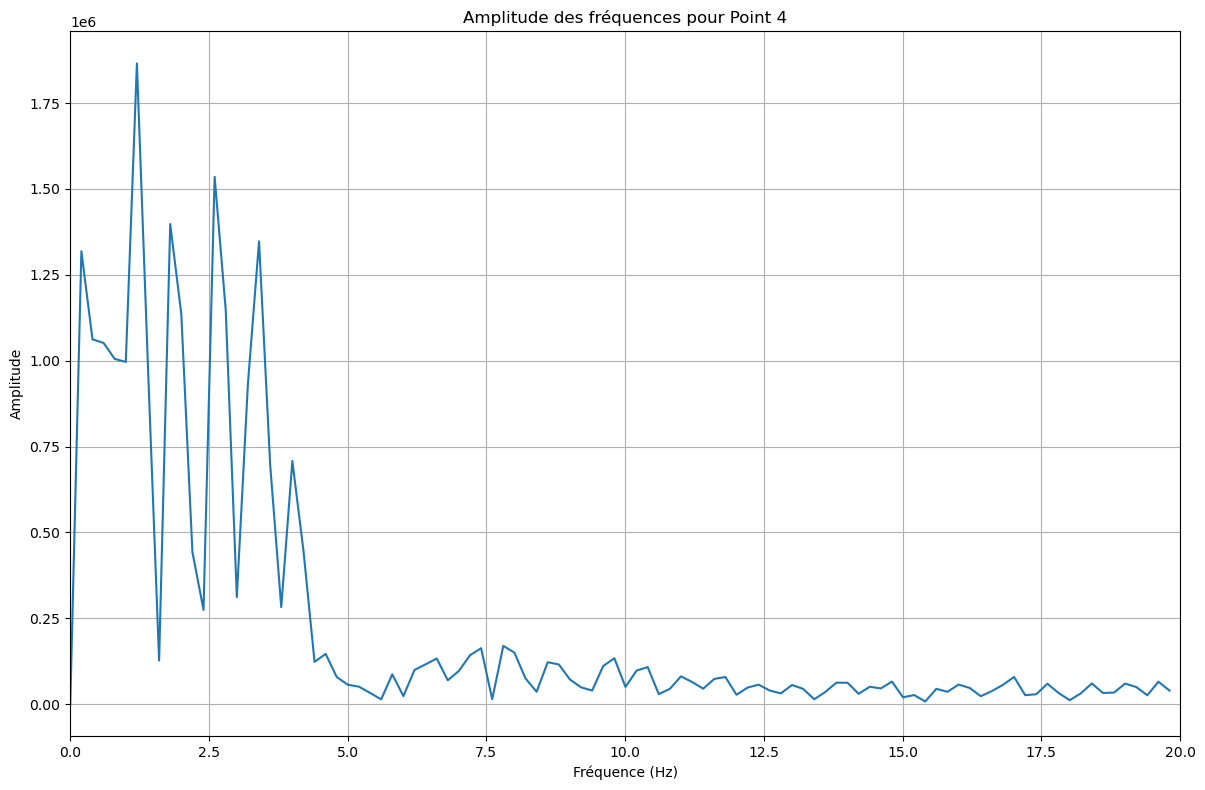

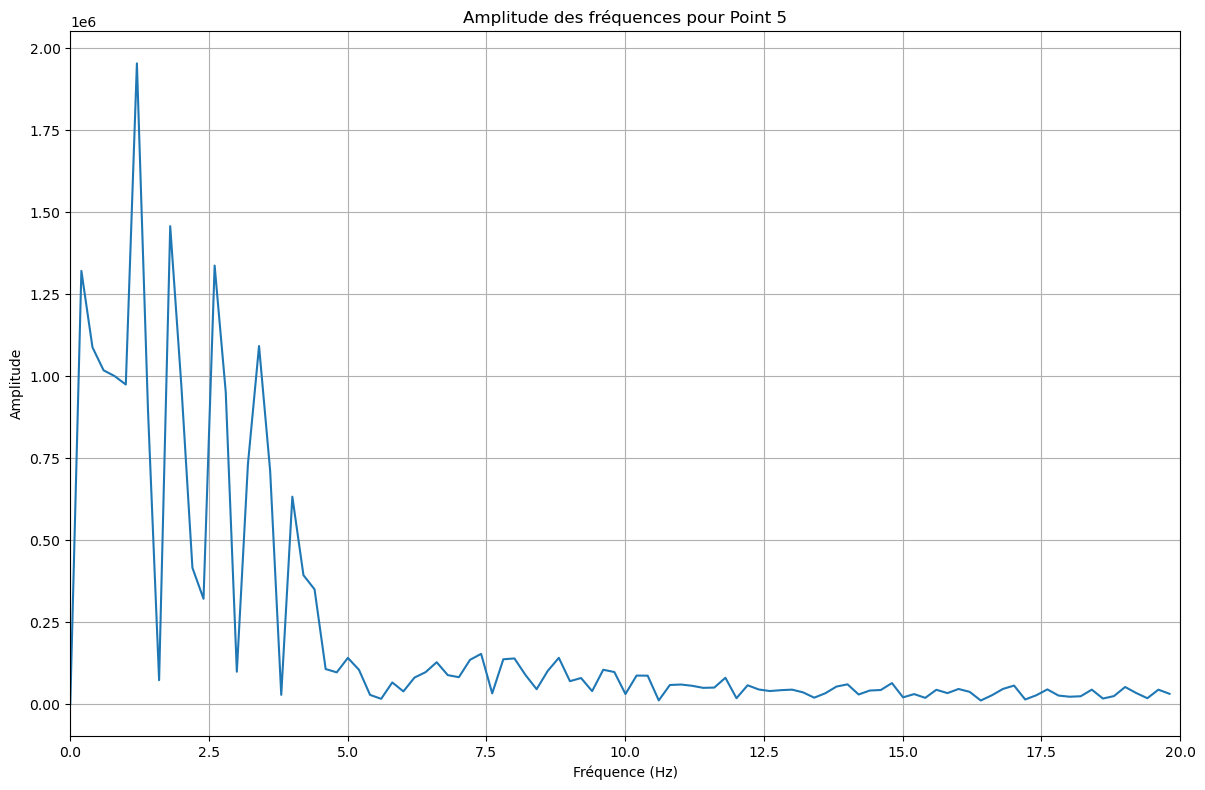

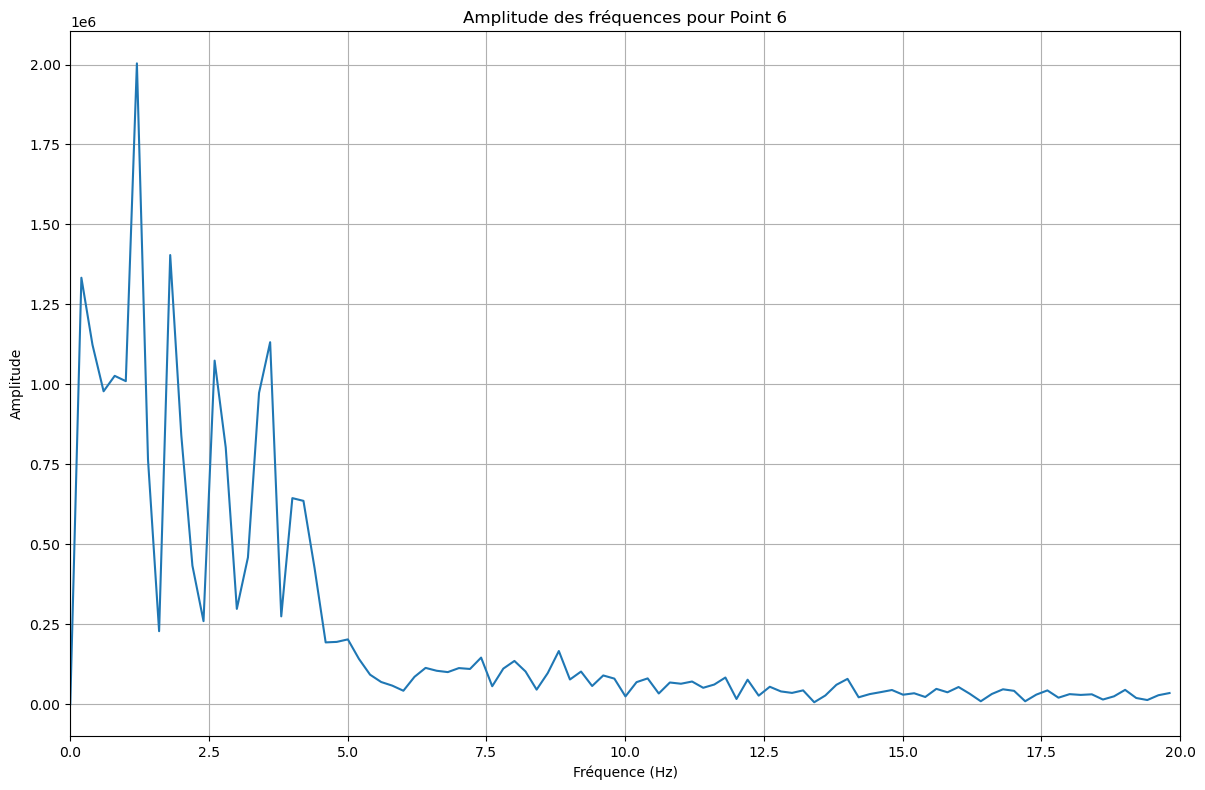

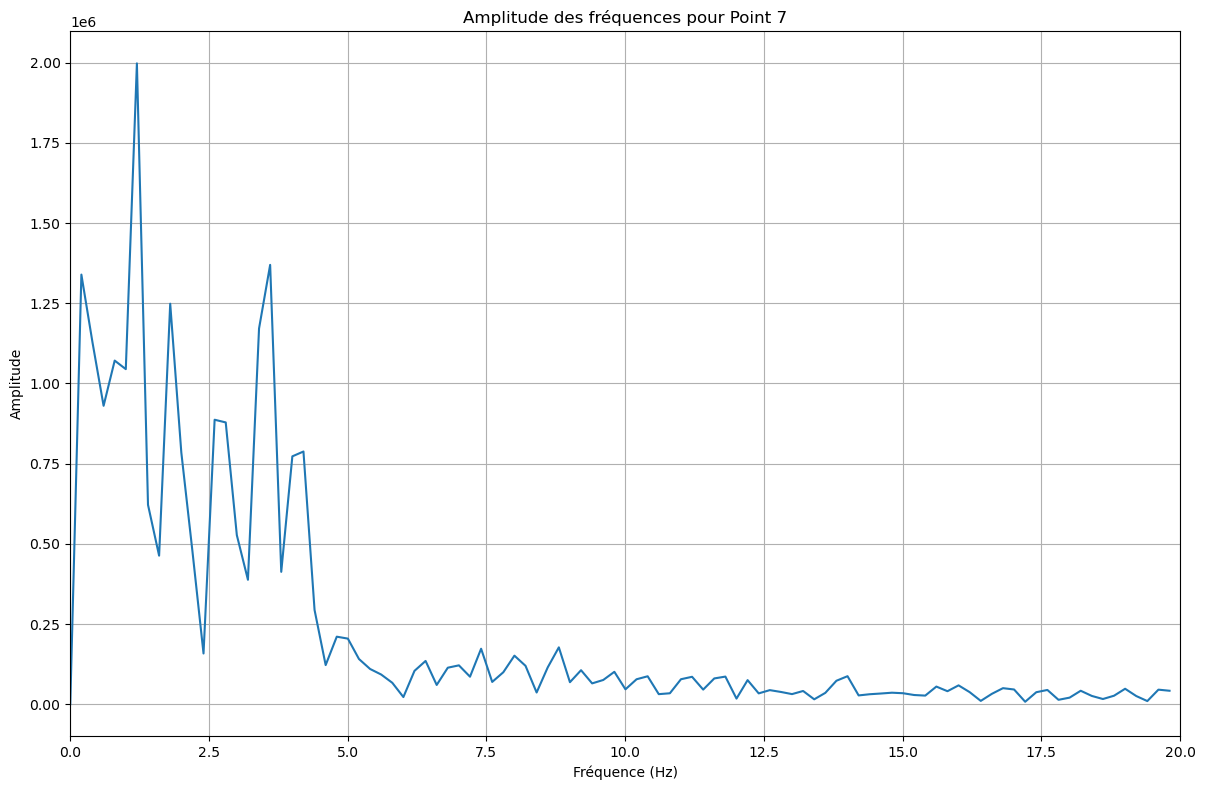

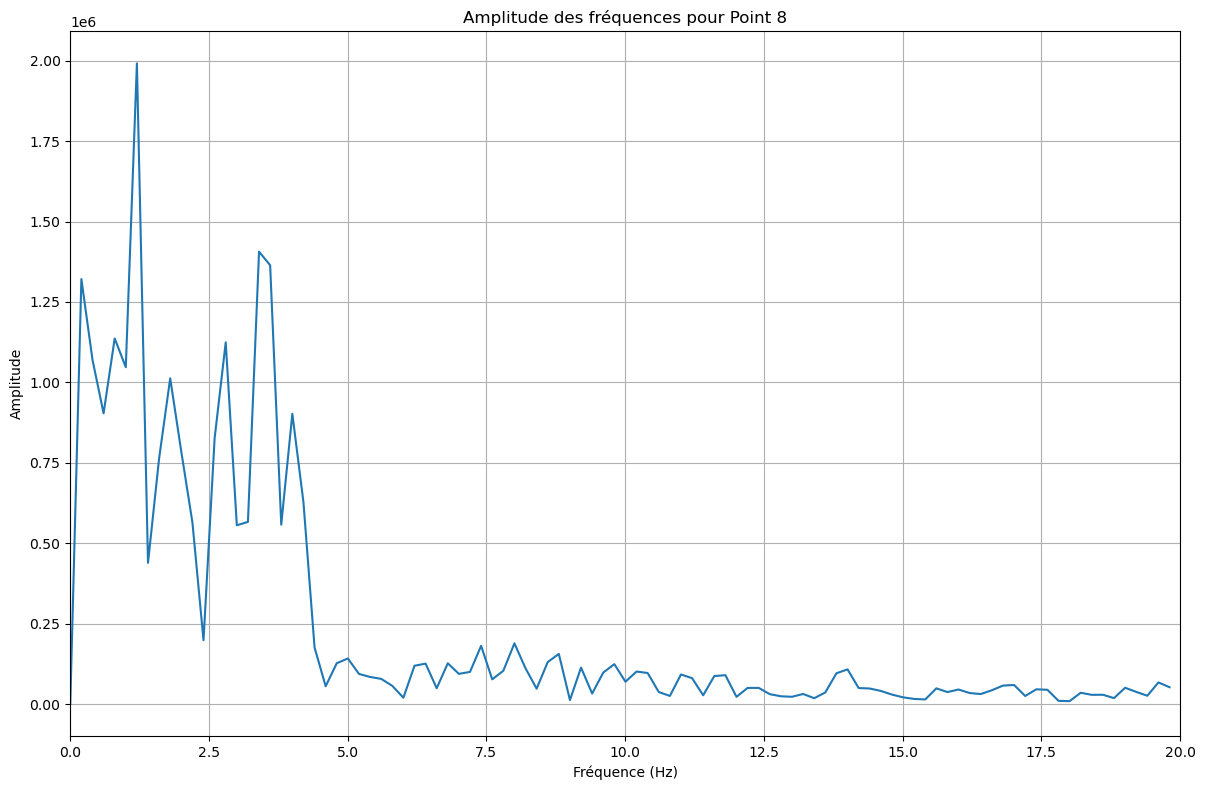

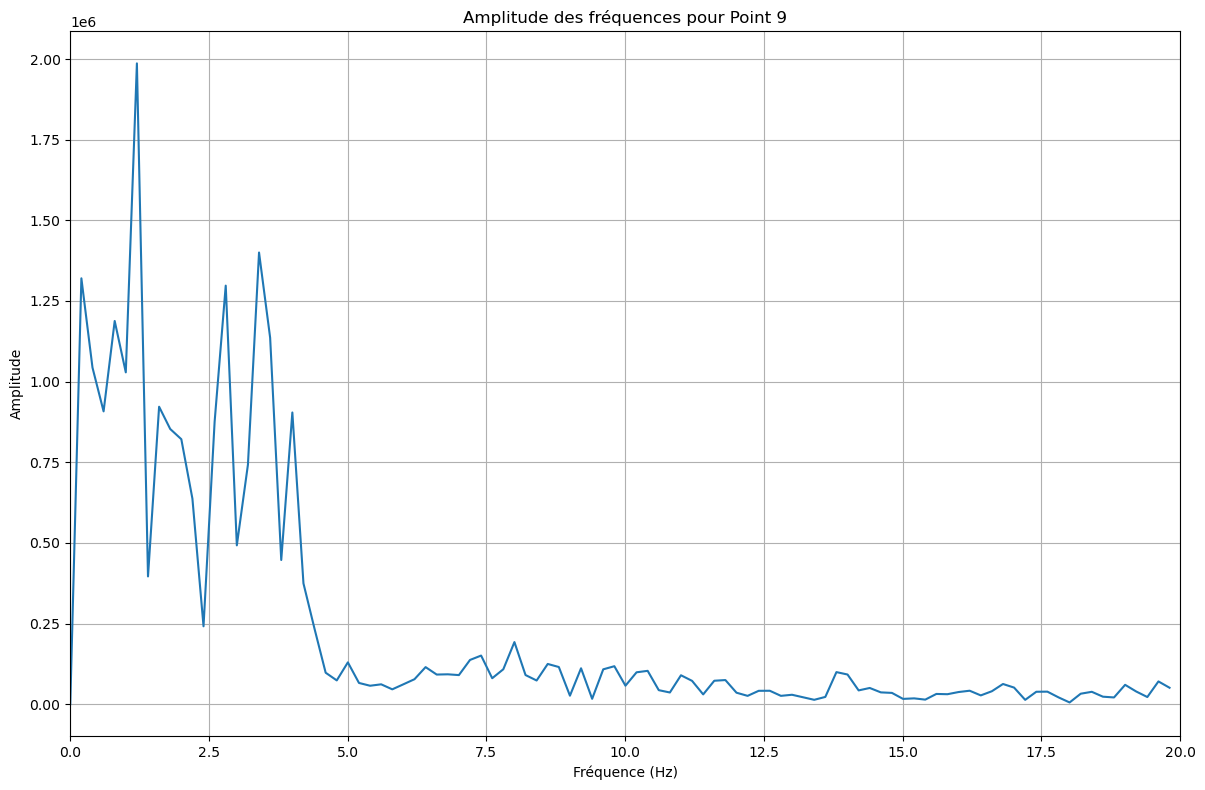

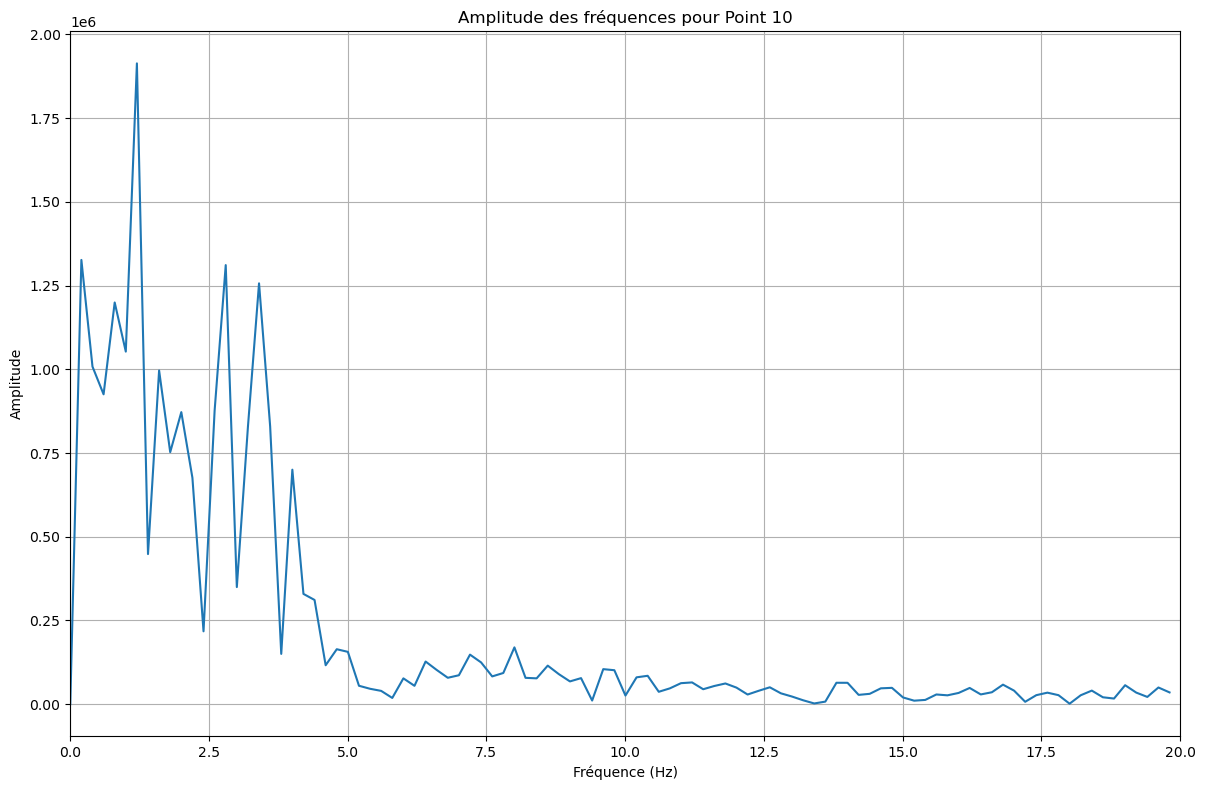

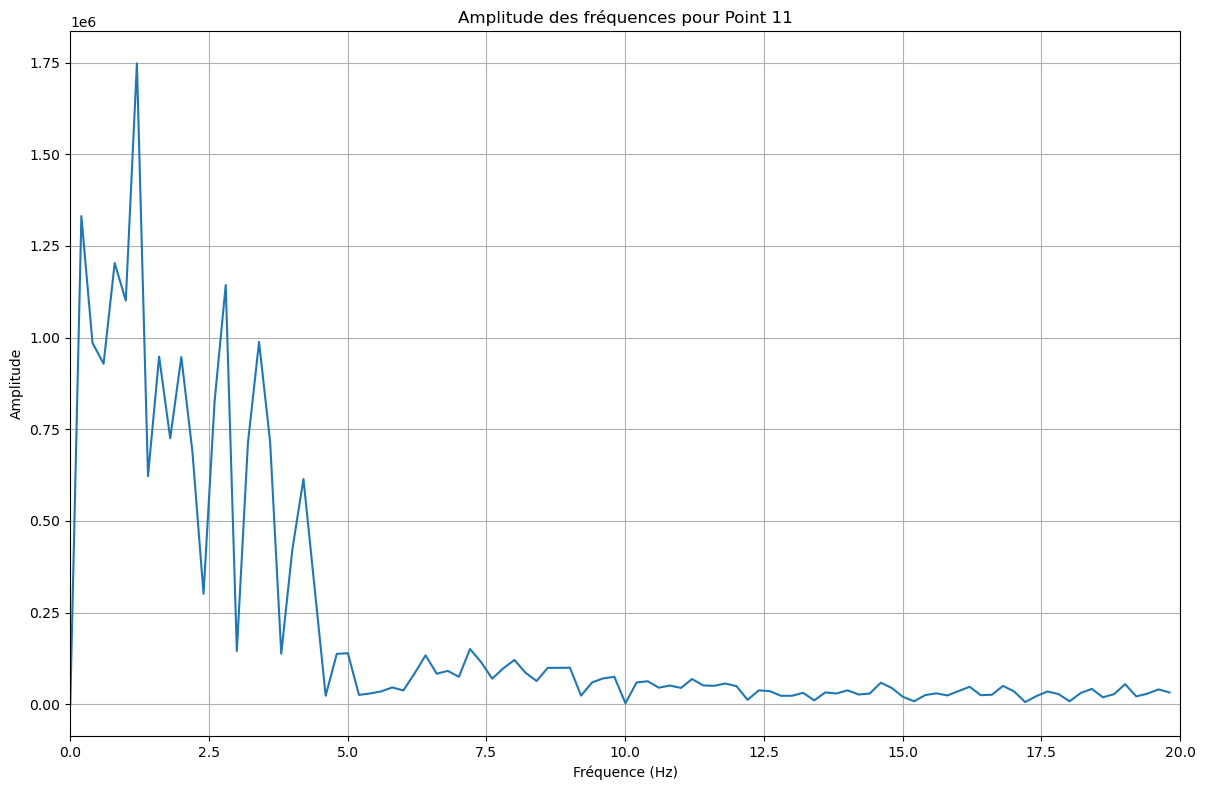

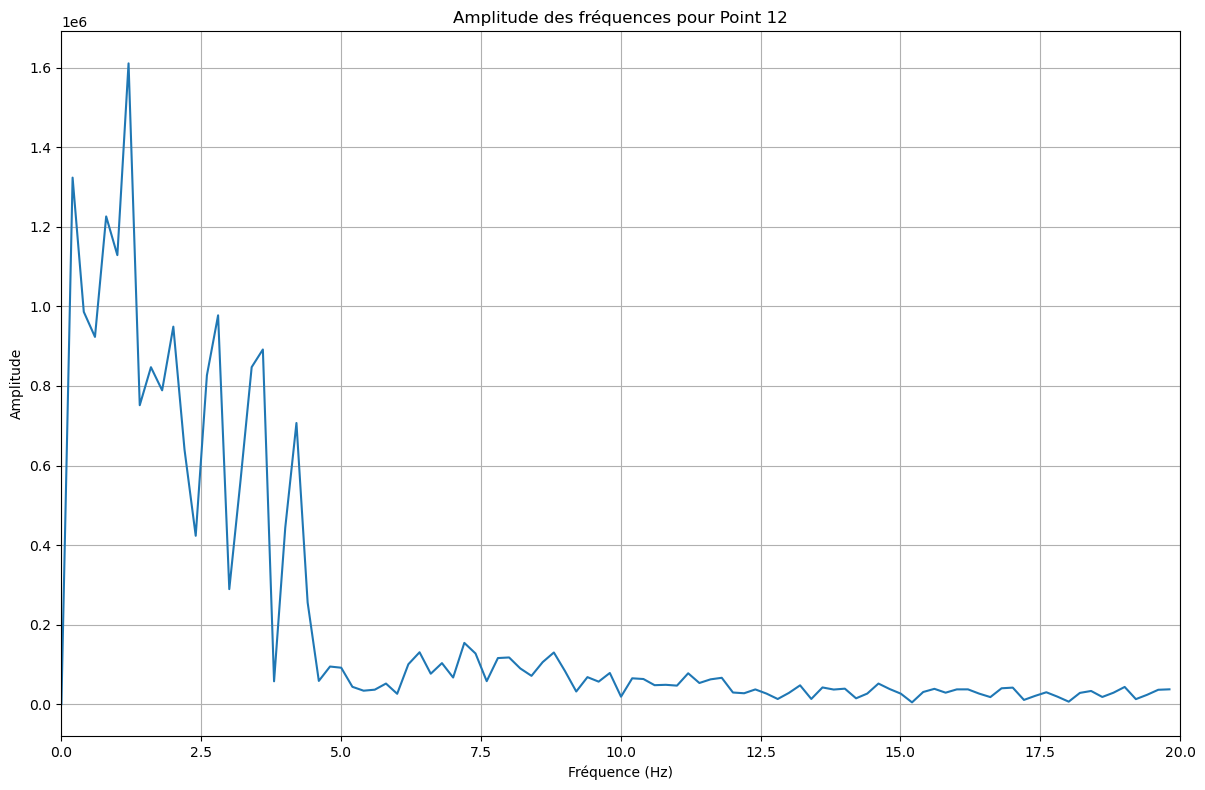

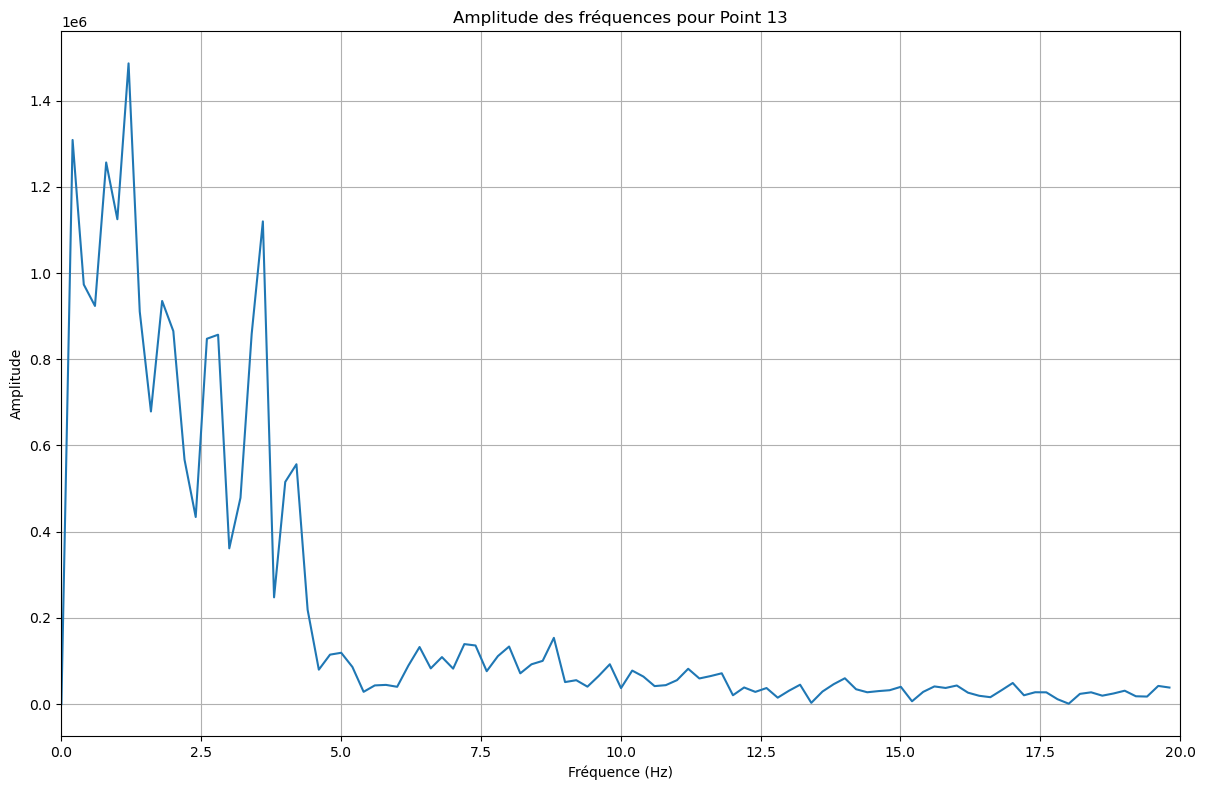

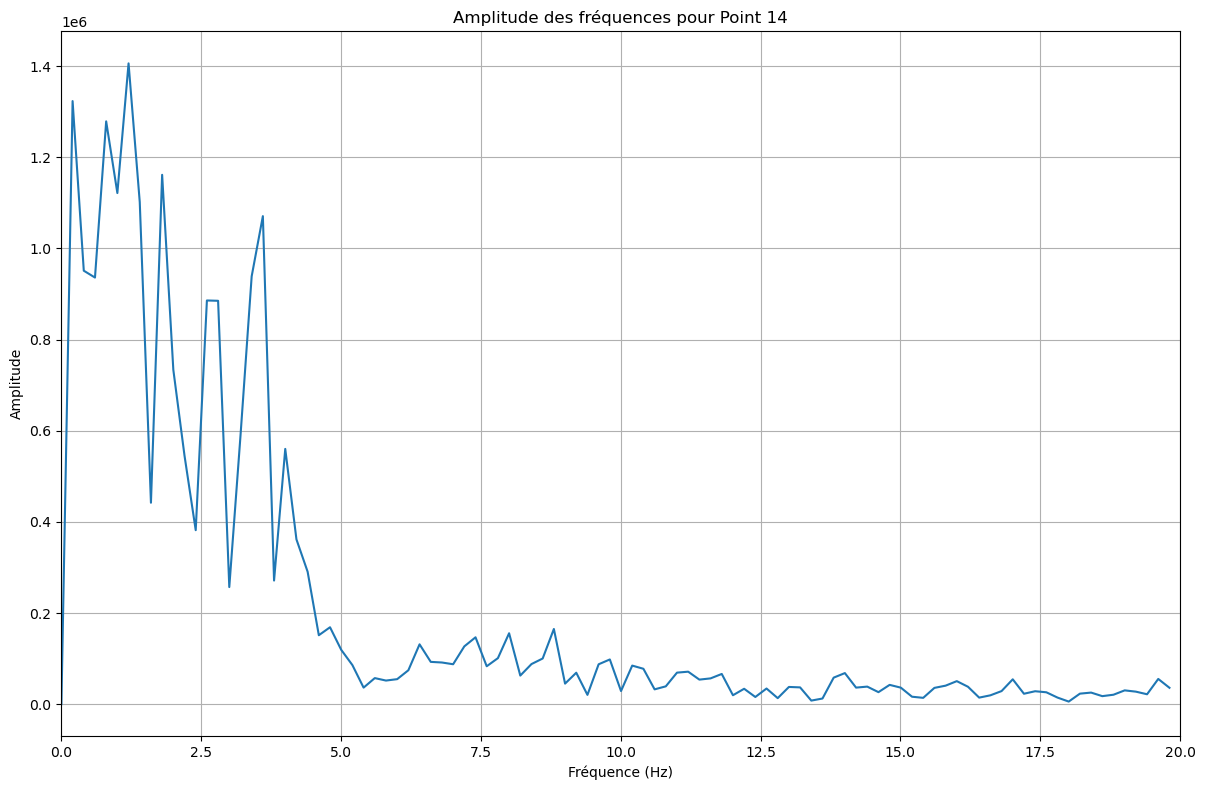

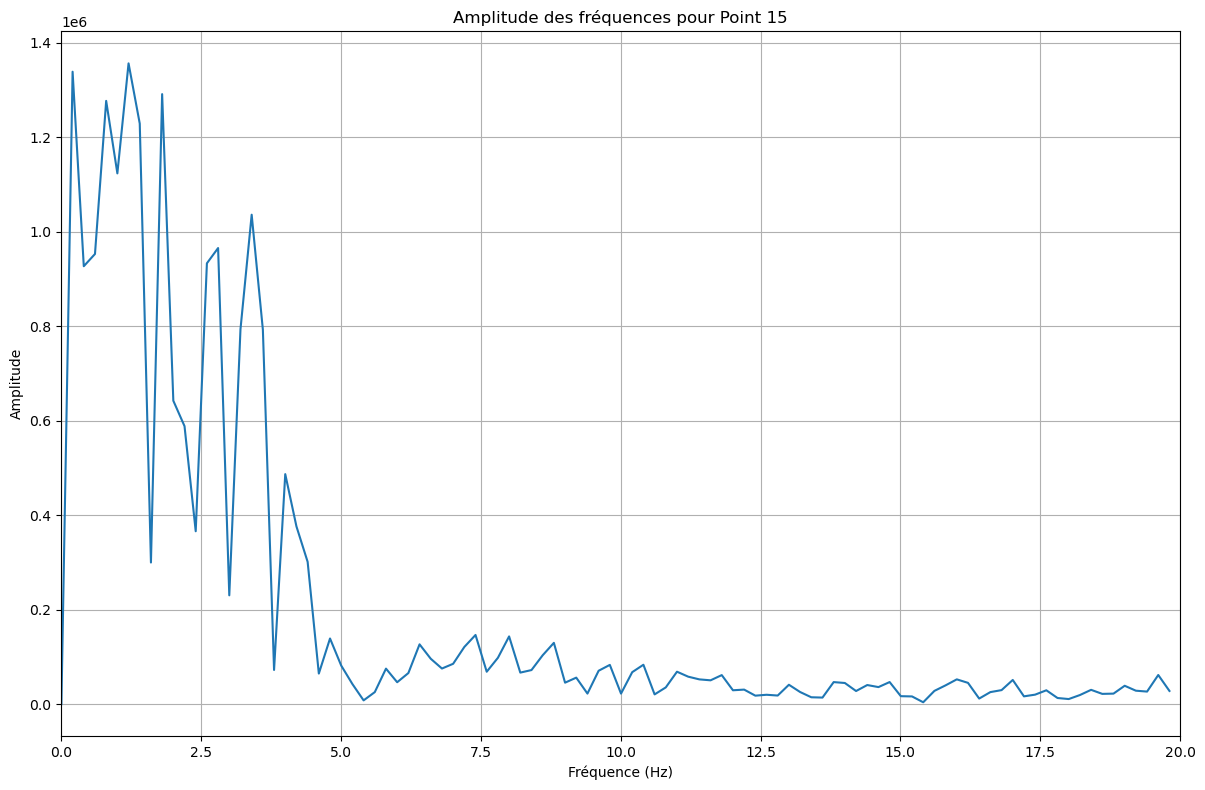

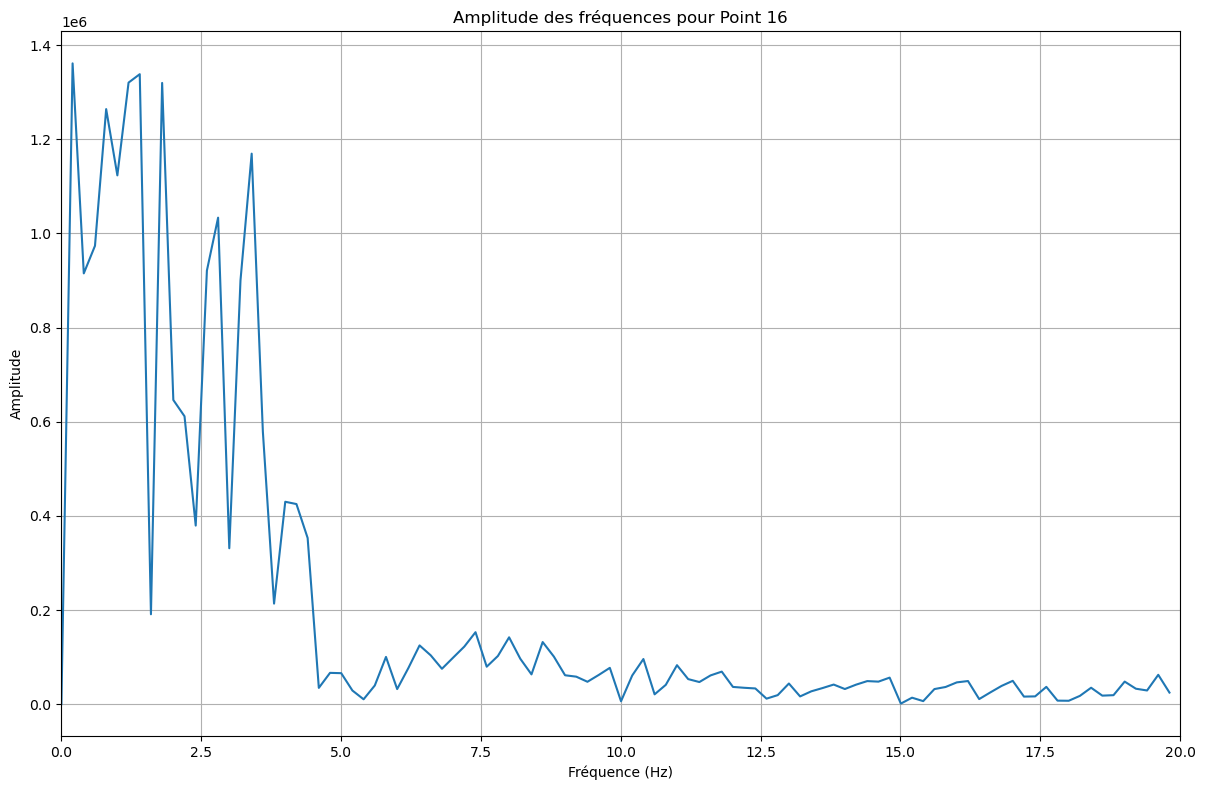

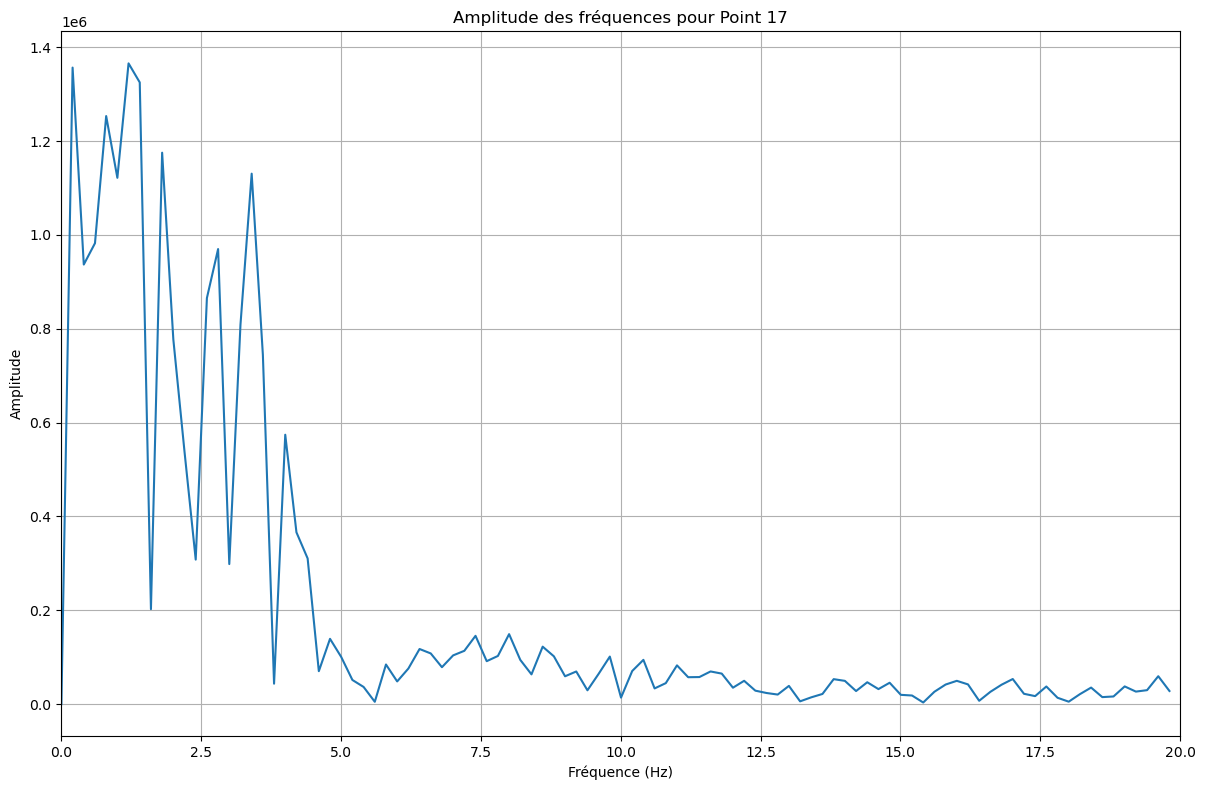

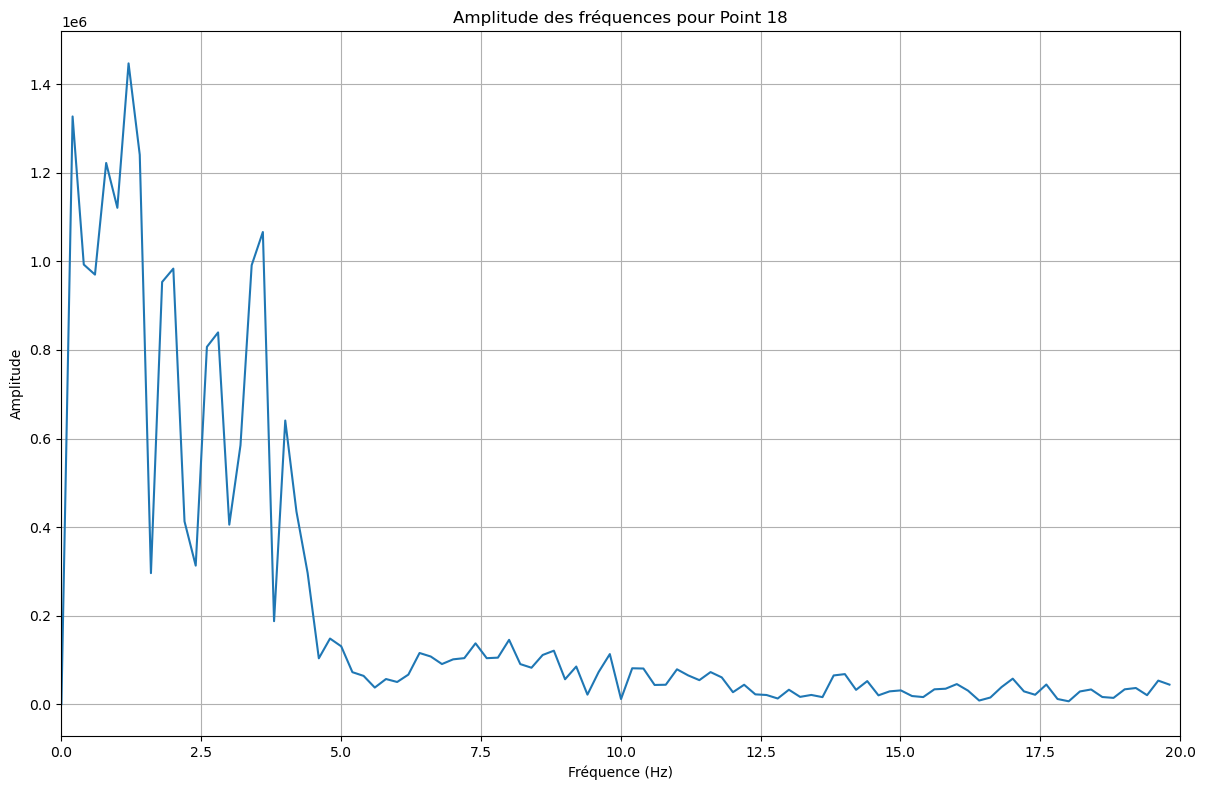

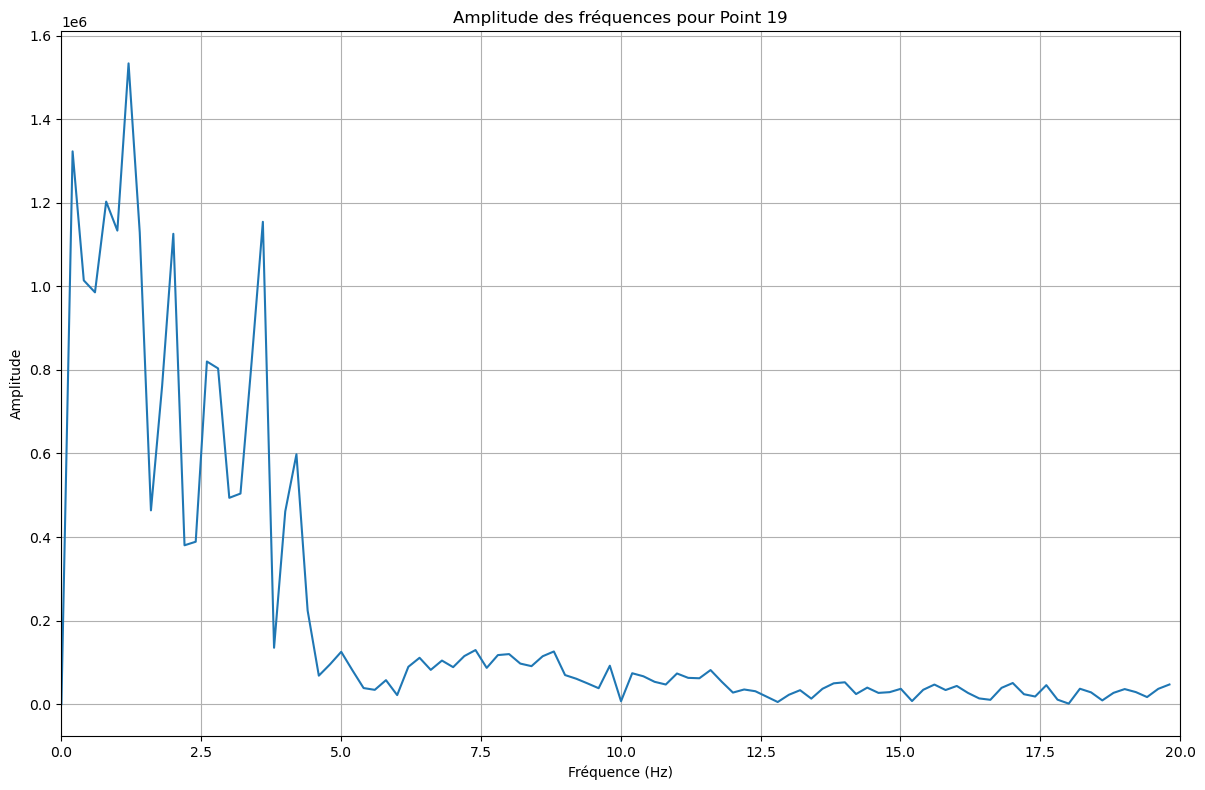

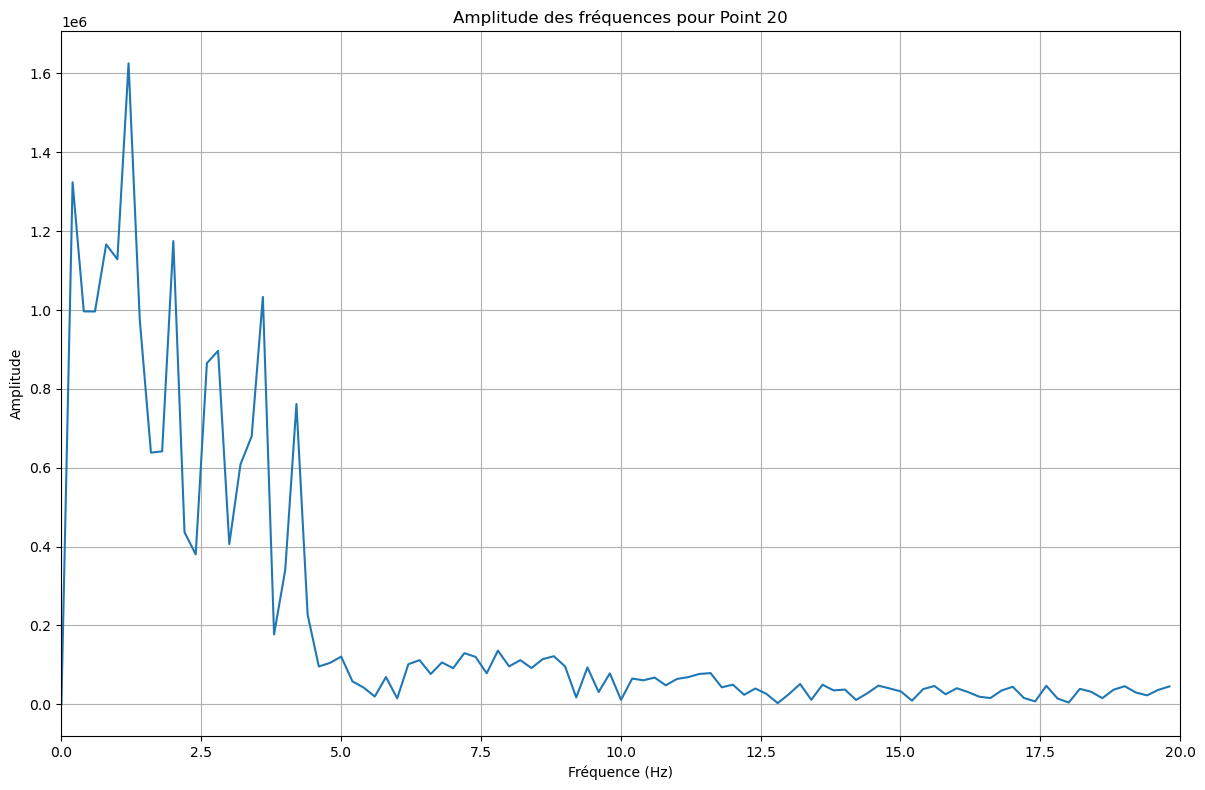

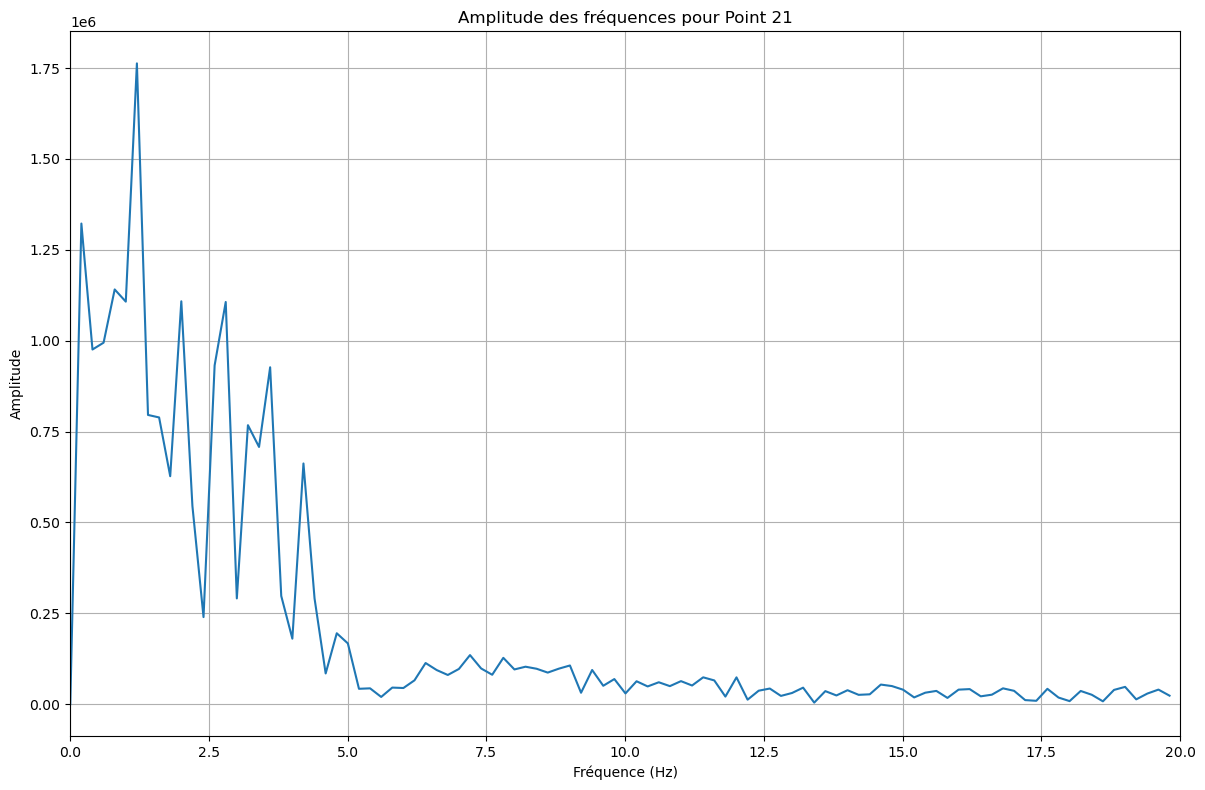

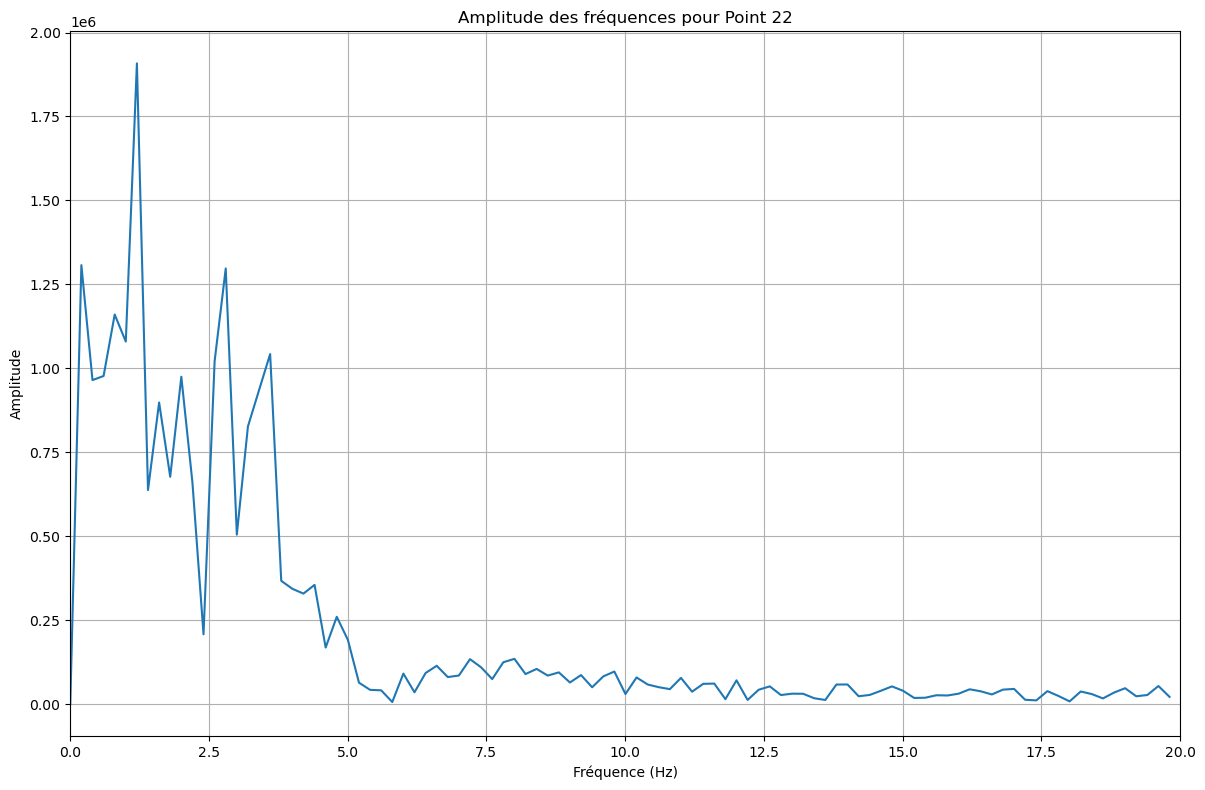

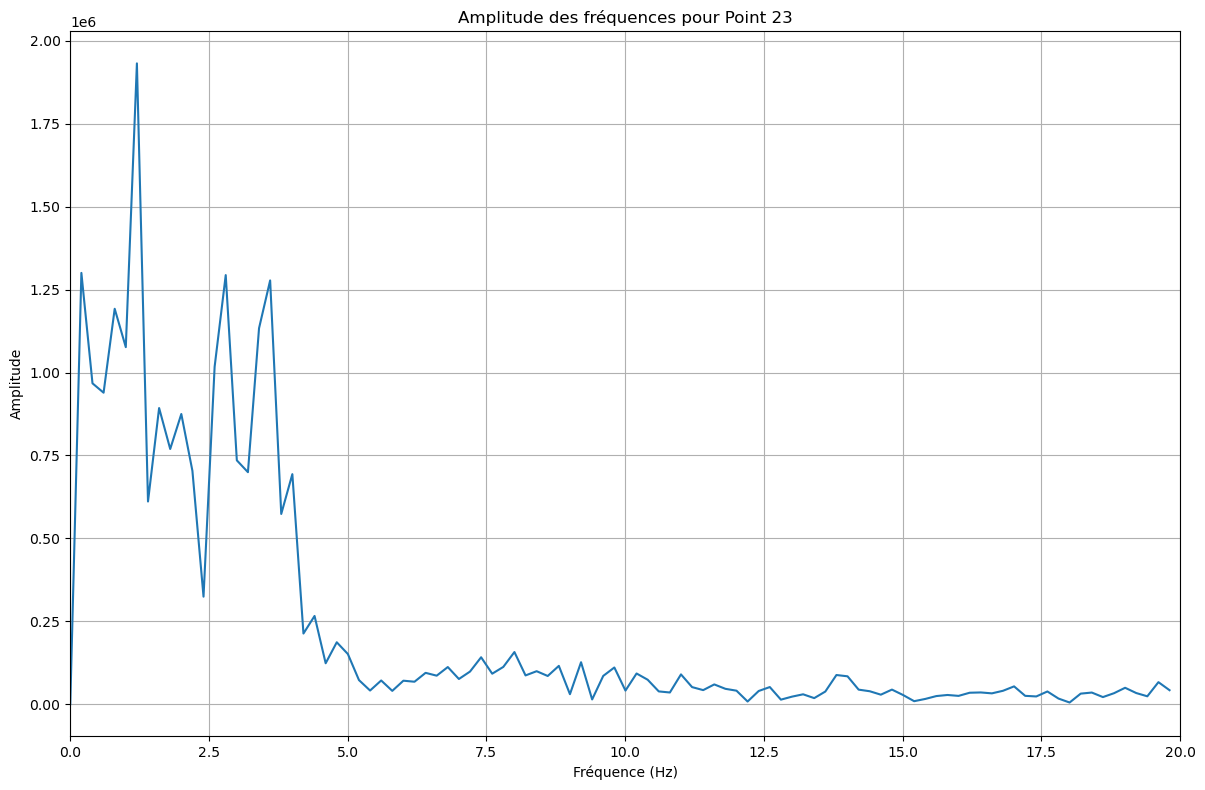

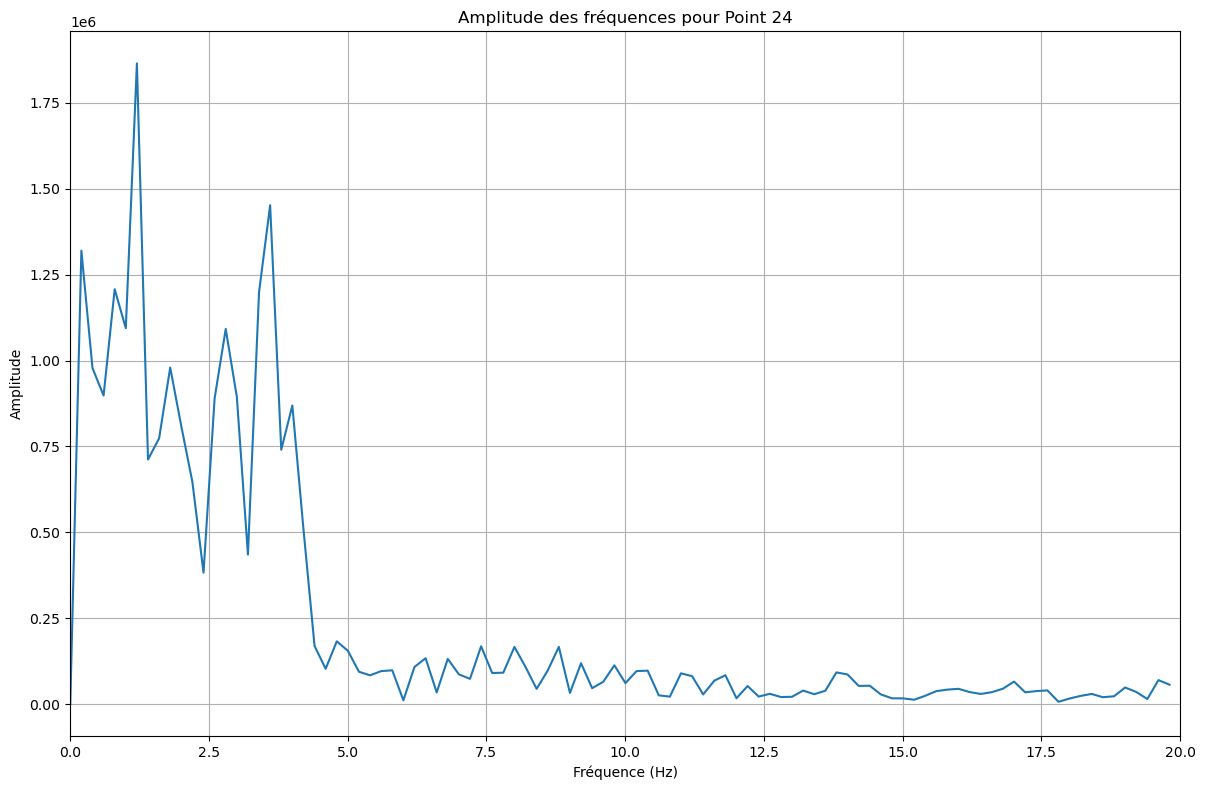

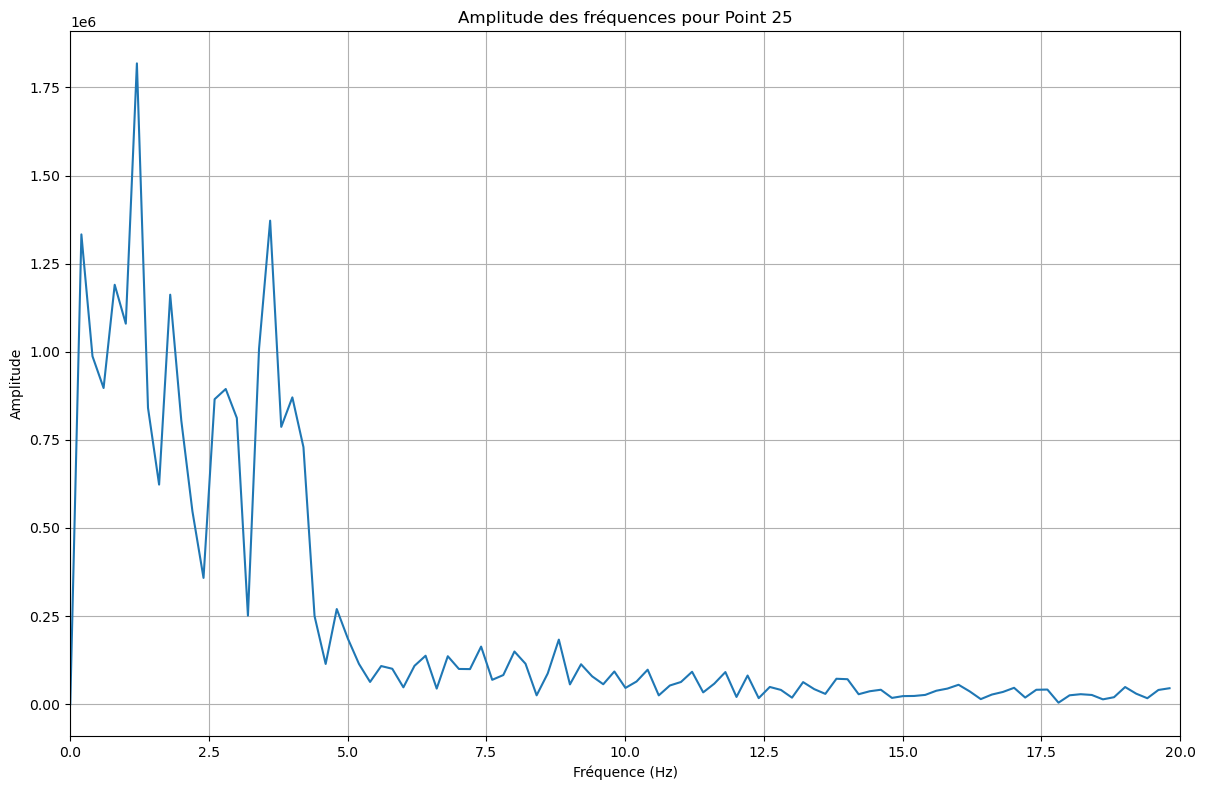

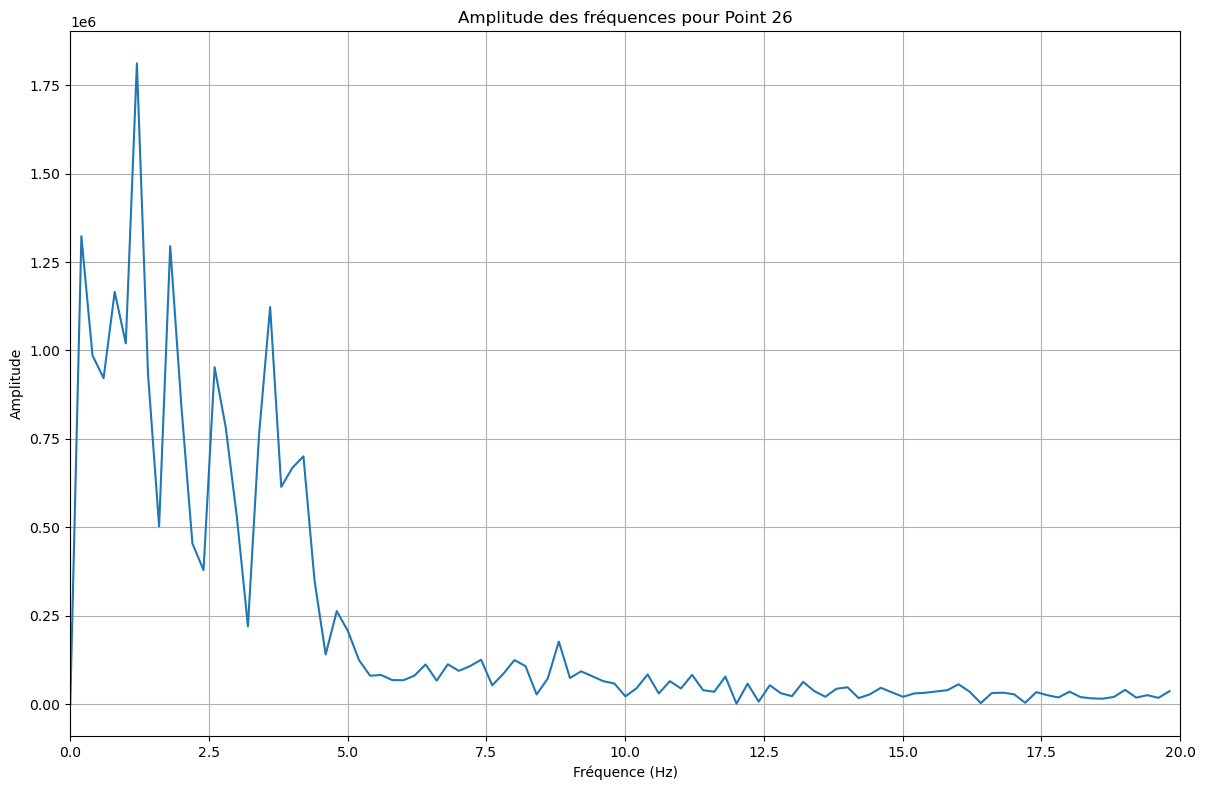

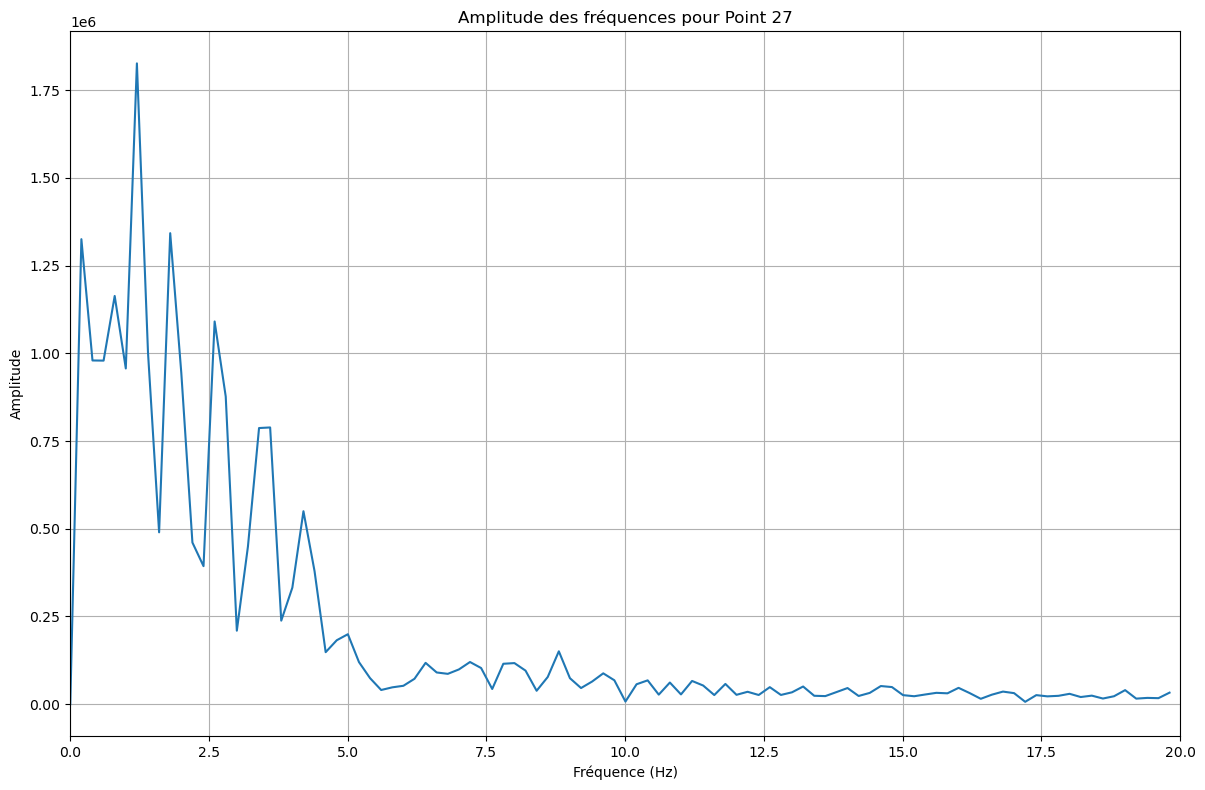

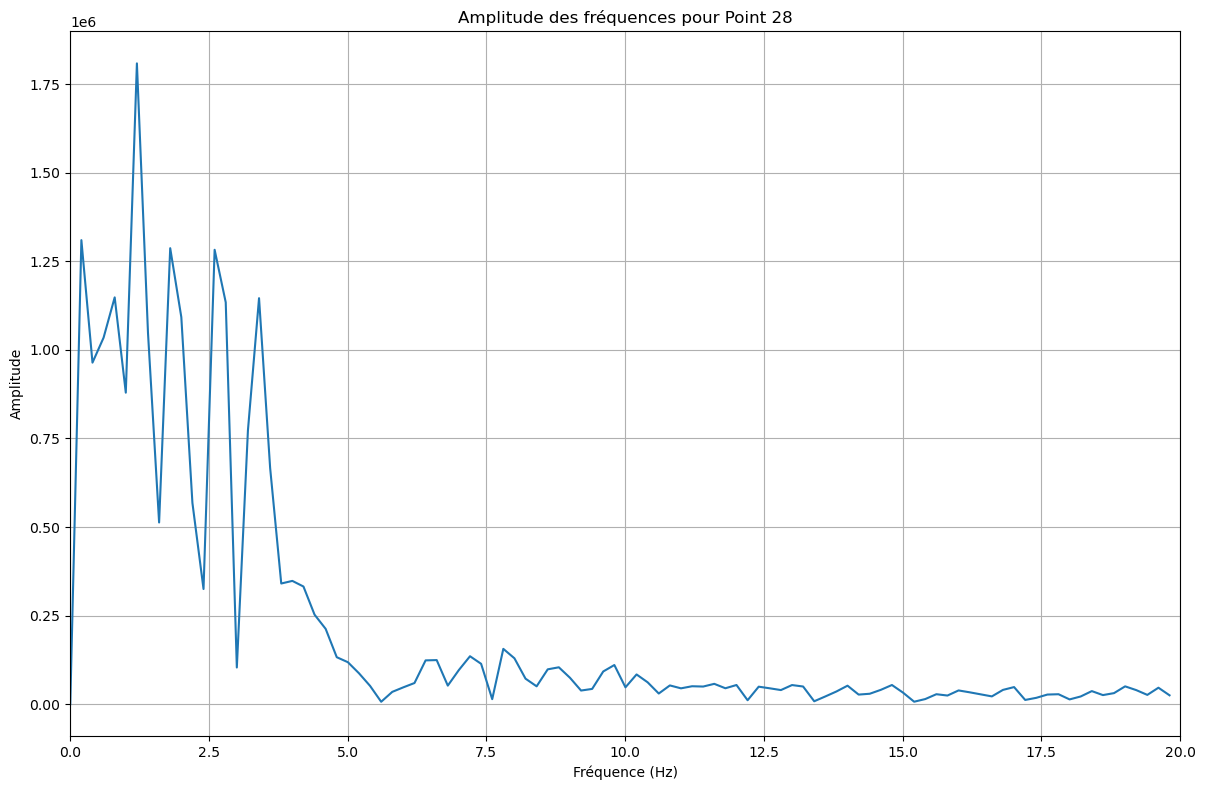

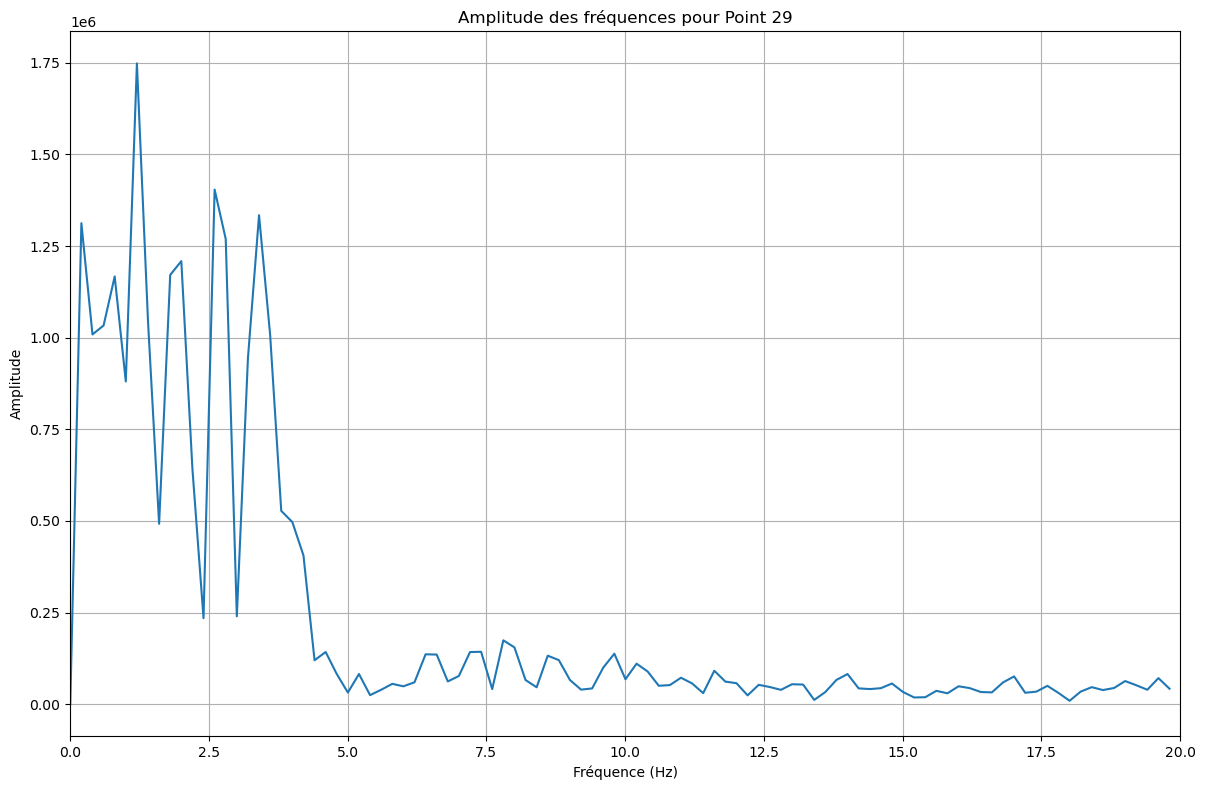

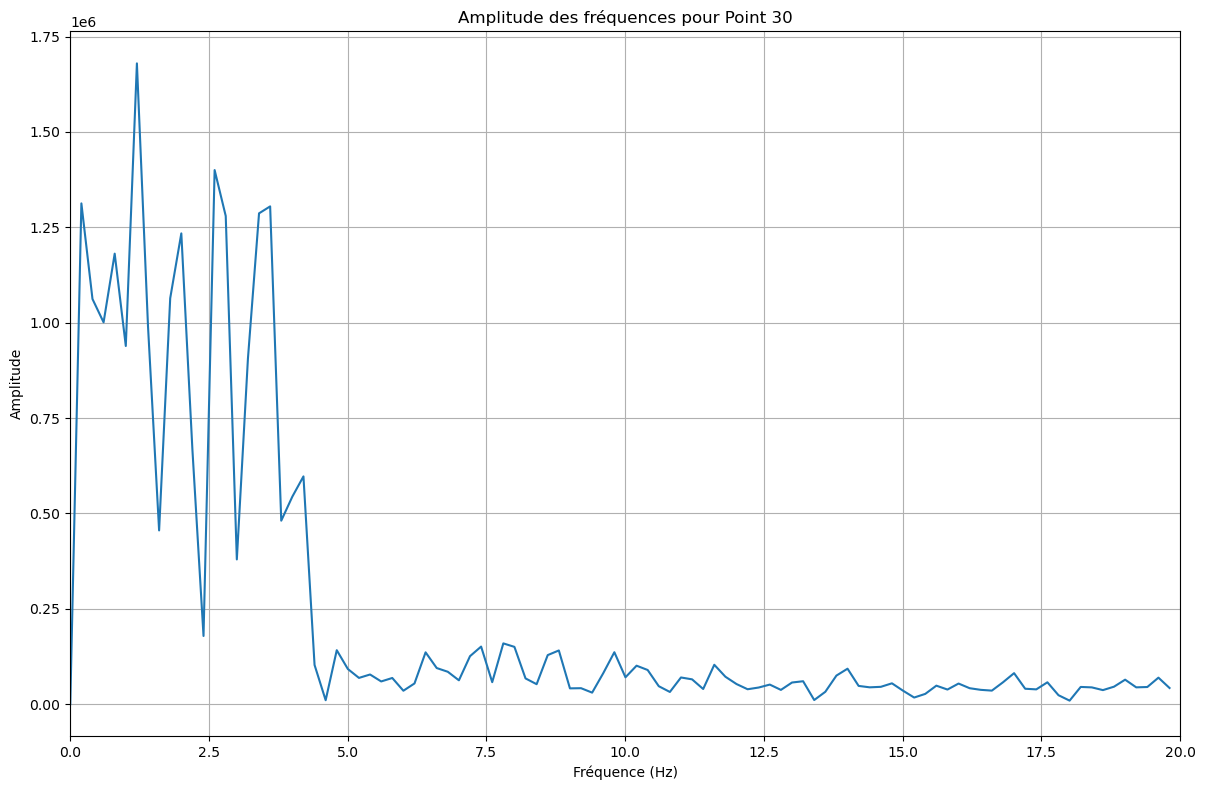

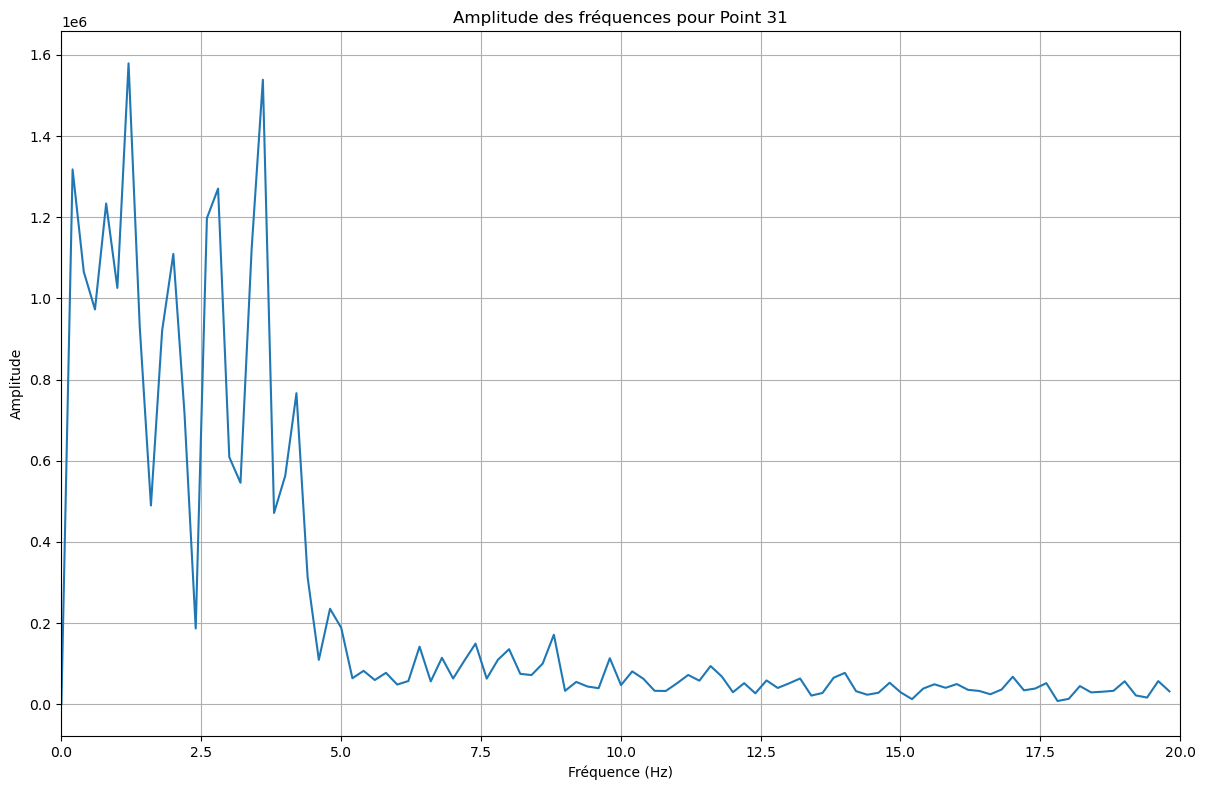

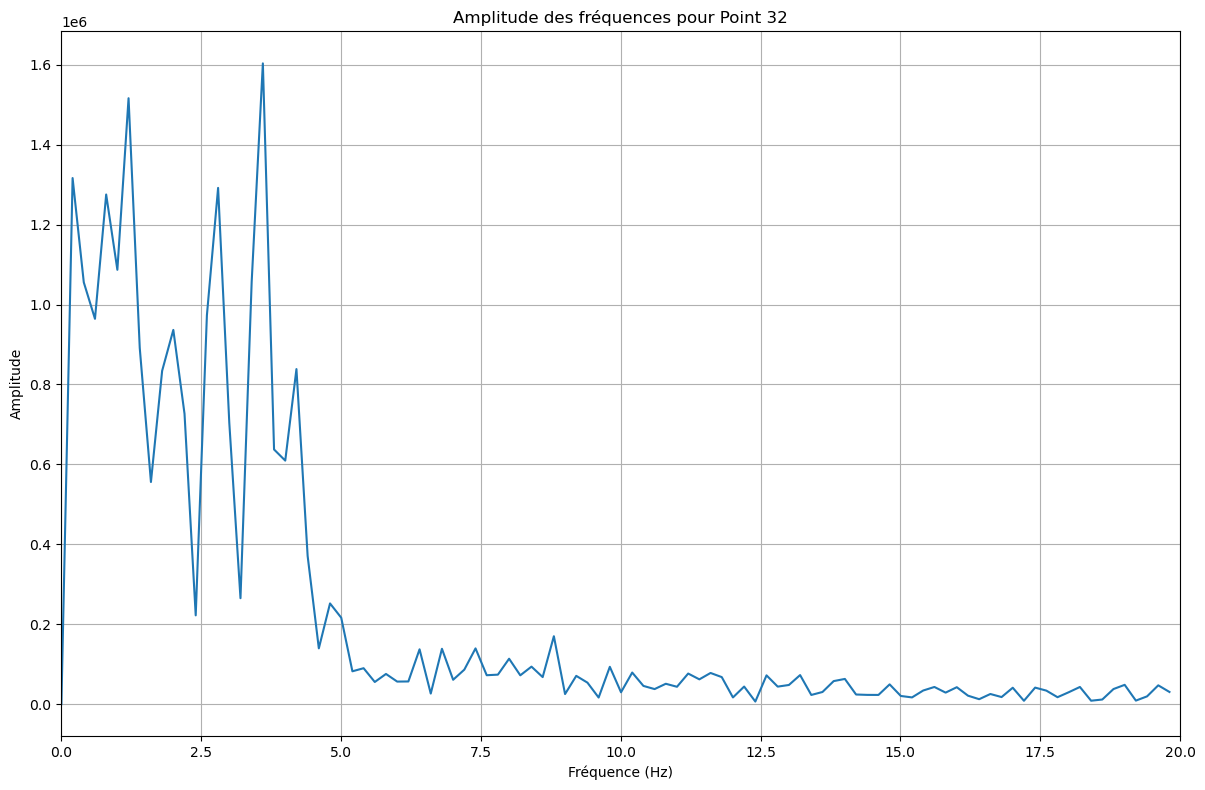

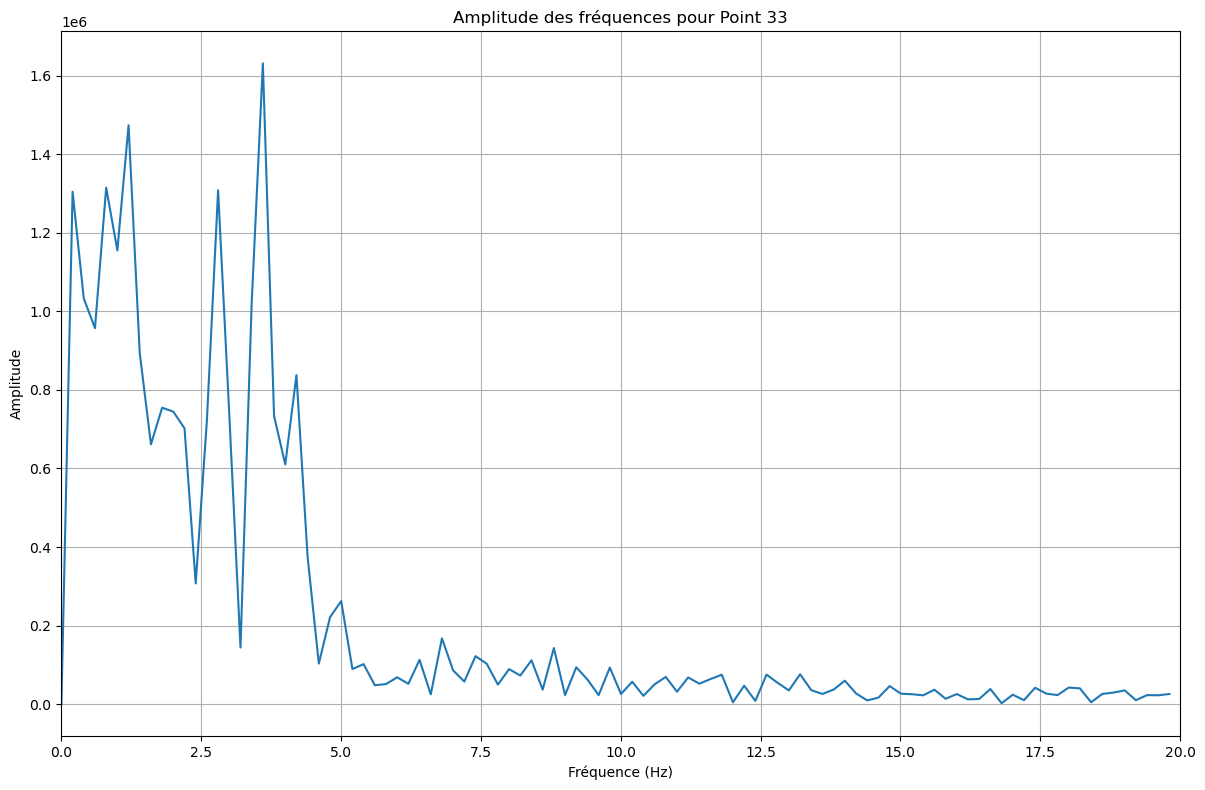

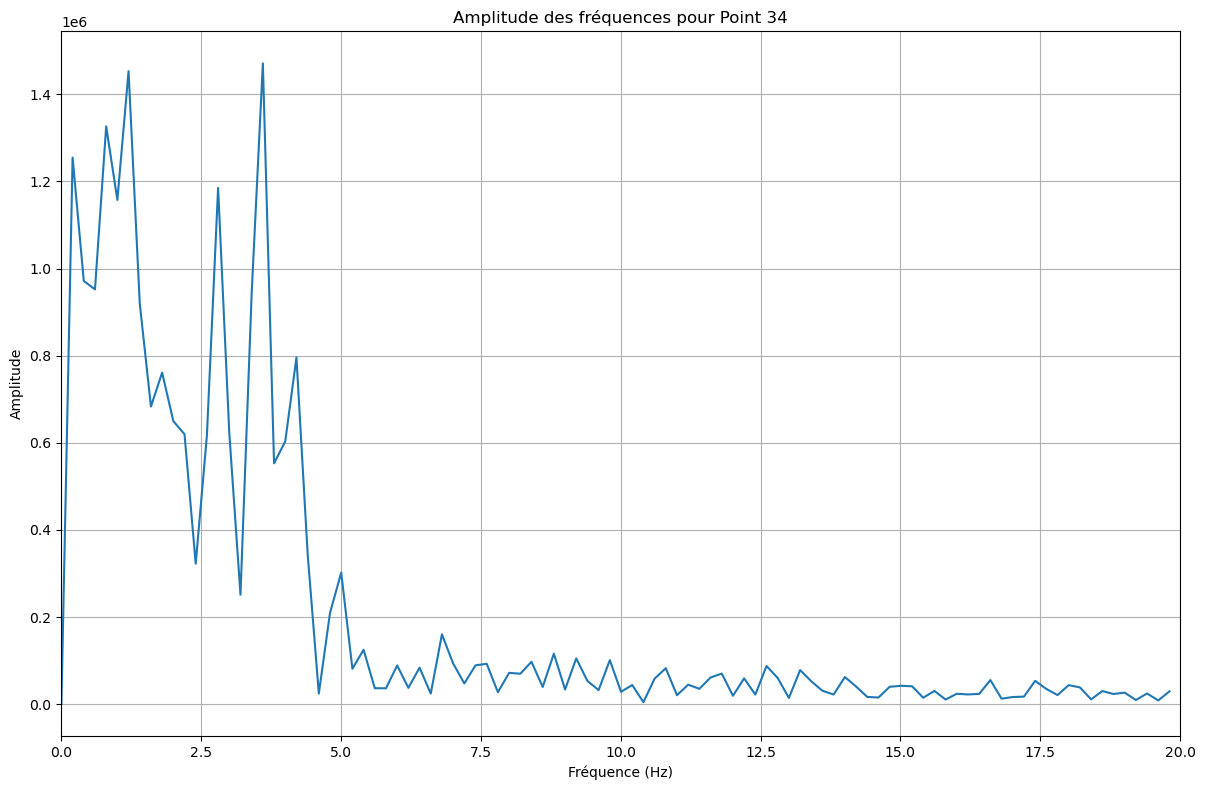

In [225]:
visualiser_matrice_fft_par_pointZOOM(fft_df)


In [226]:

from scipy.fft import fft, fftfreq
def decompose_signal(signal, echantillonnage):
    n = len(signal)
    freqs = fftfreq(n, d=echantillonnage)
    fft_vals = fft(signal)
    
    # Extraire les composantes sinusoïdales
    composantes = []
    for i, coef in enumerate(fft_vals):
        amplitude = np.abs(coef) / n
        phase = np.angle(coef)
        frequence = freqs[i]
        
        if frequence >= 0:
            composantes.append((amplitude, frequence, phase))
    
    return composantes

def visualiser_composantes(composantes, temps, signal):
    plt.figure(figsize=(14, 7))
    plt.plot(temps, signal, label='Signal original')
    
    signal_reconstruit = np.zeros_like(signal)
    for amplitude, frequence, phase in composantes:
        signal_sin = amplitude * np.sin(2 * np.pi * frequence * temps + phase)
        plt.plot(temps, signal_sin, linestyle='--', label=f'{frequence:.2f} Hz')
        signal_reconstruit += signal_sin
    
    plt.plot(temps, signal_reconstruit, linestyle=':', linewidth=2, label='Signal reconstruit')
    plt.xlabel('Temps')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper right')
    plt.show()


In [227]:
top_frequencies_df = detecter_top_frequences(fft_df)
top_frequencies_df


Point 1_Top_5_Freqs  Point 1_Top_5_Amplitudes  Point 2_Top_5_Freqs  \
0             1.200692              1.525447e+06             1.200692   
1             3.602075              1.501991e+06             2.601498   
2             0.200115              1.383877e+06             0.200115   
3             1.000576              1.295969e+06             2.001153   
4             2.601498              1.262163e+06             2.801614   

   Point 2_Top_5_Amplitudes  Point 3_Top_5_Freqs  Point 3_Top_5_Amplitudes  \
0              1.679697e+06             1.200692              1.775912e+06   
1              1.581117e+06             2.601498              1.643621e+06   
2              1.339443e+06             3.401960              1.435522e+06   
3              1.310554e+06             0.200115              1.314849e+06   
4              1.271824e+06             2.801614              1.281418e+06   

   Point 4_Top_5_Freqs  Point 4_Top_5_Amplitudes  Point 5_Top_5_Freqs  \
0             1.200692              1.865418e+06             1.200692   
1             2.601498              1.535185e+06             1.801037   
2             1.801037              1.397790e+06             2.601498   
3             3.401960              1.347308e+06             0.200115   
4             0.200115              1.318406e+06             3.401960   

   Point 5_Top_5_Amplitudes  ...  Point 30_Top_5_Freqs  \
0              1.953676e+06  ...              1.200692   
1              1.457284e+06  ...              2.601498   
2              1.337277e+06  ...              0.200115   
3              1.320981e+06  ...              3.602075   
4              1.091977e+06  ...              3.401960   

   Point 30_Top_5_Amplitudes  Point 31_Top_5_Freqs  Point 31_Top_5_Amplitudes  \
0               1.679685e+06              1.200692               1.579033e+06   
1               1.400000e+06              3.602075               1.538701e+06   
2               1.312682e+06              0.200115               1.317735e+06   
3               1.304813e+06              2.801614               1.270532e+06   
4               1.286601e+06              0.800461               1.233718e+06   

   Point 32_Top_5_Freqs  Point 32_Top_5_Amplitudes  Point 33_Top_5_Freqs  \
0              3.602075               1.603335e+06              3.602075   
1              1.200692               1.516155e+06              1.200692   
2              0.200115               1.316412e+06              0.800461   
3              2.801614               1.291768e+06              2.801614   
4              0.800461               1.275246e+06              0.200115   

   Point 33_Top_5_Amplitudes  Point 34_Top_5_Freqs  Point 34_Top_5_Amplitudes  
0               1.631112e+06              3.602075               1.470826e+06  
1               1.473591e+06              1.200692               1.452933e+06  
2               1.314611e+06              0.800461               1.326168e+06  
3               1.308029e+06              0.200115               1.254592e+06  
4               1.304432e+06              2.801614               1.184901e+06  

[5 rows x 68 columns]

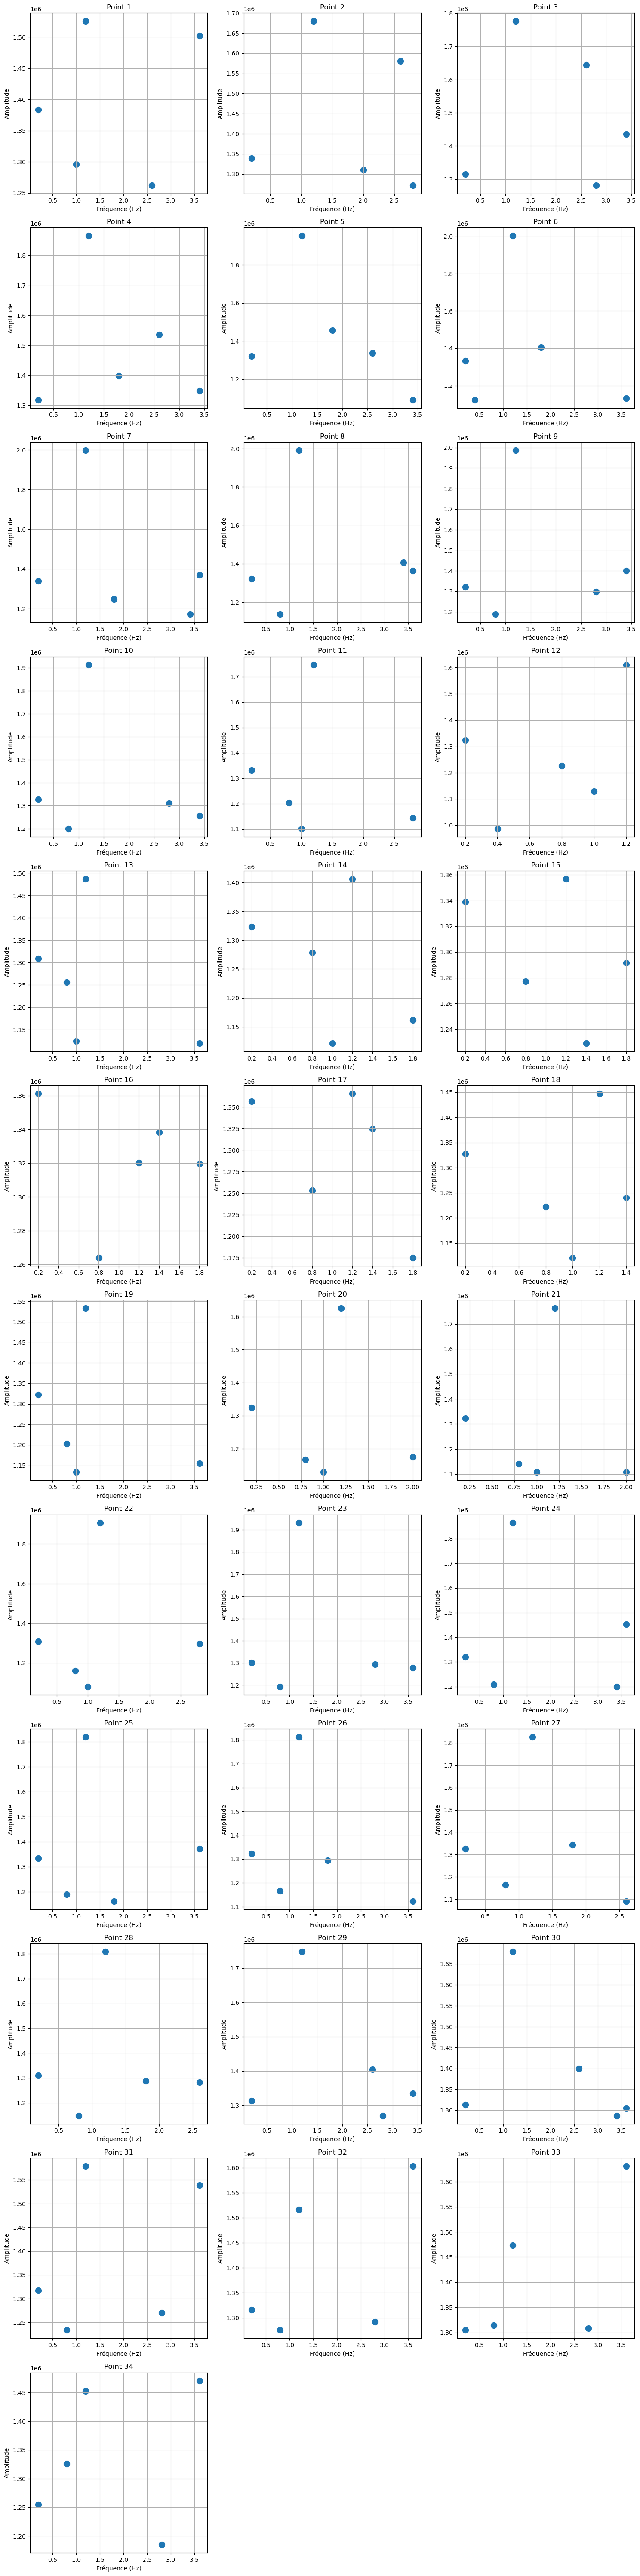

In [228]:
tracer_top_frequences(top_frequencies_df)


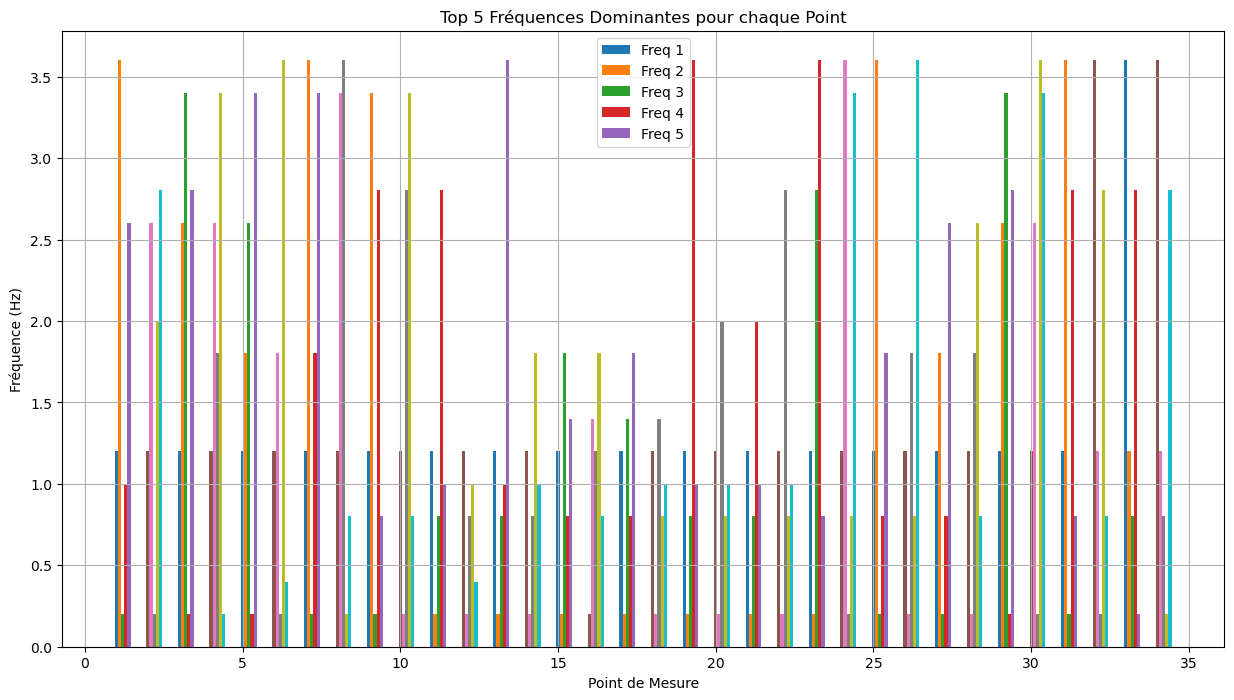

In [229]:
def tracer_top_frequences_bars(top_frequencies_df, top_n=5):
    num_points = top_frequencies_df.shape[1] // 2
    fig, ax = plt.subplots(figsize=(15, 8))
    
    for i in range(0, top_frequencies_df.shape[1], 2):
        point = i // 2 + 1
        freqs = top_frequencies_df.iloc[:, i]
        amplitudes = top_frequencies_df.iloc[:, i + 1]
        
        for j in range(top_n):
            ax.bar(point + j * 0.1, freqs[j], width=0.1, label=f'Freq {j+1}' if point == 1 else "")
    
    ax.set_title('Top 5 Fréquences Dominantes pour chaque Point')
    ax.set_xlabel('Point de Mesure')
    ax.set_ylabel('Fréquence (Hz)')
    ax.grid(True)
    ax.legend()
    
    plt.show()

tracer_top_frequences_bars(top_frequencies_df)


pour les graviers de grand taille

In [236]:
# Exemple d'utilisation de la fonction
fichier_entree2 = r"C:\Users\kamar\OneDrive\Bureau\stage\Experimentation\Experimentation\1er essai- petit bac et petit tuyau en bas\14BL-ty en bas-fichier brut matrix.csv"
fichier_sortie2= r"C:\Users\kamar\OneDrive\Bureau\stage\Experimentation\Experimentation\1er essai- petit bac et petit tuyau en bas\14BL-ty en bas-fichier brut fft matrix.csv"

echantillonnage = 0.000610  # Remplacez par le pas de temps entre chaque mesure, ici pris de la première ligne du fichier fourni



In [238]:
fft_df2 = appliquer_transformation_fourier_positives(fichier_entree2, fichier_sortie2, echantillonnage)
fft_df2

Transformation de Fourier appliquée et résultats sauvegardés dans C:\Users\kamar\OneDrive\Bureau\stage\Experimentation\Experimentation\1er essai- petit bac et petit tuyau en bas\14BL-ty en bas-fichier brut fft matrix.csv


Frequence       Point 1       Point 2       Point 3       Point 4  \
0       0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1       0.200115  1.408483e+06  1.473035e+06  1.483749e+06  1.504030e+06   
2       0.400231  1.227376e+06  1.325305e+06  1.296943e+06  1.287360e+06   
3       0.600346  1.253359e+06  1.147881e+06  1.125534e+06  1.184664e+06   
4       0.800461  1.502161e+06  1.448125e+06  1.379453e+06  1.330775e+06   
...          ...           ...           ...           ...           ...   
4091  818.671555  1.098380e+03  2.404353e+03  6.581280e+03  3.015354e+03   
4092  818.871670  2.728753e+02  4.365756e+03  6.244194e+03  2.331525e+03   
4093  819.071785  9.002430e+02  6.407305e+03  4.492139e+03  2.295293e+03   
4094  819.271901  2.880133e+03  7.733398e+03  1.484891e+03  3.672143e+03   
4095  819.472016  2.366077e+03  6.934764e+03  6.335169e+03  4.544677e+02   

           Point 5       Point 6       Point 7       Point 8       Point 9  \
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     1.498168e+06  1.495586e+06  1.516328e+06  1.536399e+06  1.552280e+06   
2     1.250685e+06  1.240890e+06  1.249220e+06  1.240445e+06  1.250740e+06   
3     1.214588e+06  1.219998e+06  1.187026e+06  1.147130e+06  1.163778e+06   
4     1.300037e+06  1.299013e+06  1.352124e+06  1.408430e+06  1.424954e+06   
...            ...           ...           ...           ...           ...   
4091  2.016754e+03  1.083597e+03  1.702143e+03  3.359789e+03  1.656631e+03   
4092  2.624090e+03  2.673029e+03  1.242261e+03  5.356500e+03  2.382612e+03   
4093  4.494661e+03  3.549241e+03  2.258394e+03  3.801681e+03  2.602126e+03   
4094  3.830838e+03  8.154743e+02  5.488347e+03  3.732484e+03  4.083603e+02   
4095  3.402344e+03  2.314426e+03  3.078071e+03  5.829212e+03  4.941750e+03   

      ...      Point 25      Point 26      Point 27      Point 28  \
0     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     ...  1.450109e+06  1.390424e+06  1.376765e+06  1.396645e+06   
2     ...  1.207554e+06  1.174485e+06  1.172019e+06  1.192446e+06   
3     ...  1.260554e+06  1.347162e+06  1.311566e+06  1.322309e+06   
4     ...  1.362876e+06  1.457596e+06  1.522589e+06  1.614929e+06   
...   ...           ...           ...           ...           ...   
4091  ...  1.985780e+03  5.962887e+03  4.018015e+03  5.192183e+03   
4092  ...  1.190815e+03  7.745433e+03  3.237399e+03  4.614874e+03   
4093  ...  2.800824e+03  6.506500e+03  4.236705e+03  8.328539e+02   
4094  ...  2.637930e+03  9.959201e+03  8.002248e+03  1.049508e+04   
4095  ...  8.172442e+02  1.186979e+04  7.865396e+03  1.045023e+04   

          Point 29      Point 30      Point 31      Point 32      Point 33  \
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     1.394852e+06  1.360612e+06  1.352929e+06  1.363822e+06  1.385875e+06   
2     1.205593e+06  1.226947e+06  1.213307e+06  1.229092e+06  1.220420e+06   
3     1.312969e+06  1.319669e+06  1.370827e+06  1.385907e+06  1.376568e+06   
4     1.625588e+06  1.705740e+06  1.724299e+06  1.751835e+06  1.725109e+06   
...            ...           ...           ...           ...           ...   
4091  3.226636e+03  4.749377e+03  3.619872e+03  4.497788e+03  9.098370e+03   
4092  2.399137e+03  1.821715e+03  7.292089e+03  2.352556e+03  1.641940e+03   
4093  1.084444e+03  3.087862e+03  6.616798e+03  1.036854e+03  7.772523e+03   
4094  1.350702e+03  4.713548e+03  6.990912e+03  1.703991e+03  9.745109e+03   
4095  2.895419e+03  2.766327e+03  1.064398e+04  4.879532e+03  5.297419e+03   

          Point 34  
0     0.000000e+00  
1     1.399389e+06  
2     1.213923e+06  
3     1.388658e+06  
4     1.745207e+06  
...            ...  
4091  9.536521e+02  
4092  1.842888e+03  
4093  3.270768e+03  
4094  2.752961e+03  
4095  1.054446e+03  

[4096 rows x 35 columns]

In [196]:
import pandas as pd
import numpy as np
from scipy.fft import fft, fftfreq

def appliquer_transformation_fourier_correcte(fichier_entree, fichier_sortie, echantillonnage):
    # Charger le fichier CSV
    data_df = pd.read_csv(fichier_entree)
    
    # Extraire la première colonne (temps)
    temps = data_df.iloc[:, 0].to_numpy()
    
    # Supprimer la première colonne (temps) car elle ne fait pas partie des données de mesure
    data_df = data_df.drop(columns=data_df.columns[0])
    
    # Calculer les fréquences correspondantes
    n = len(temps)
    freqs = fftfreq(n, d=echantillonnage)
    
    # Appliquer la transformation de Fourier
    fft_df = pd.DataFrame()
    for col in data_df.columns:
        # Soustraire la moyenne pour enlever la composante continue
        signal = data_df[col].to_numpy()
        signal_centre = signal - np.mean(signal)
        
        # Calculer la FFT et les amplitudes correspondantes
        fft_col = np.abs(fft(signal_centre))
        fft_df[col] = fft_col
    
    # Ajouter la colonne des fréquences au DataFrame
    fft_df.insert(0, 'Frequence', freqs)
    
    # Sauvegarder les résultats dans un nouveau fichier CSV
    fft_df.to_csv(fichier_sortie, index=False)
    print(f"Transformation de Fourier appliquée et résultats sauvegardés dans {fichier_sortie}")
    
    return fft_df


echantillonnage = 0.000610  # Remplacez par le pas de temps entre chaque mesure, ici pris de la première ligne du fichier fourni

fft_df_correcte = appliquer_transformation_fourier_correcte(fichier_entree, fichier_sortie, echantillonnage)

# Affichage des premières lignes du DataFrame résultant pour vérification
fft_df_correcte.head()



Transformation de Fourier appliquée et résultats sauvegardés dans C:\Users\kamar\OneDrive\Bureau\stage\Experimentation\Experimentation\1er essai- petit bac et petit tuyau en bas\2A1L-ty en bas-fichier brut fft matrix.csv


Frequence       Point 1       Point 2       Point 3       Point 4  \
0   0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1   0.200115  1.383877e+06  1.339443e+06  1.314849e+06  1.318406e+06   
2   0.400231  1.115388e+06  1.110367e+06  1.069308e+06  1.062142e+06   
3   0.600346  9.858375e+05  1.023837e+06  1.062861e+06  1.051467e+06   
4   0.800461  1.115763e+06  1.040935e+06  1.010720e+06  1.005214e+06   

        Point 5       Point 6       Point 7       Point 8       Point 9  ...  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   
1  1.320981e+06  1.333330e+06  1.339515e+06  1.321374e+06  1.320282e+06  ...   
2  1.087897e+06  1.123664e+06  1.128221e+06  1.070629e+06  1.043536e+06  ...   
3  1.017890e+06  9.783208e+05  9.303829e+05  9.038892e+05  9.077278e+05  ...   
4  1.000137e+06  1.026584e+06  1.071364e+06  1.136657e+06  1.187971e+06  ...   

       Point 25      Point 26      Point 27      Point 28      Point 29  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1  1.333088e+06  1.323049e+06  1.325197e+06  1.309733e+06  1.312366e+06   
2  9.873397e+05  9.860365e+05  9.795288e+05  9.639814e+05  1.008727e+06   
3  8.971775e+05  9.218242e+05  9.790897e+05  1.034487e+06  1.033224e+06   
4  1.190175e+06  1.165403e+06  1.163317e+06  1.148216e+06  1.166995e+06   

       Point 30      Point 31      Point 32      Point 33      Point 34  
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
1  1.312682e+06  1.317735e+06  1.316412e+06  1.304432e+06  1.254592e+06  
2  1.062024e+06  1.065493e+06  1.055435e+06  1.032549e+06  9.714330e+05  
3  1.000903e+06  9.727074e+05  9.641640e+05  9.571832e+05  9.520362e+05  
4  1.180910e+06  1.233718e+06  1.275246e+06  1.314611e+06  1.326168e+06  

[5 rows x 35 columns]

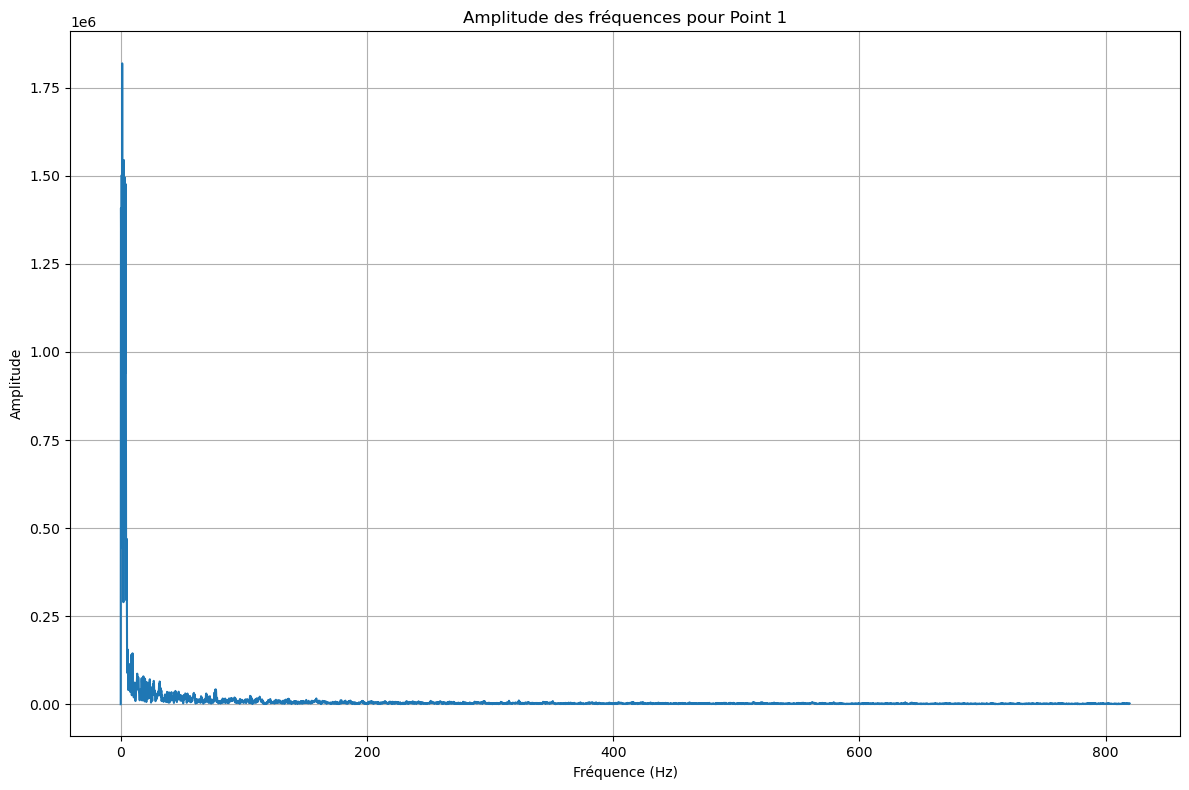

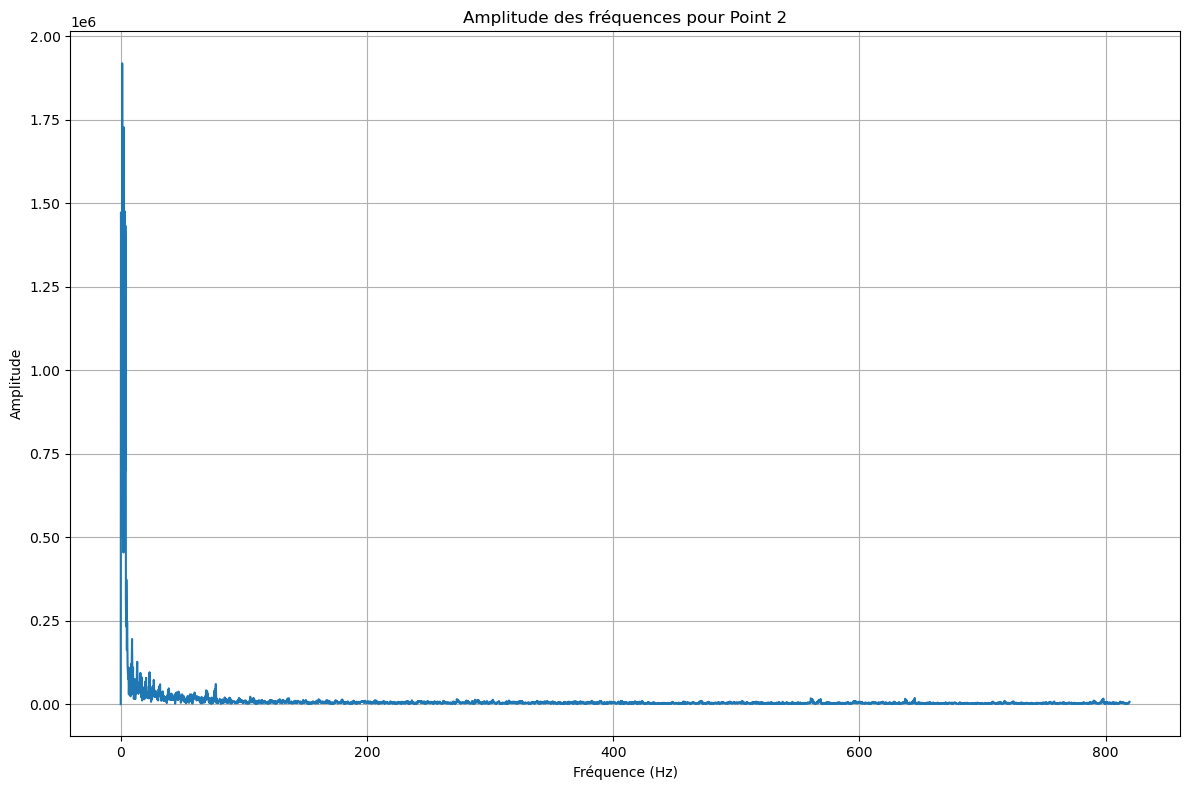

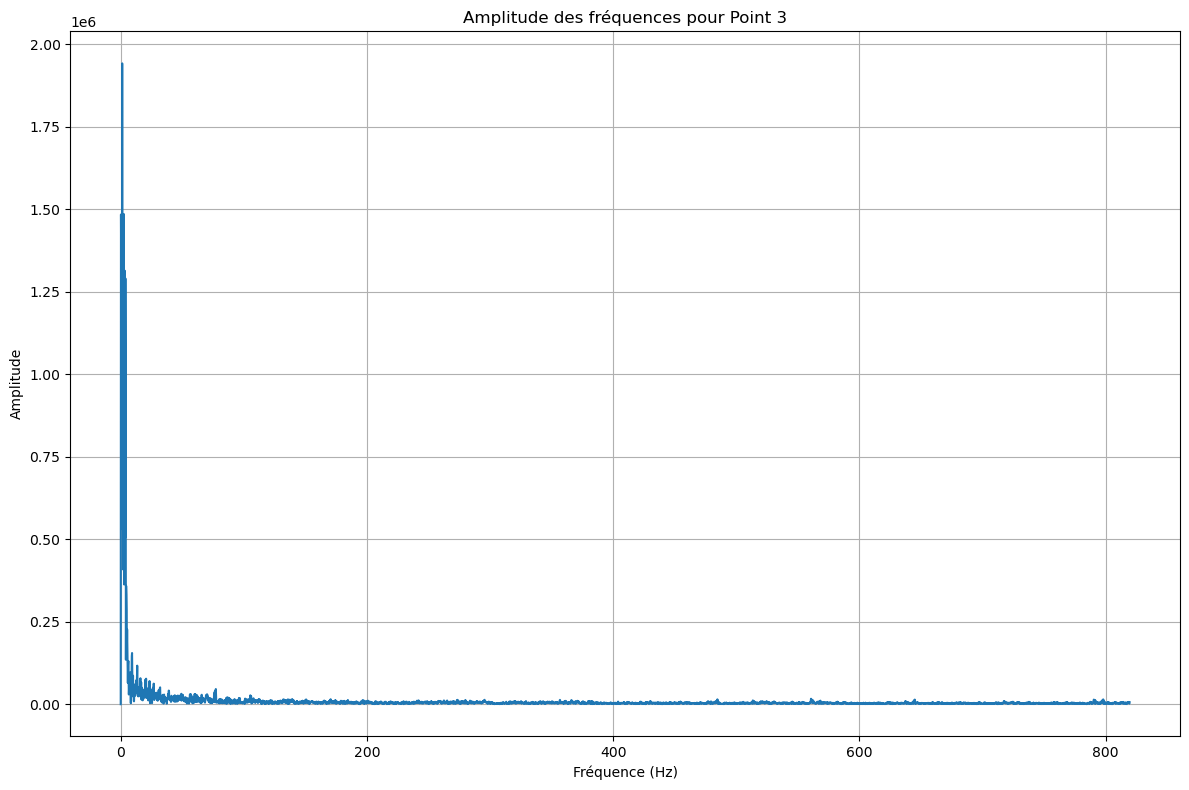

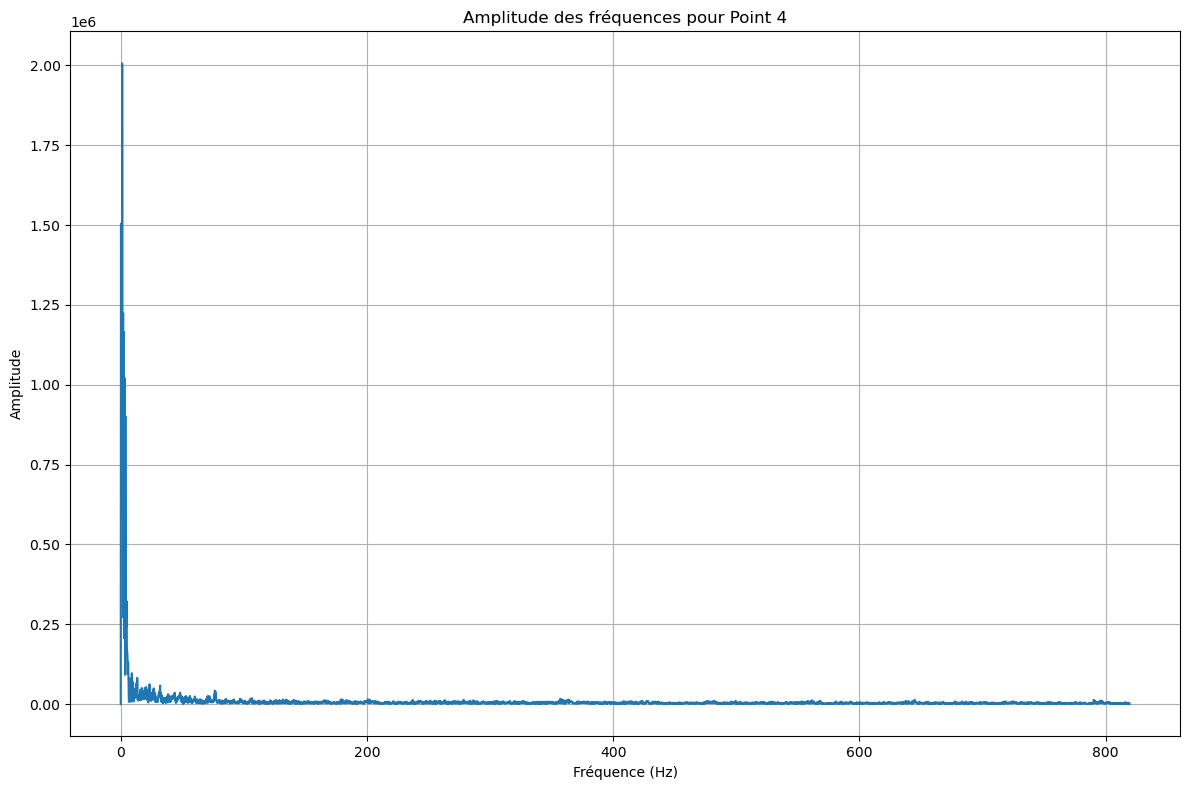

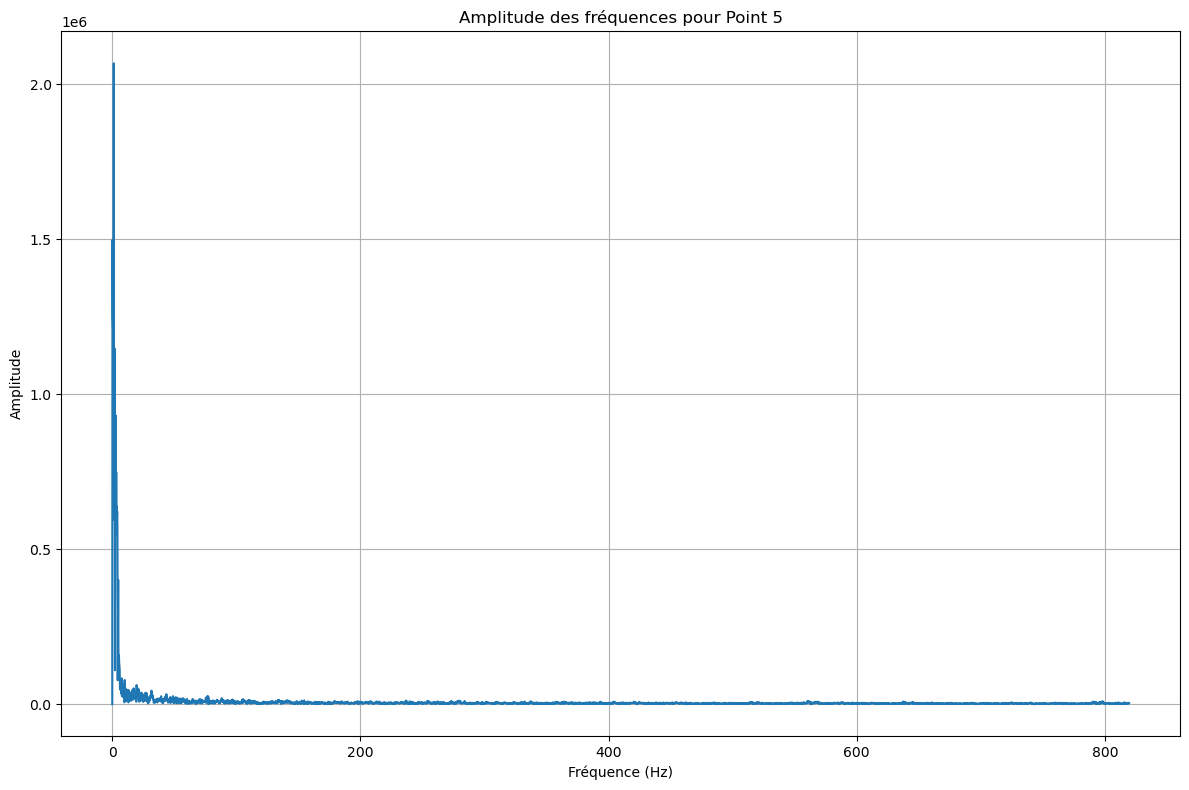

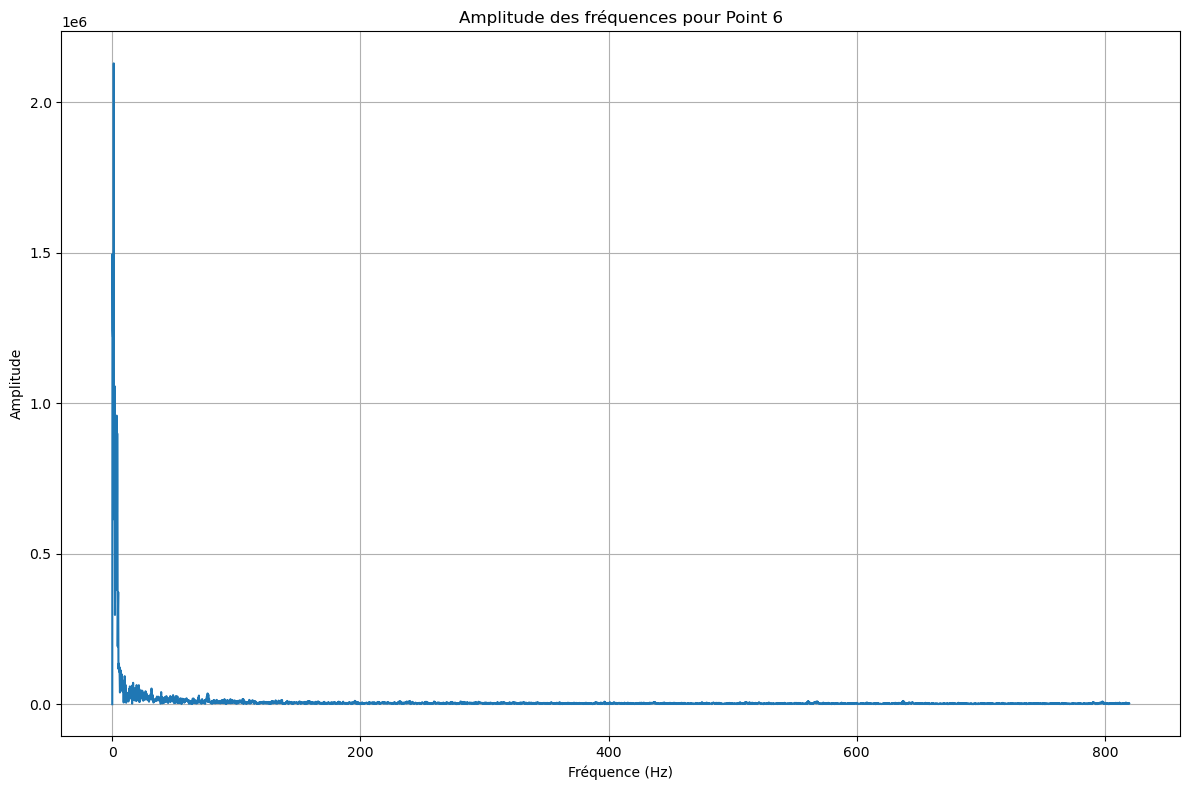

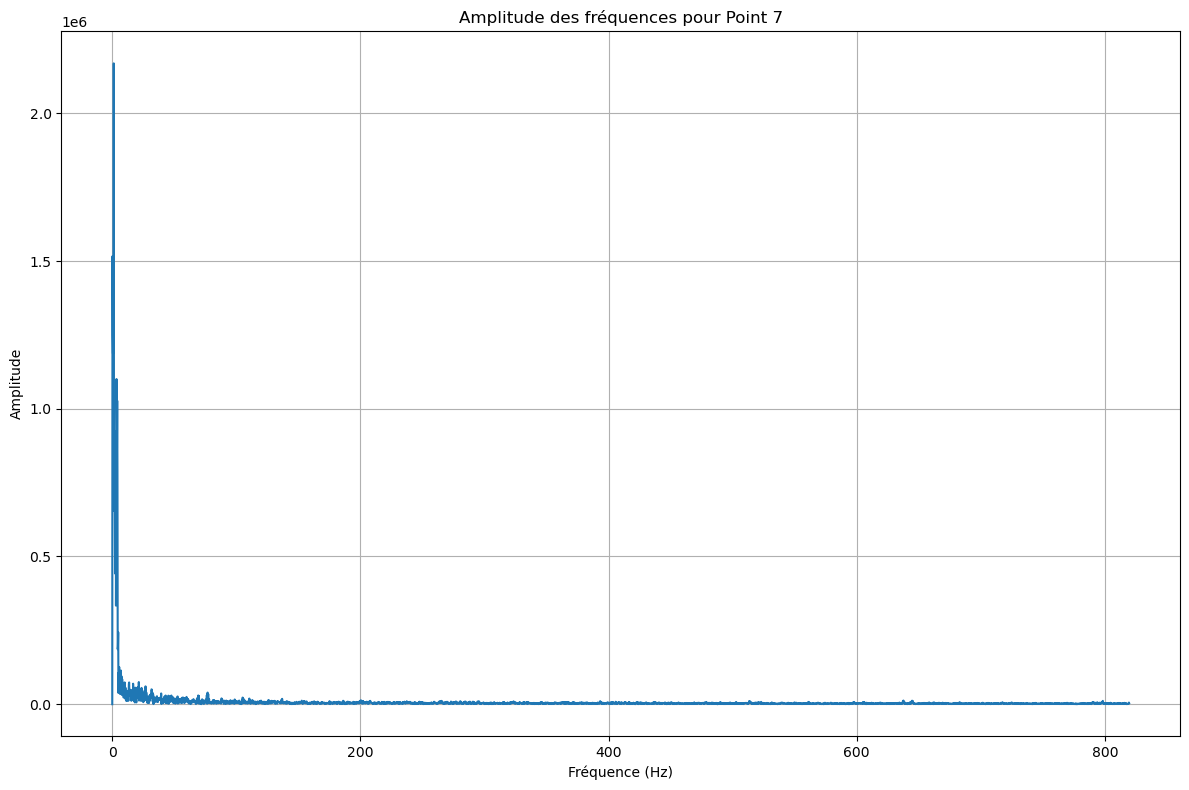

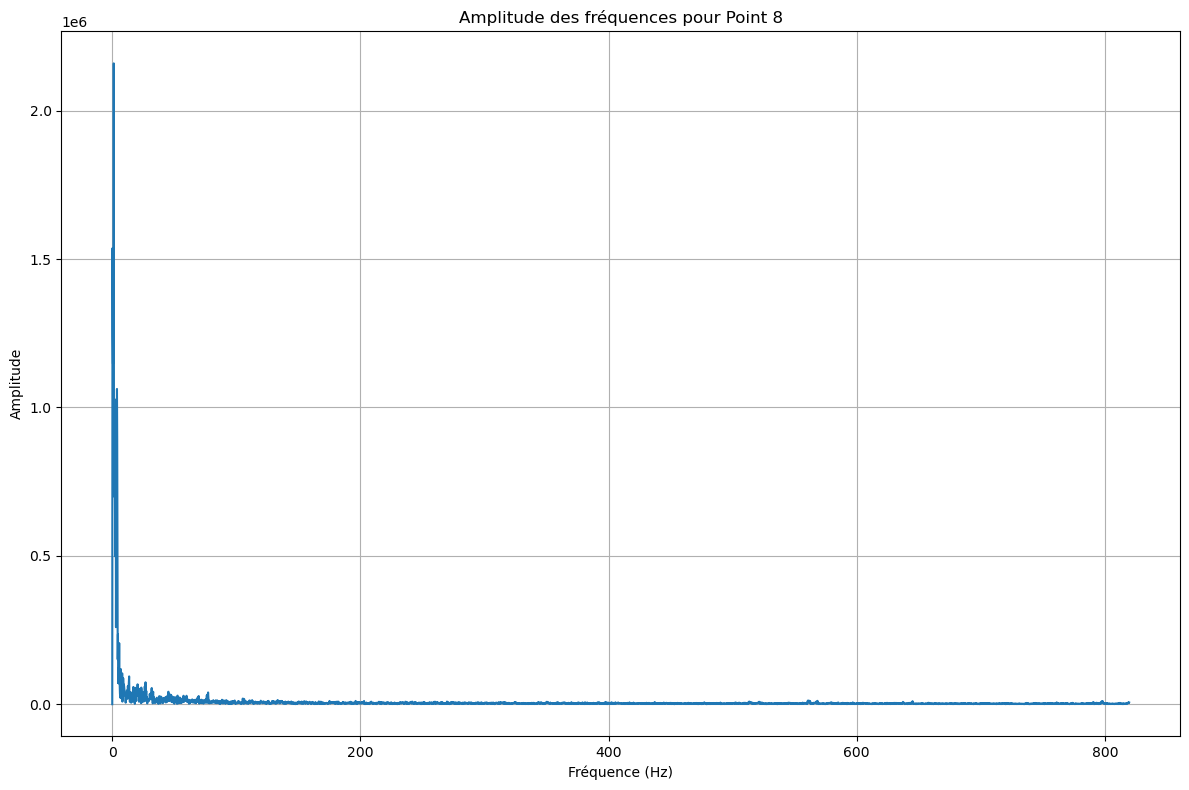

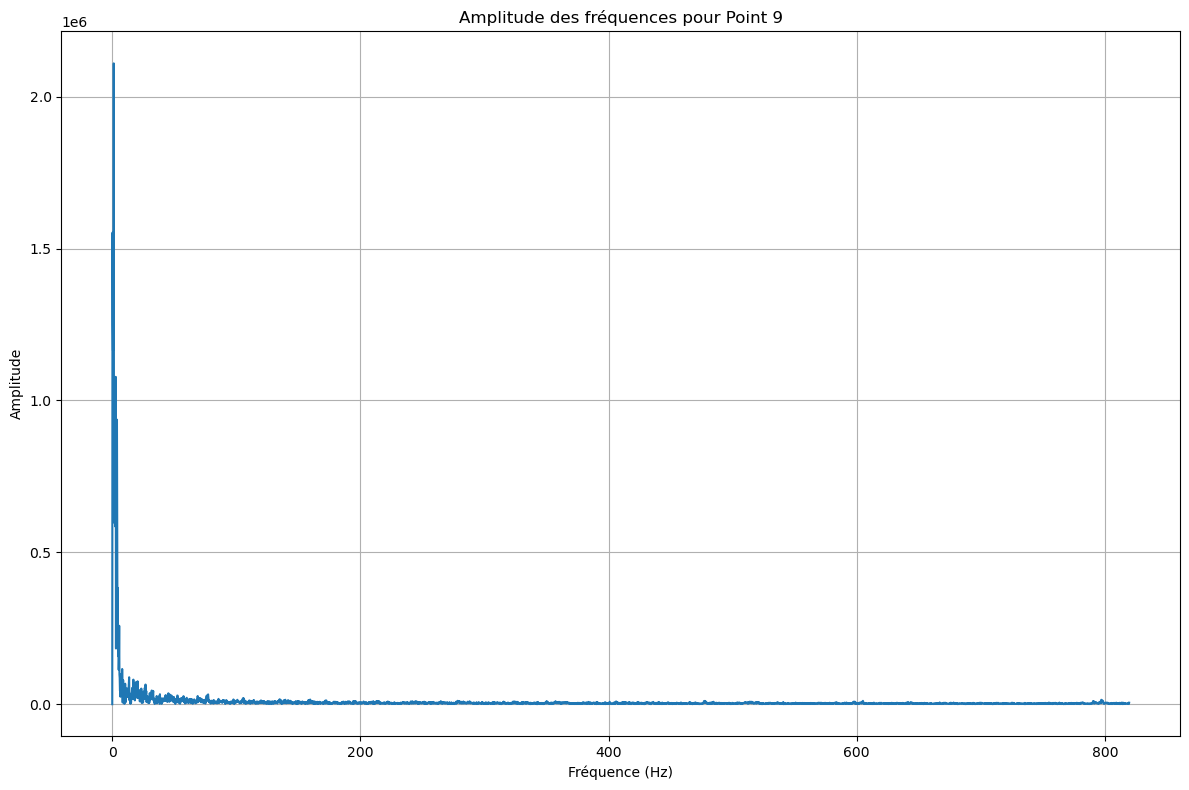

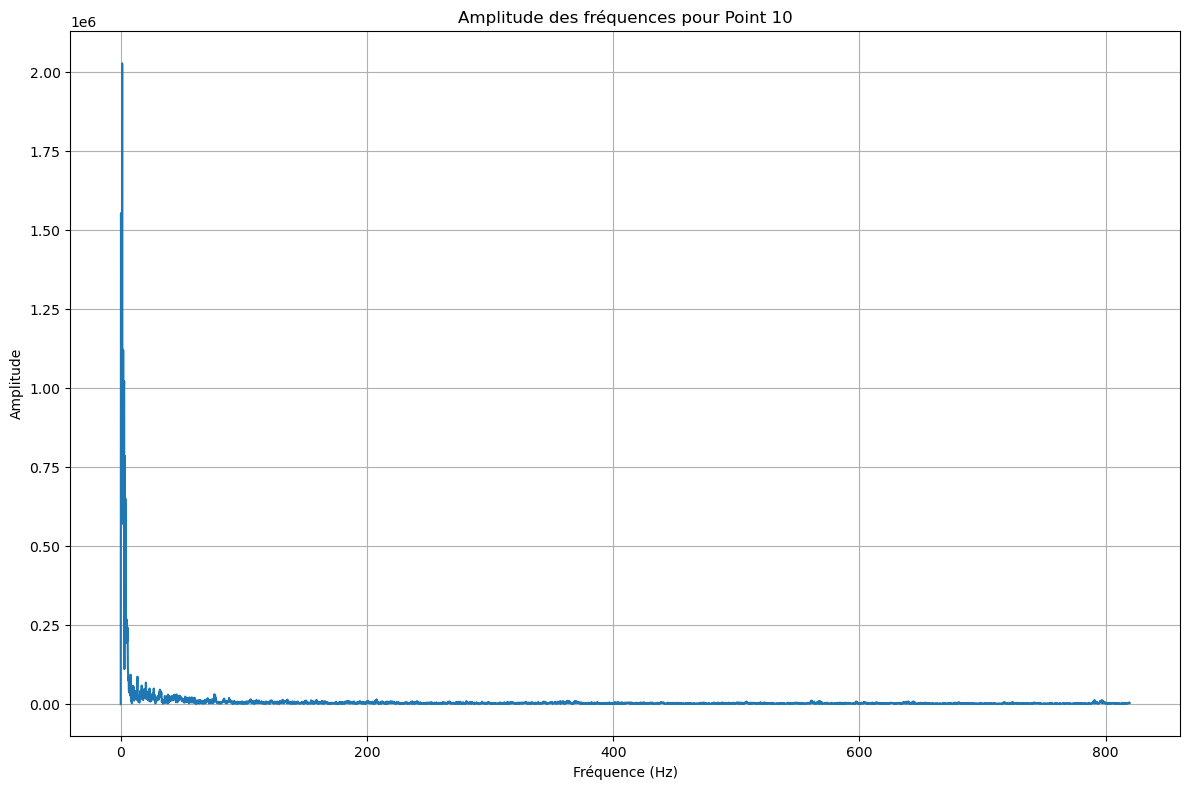

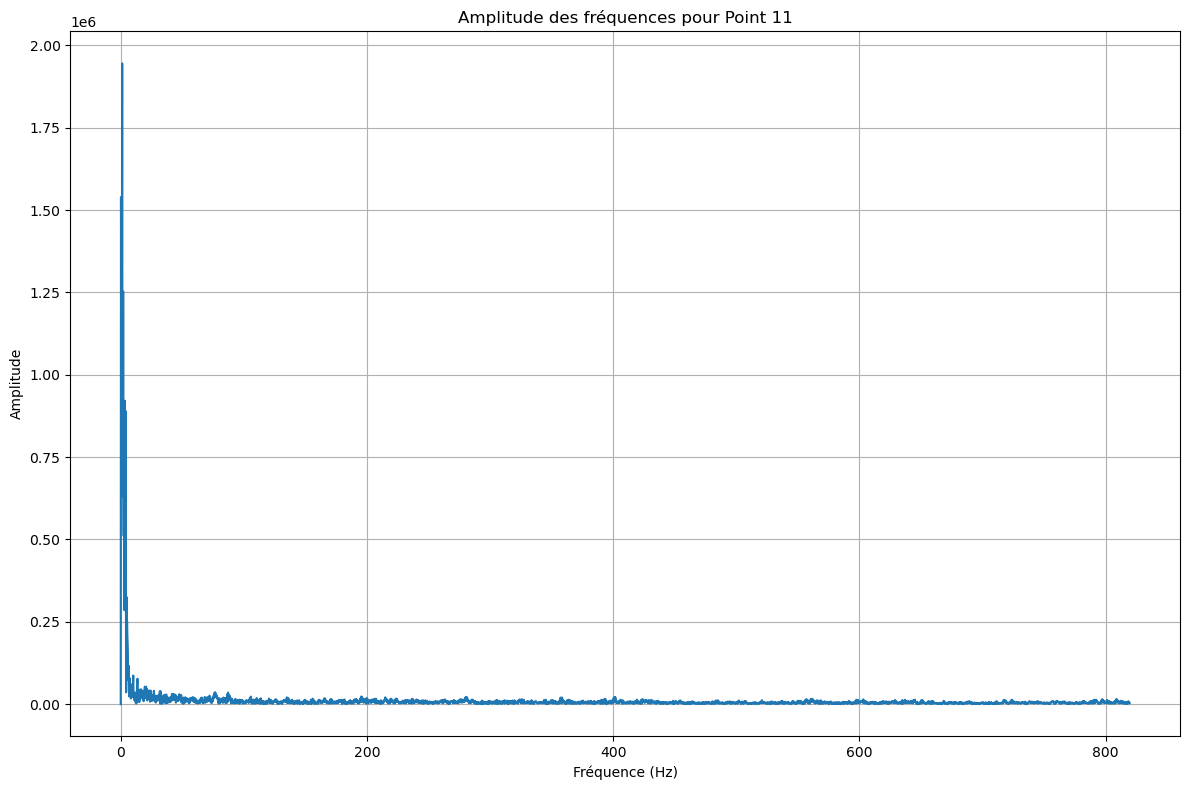

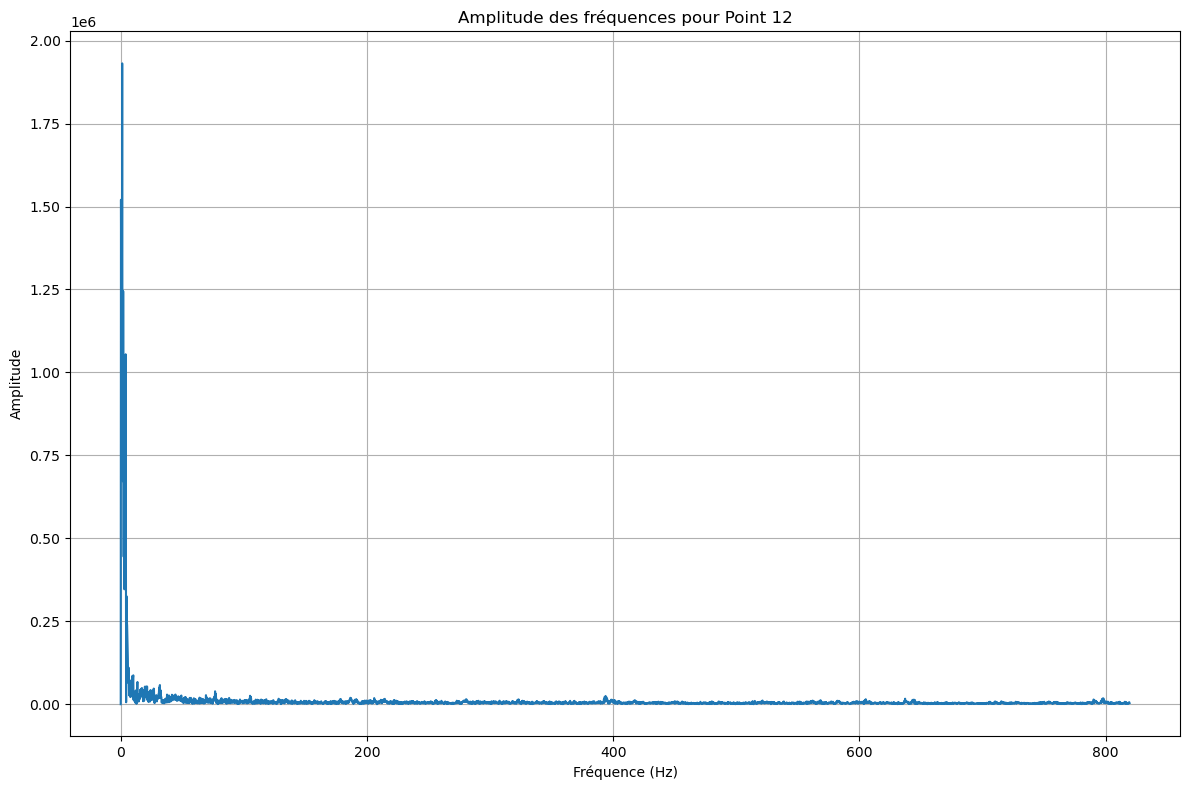

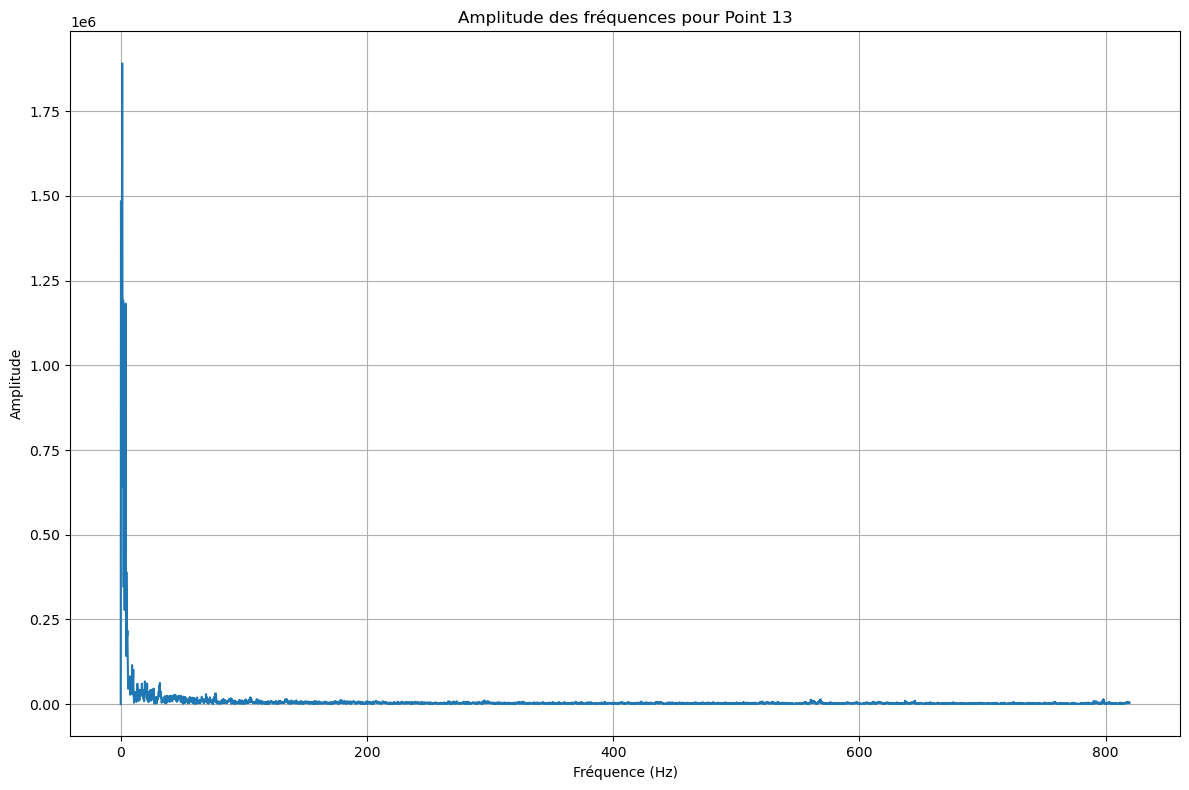

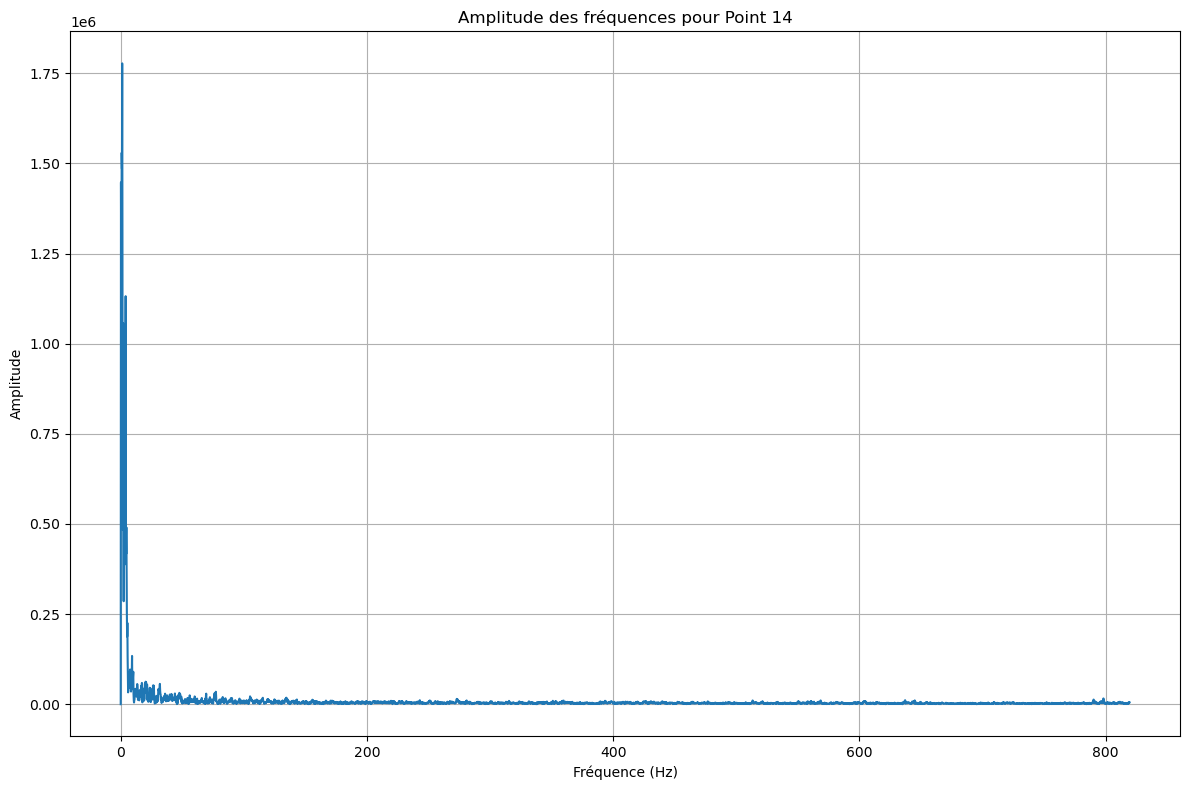

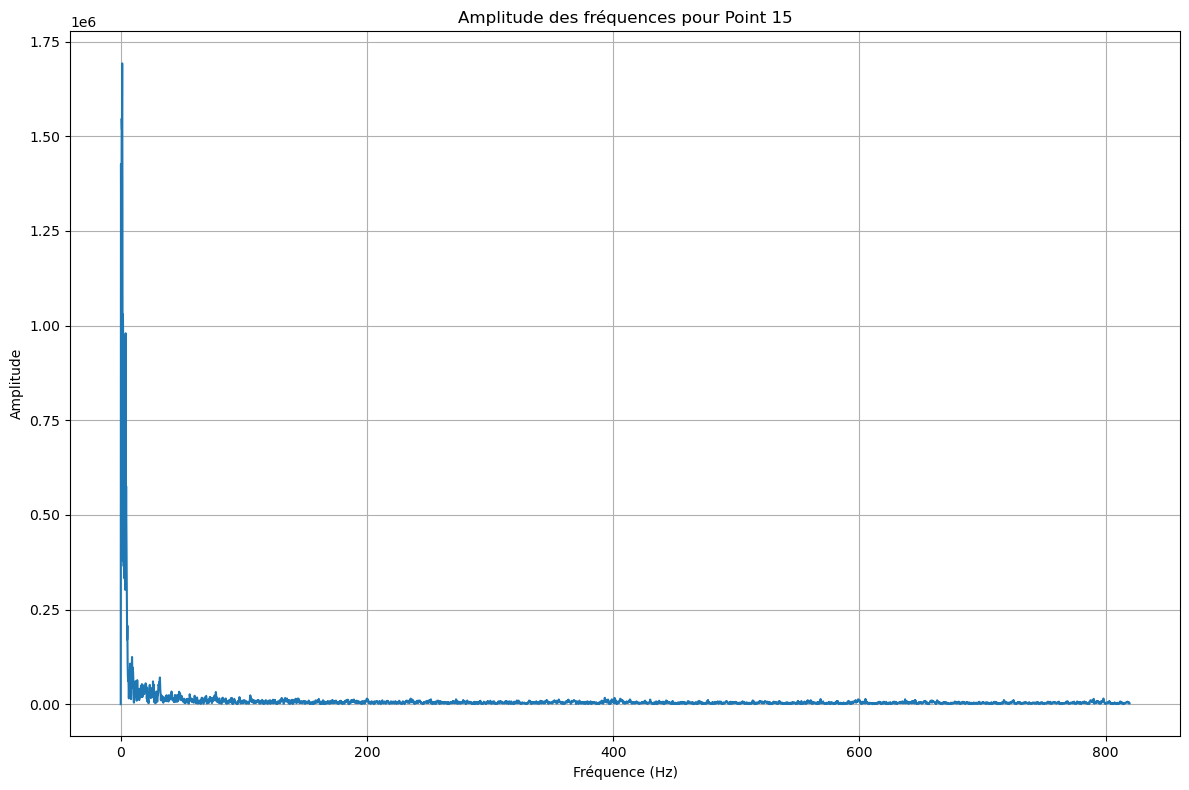

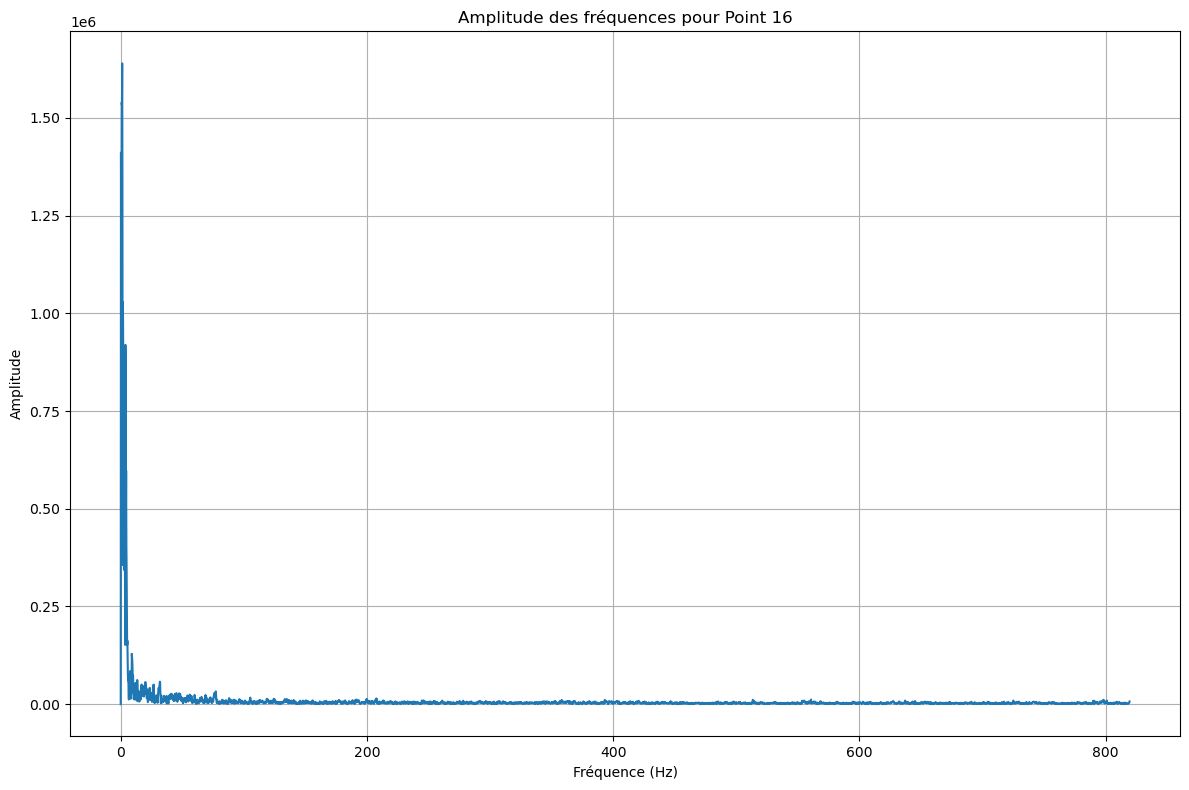

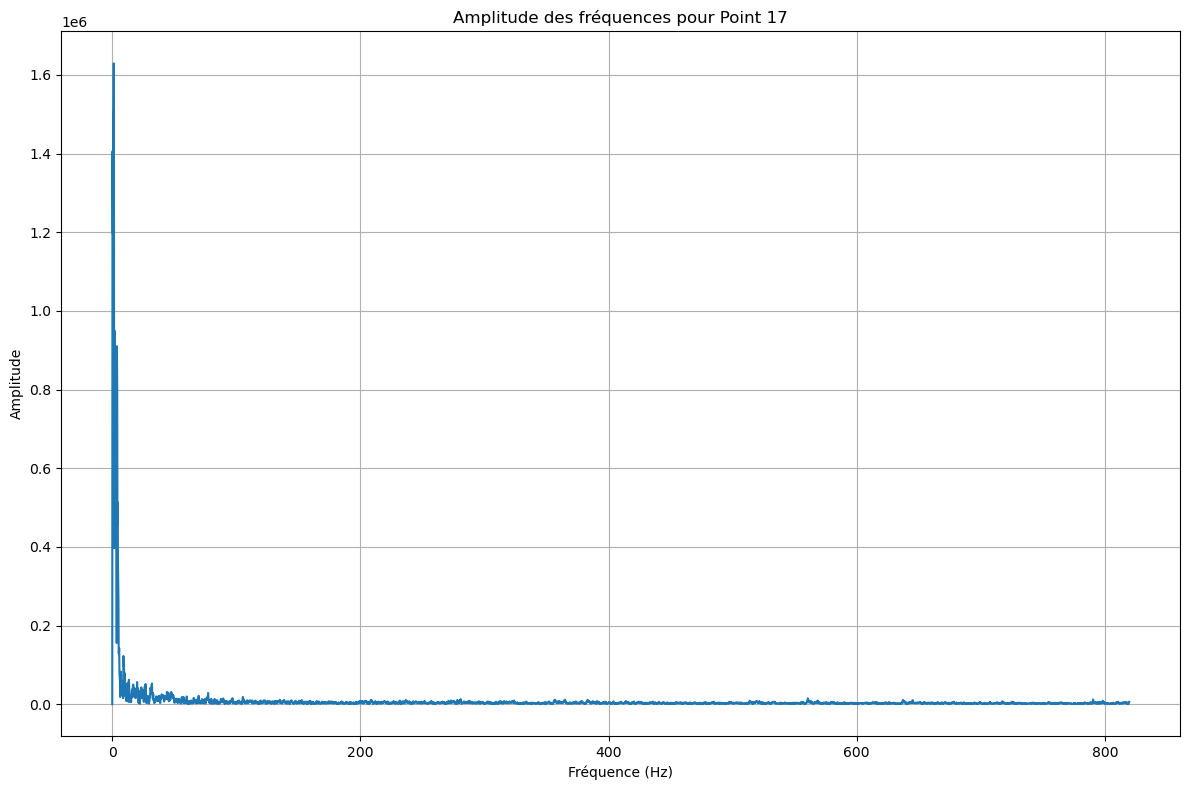

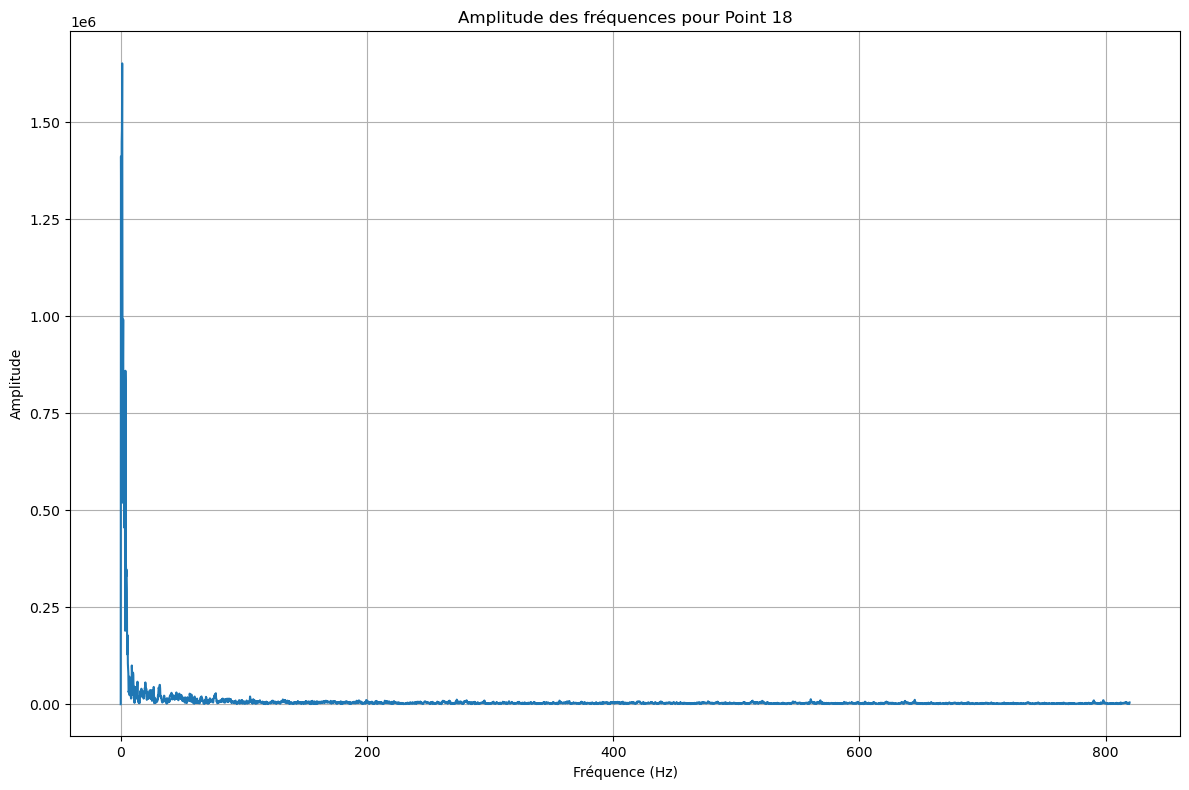

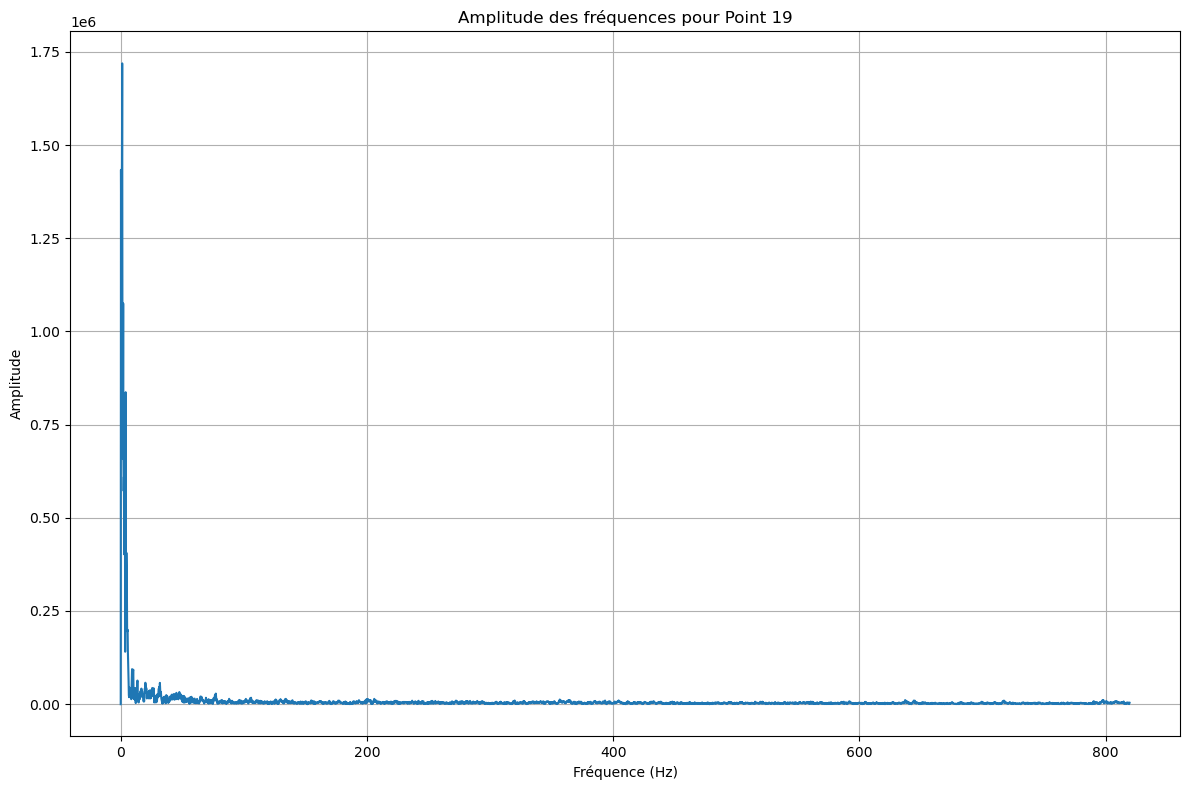

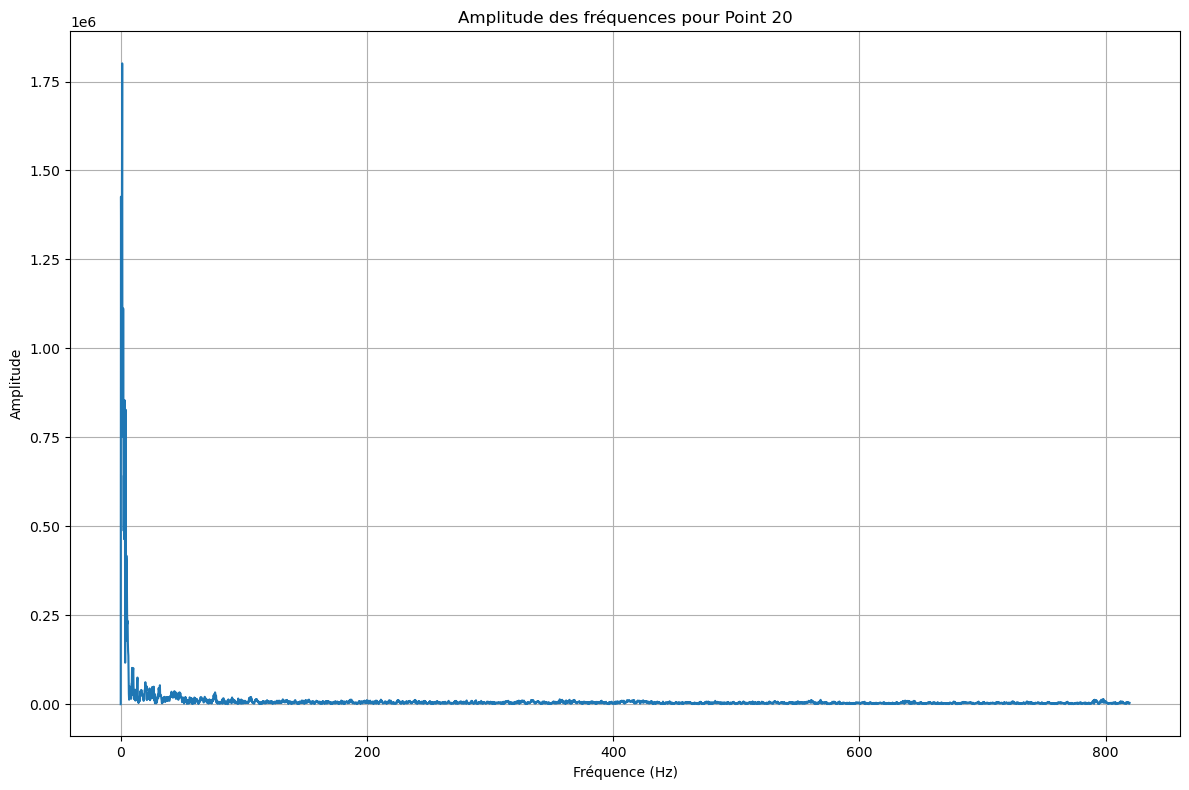

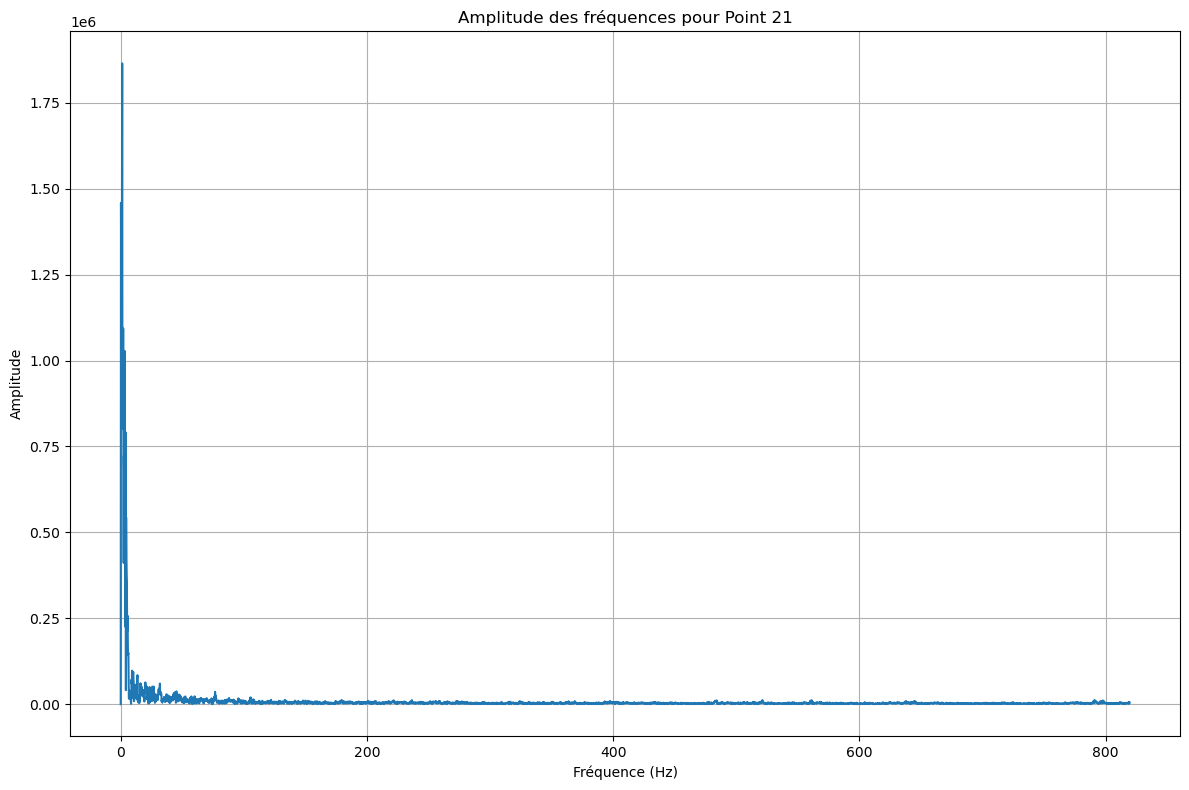

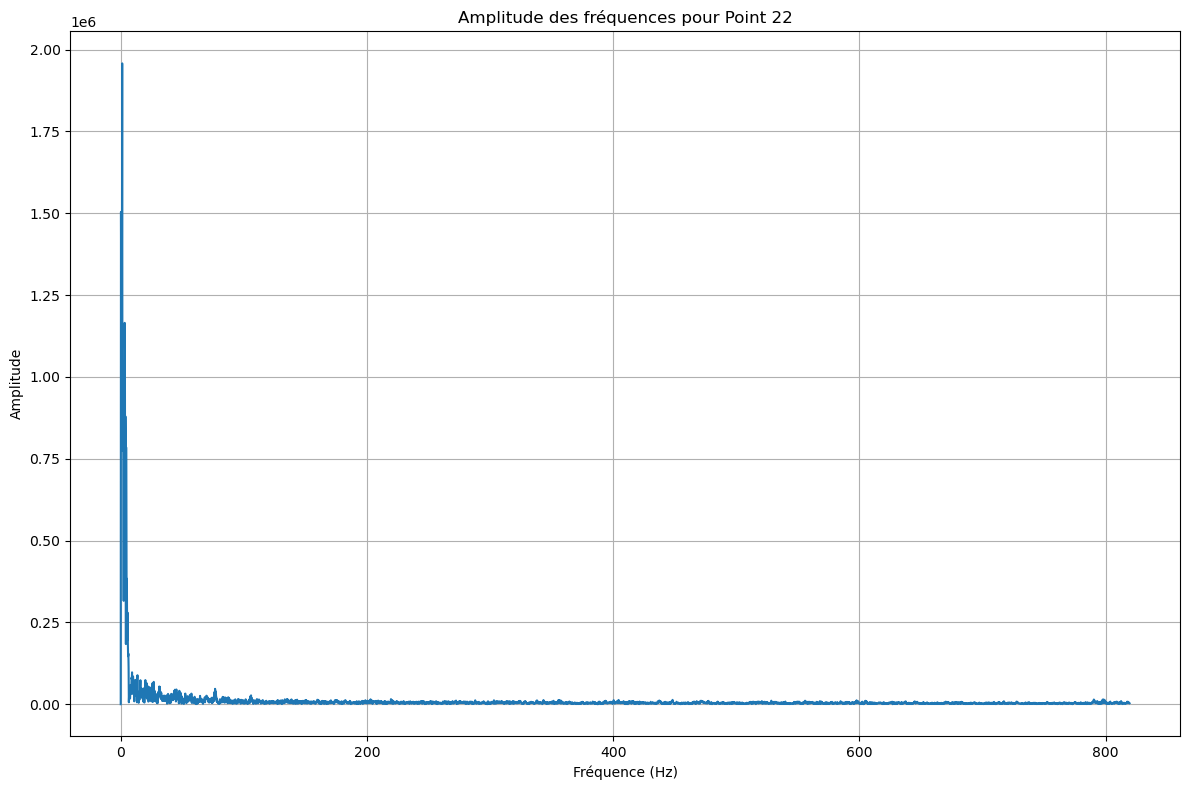

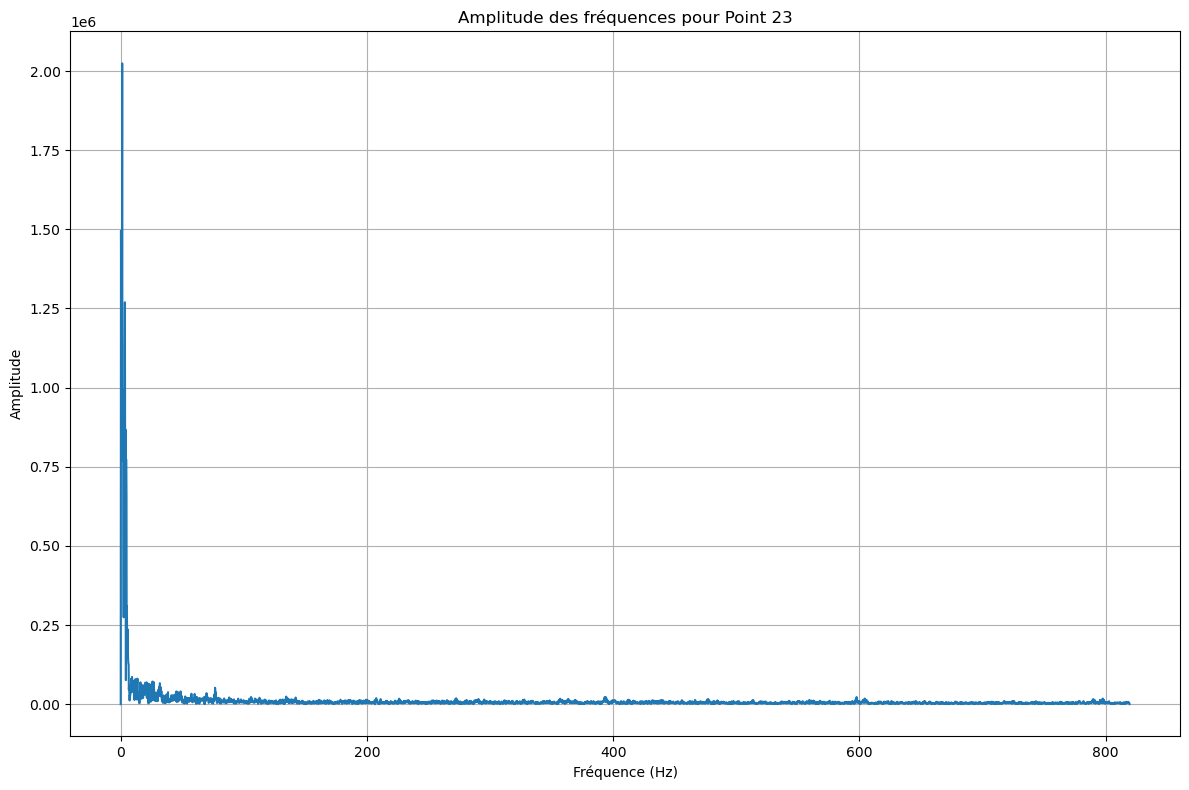

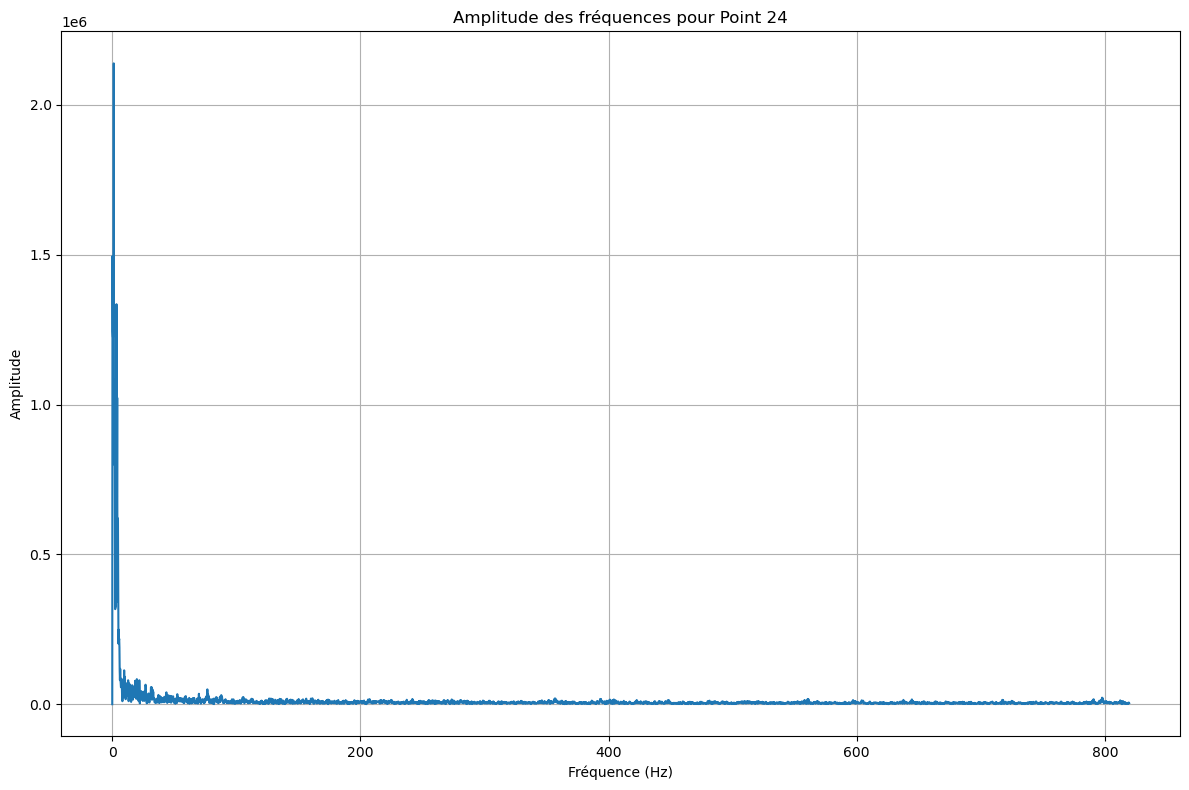

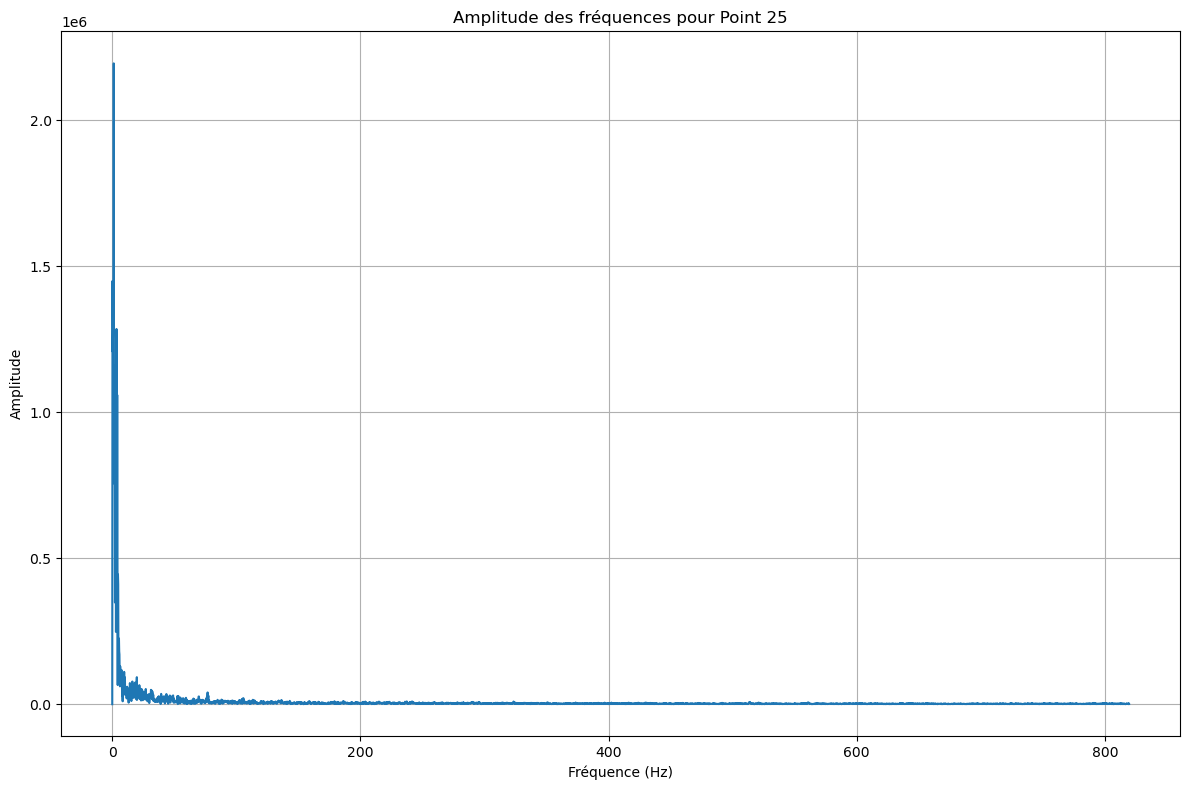

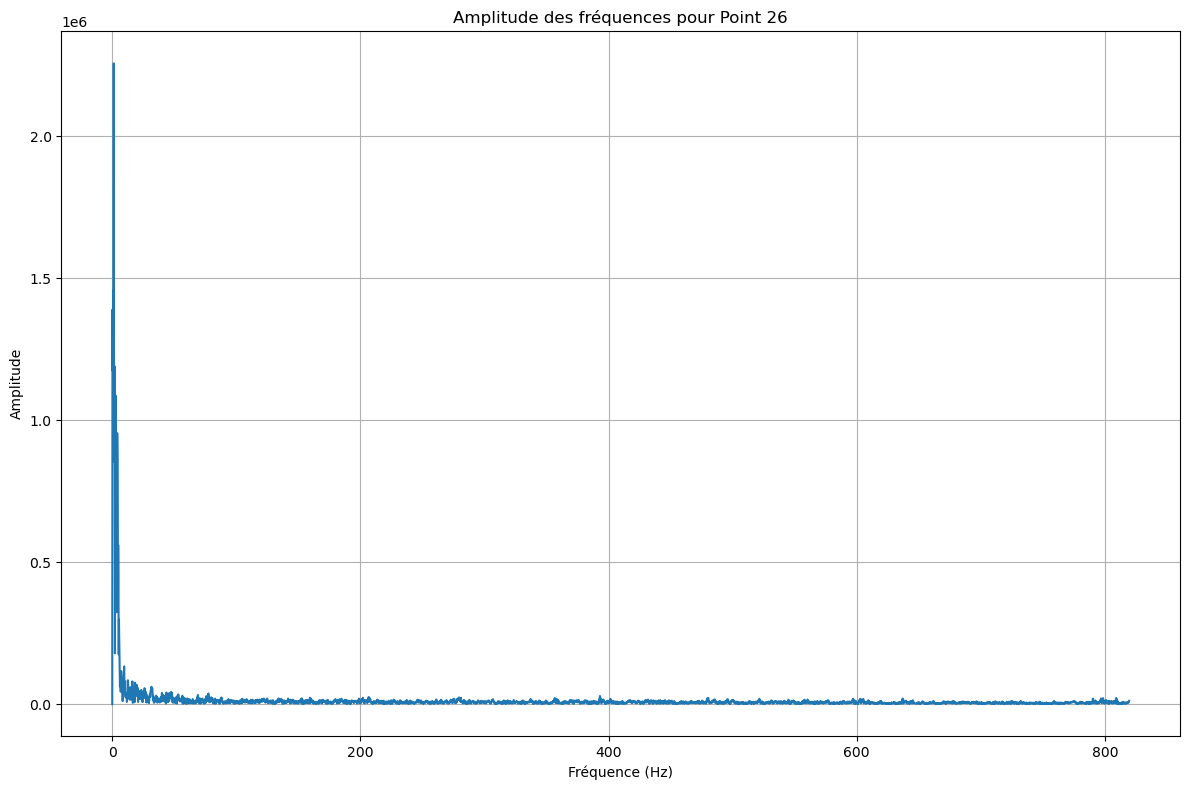

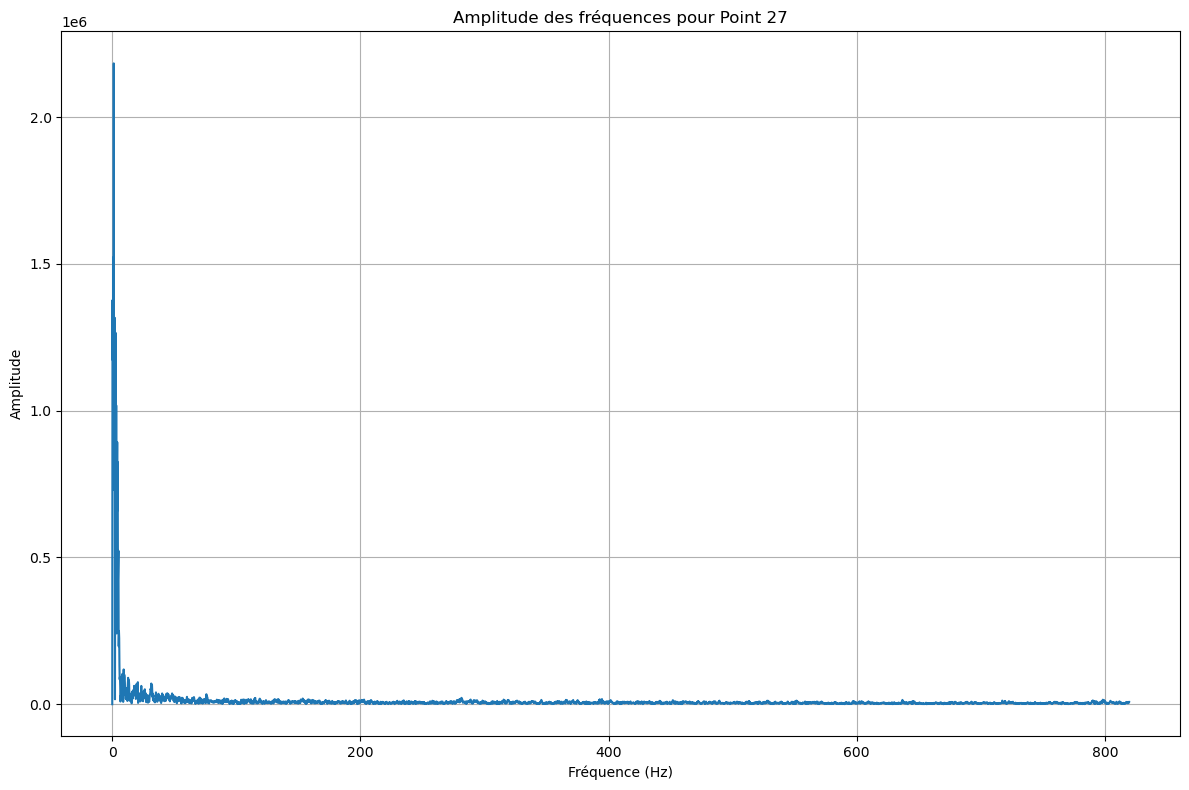

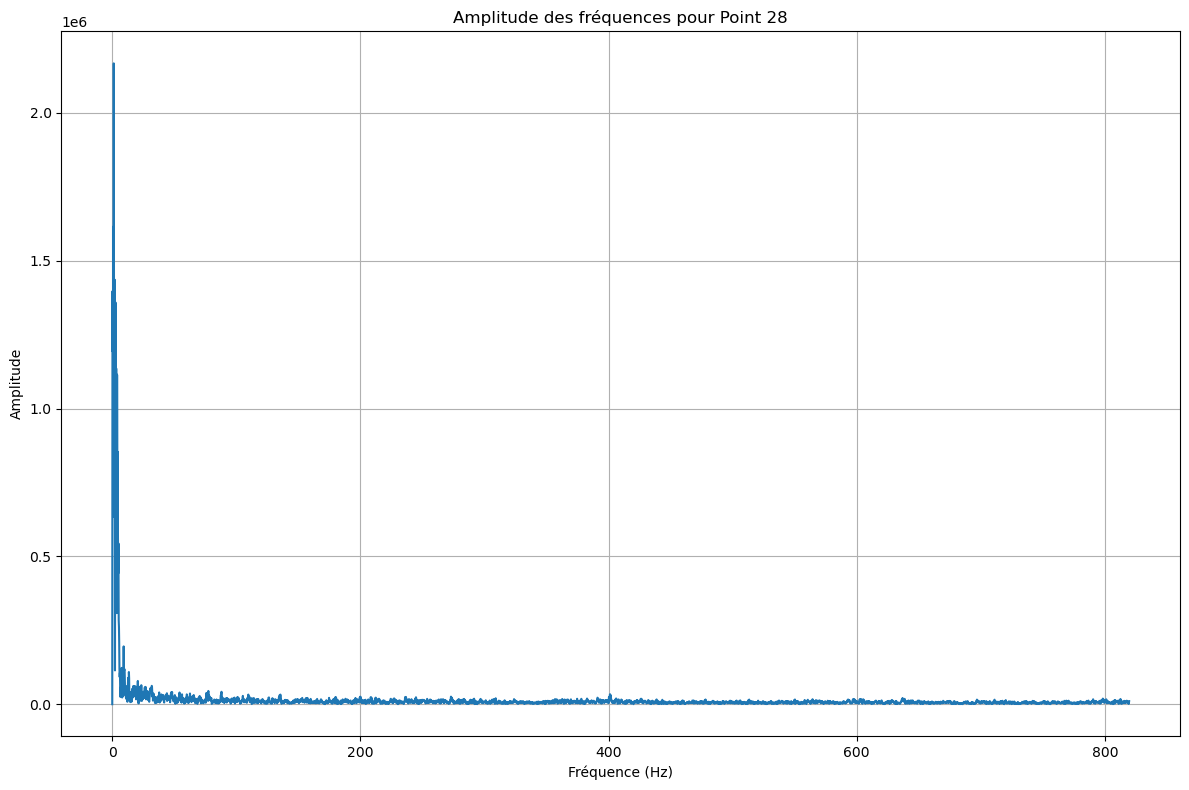

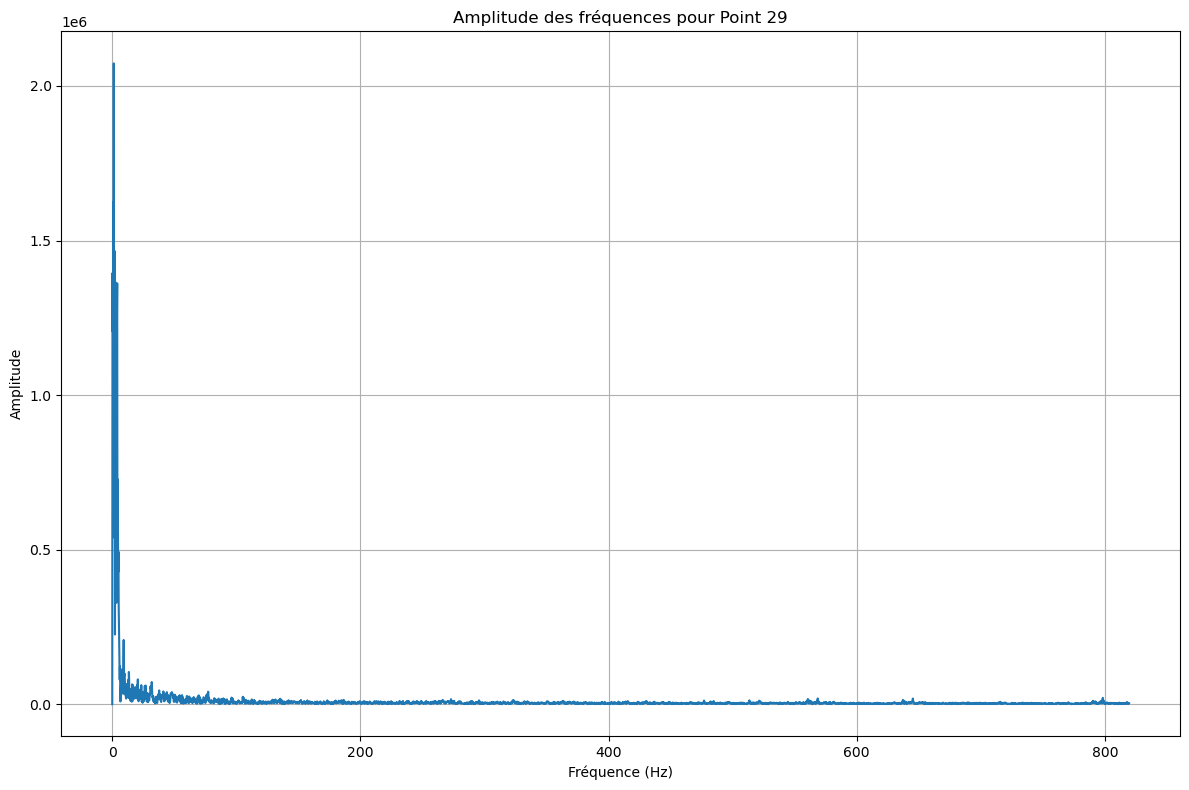

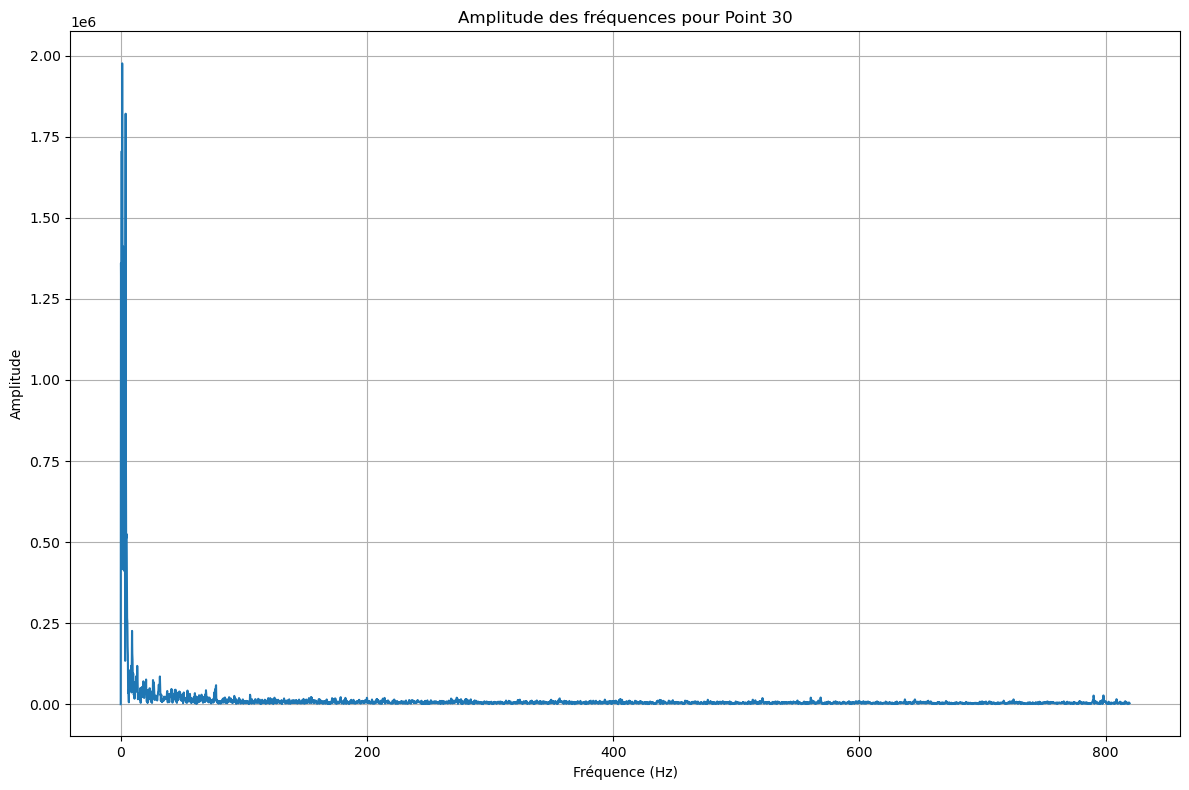

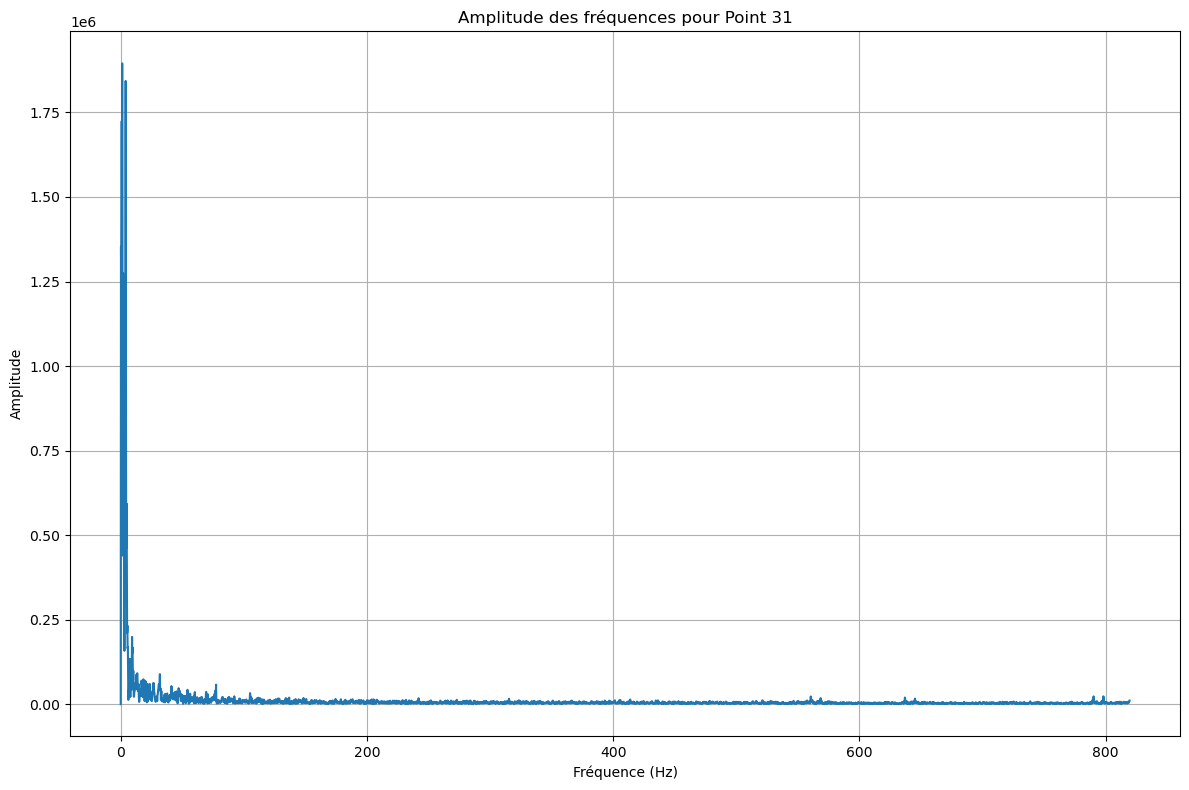

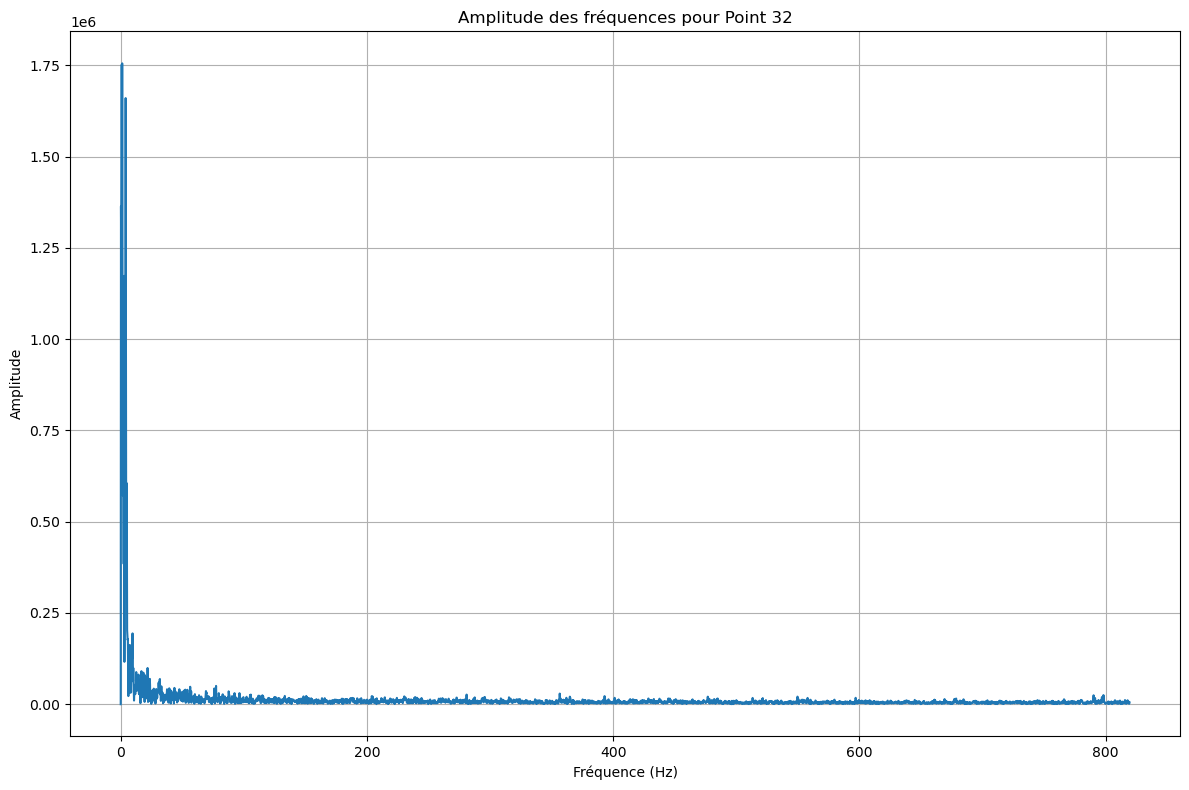

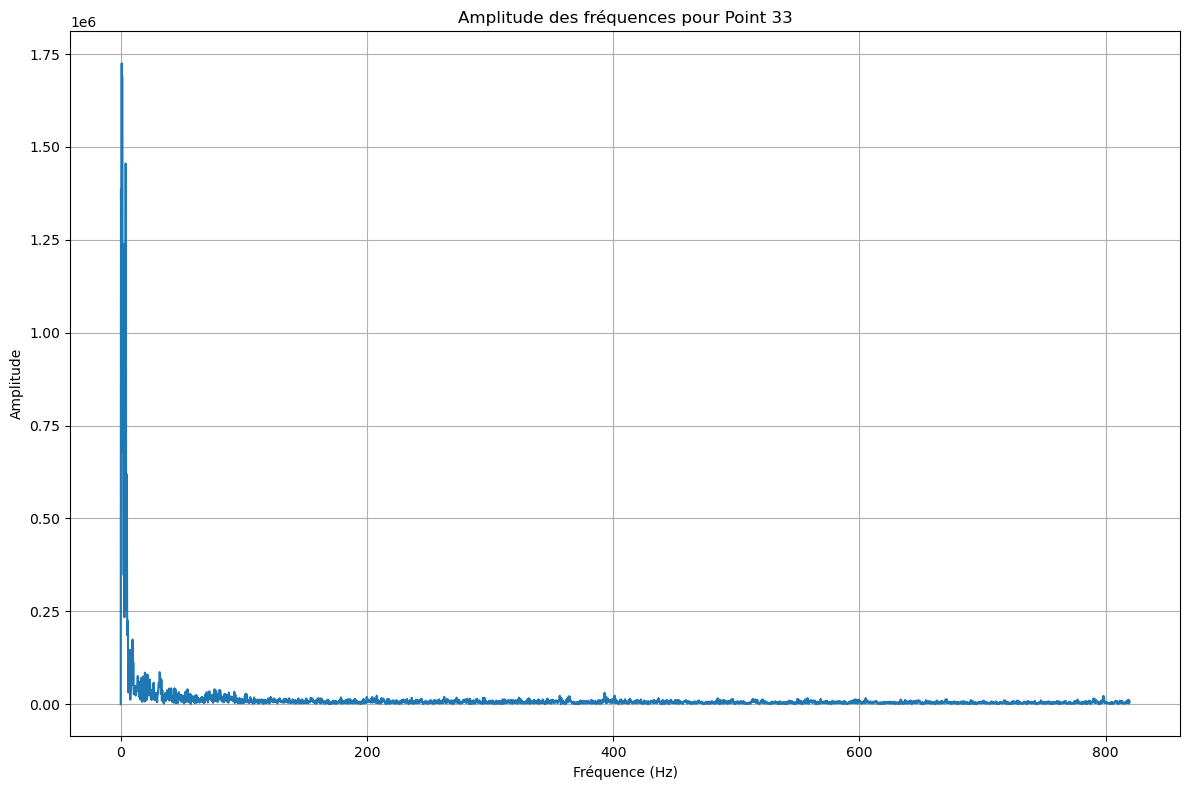

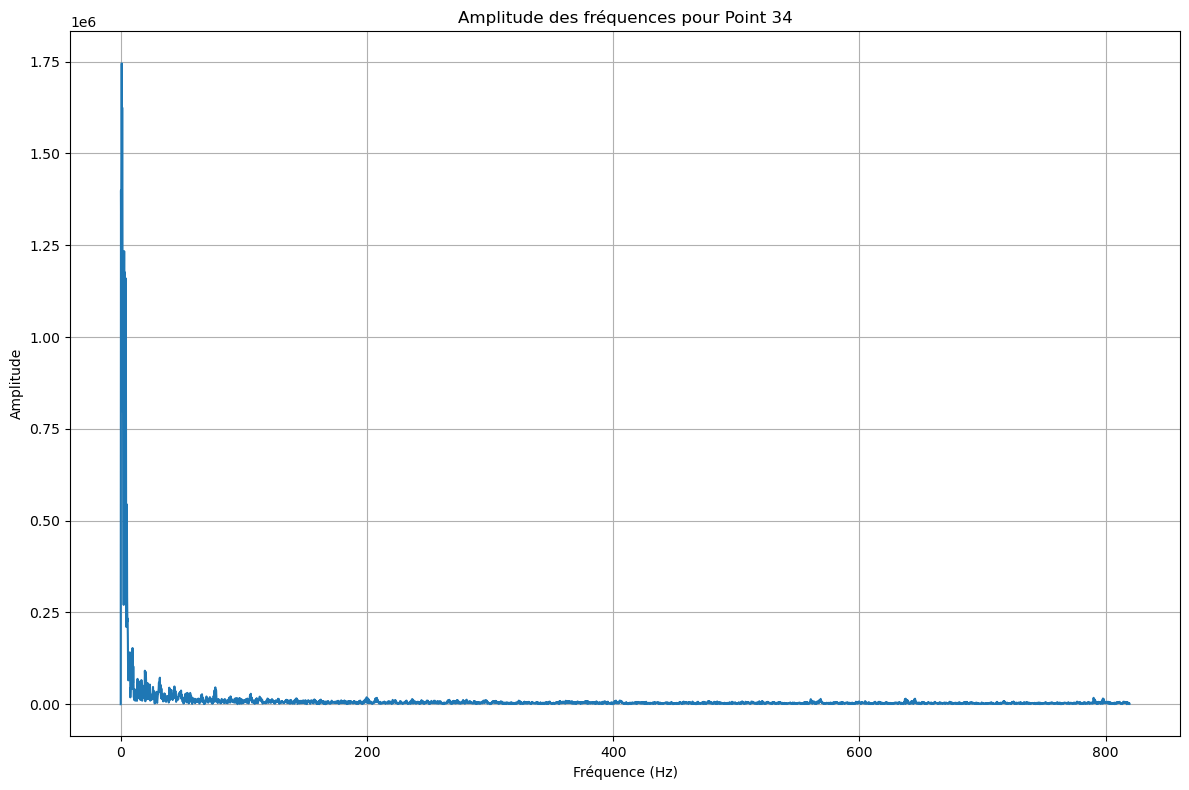

In [240]:
visualiser_matrice_fft_par_point(fft_df2)


In [242]:
top_frequencies_df = detecter_top_frequences(fft_df2)
top_frequencies_df

Point 1_Top_5_Freqs  Point 1_Top_5_Amplitudes  Point 2_Top_5_Freqs  \
0             1.200692              1.819408e+06             1.200692   
1             2.601498              1.544724e+06             2.601498   
2             0.800461              1.502161e+06             3.201844   
3             3.401960              1.495032e+06             0.200115   
4             4.002305              1.476730e+06             2.001153   

   Point 2_Top_5_Amplitudes  Point 3_Top_5_Freqs  Point 3_Top_5_Amplitudes  \
0              1.919336e+06             1.200692              1.941676e+06   
1              1.727438e+06             2.601498              1.484707e+06   
2              1.476395e+06             0.200115              1.483749e+06   
3              1.473035e+06             2.001153              1.397106e+06   
4              1.468367e+06             0.800461              1.379453e+06   

   Point 4_Top_5_Freqs  Point 4_Top_5_Amplitudes  Point 5_Top_5_Freqs  \
0             1.200692              2.006303e+06             1.200692   
1             0.200115              1.504030e+06             0.200115   
2             0.800461              1.330775e+06             0.800461   
3             0.400231              1.287360e+06             0.400231   
4             2.001153              1.224557e+06             0.600346   

   Point 5_Top_5_Amplitudes  ...  Point 30_Top_5_Freqs  \
0              2.067767e+06  ...              1.200692   
1              1.498168e+06  ...              4.002305   
2              1.300037e+06  ...              0.800461   
3              1.250685e+06  ...              2.001153   
4              1.214588e+06  ...              1.400807   

   Point 30_Top_5_Amplitudes  Point 31_Top_5_Freqs  Point 31_Top_5_Amplitudes  \
0               1.976463e+06              1.200692               1.895175e+06   
1               1.821226e+06              4.002305               1.843238e+06   
2               1.705740e+06              0.800461               1.724299e+06   
3               1.411511e+06              1.400807               1.404241e+06   
4               1.404898e+06              0.600346               1.370827e+06   

   Point 32_Top_5_Freqs  Point 32_Top_5_Amplitudes  Point 33_Top_5_Freqs  \
0              1.200692               1.755123e+06              0.800461   
1              0.800461               1.751835e+06              1.200692   
2              4.002305               1.660033e+06              4.002305   
3              0.600346               1.385907e+06              0.200115   
4              0.200115               1.363822e+06              0.600346   

   Point 33_Top_5_Amplitudes  Point 34_Top_5_Freqs  Point 34_Top_5_Amplitudes  
0               1.725109e+06              0.800461               1.745207e+06  
1               1.691962e+06              1.200692               1.624820e+06  
2               1.455481e+06              0.200115               1.399389e+06  
3               1.385875e+06              1.000576               1.395748e+06  
4               1.376568e+06              0.600346               1.388658e+06  

[5 rows x 68 columns]

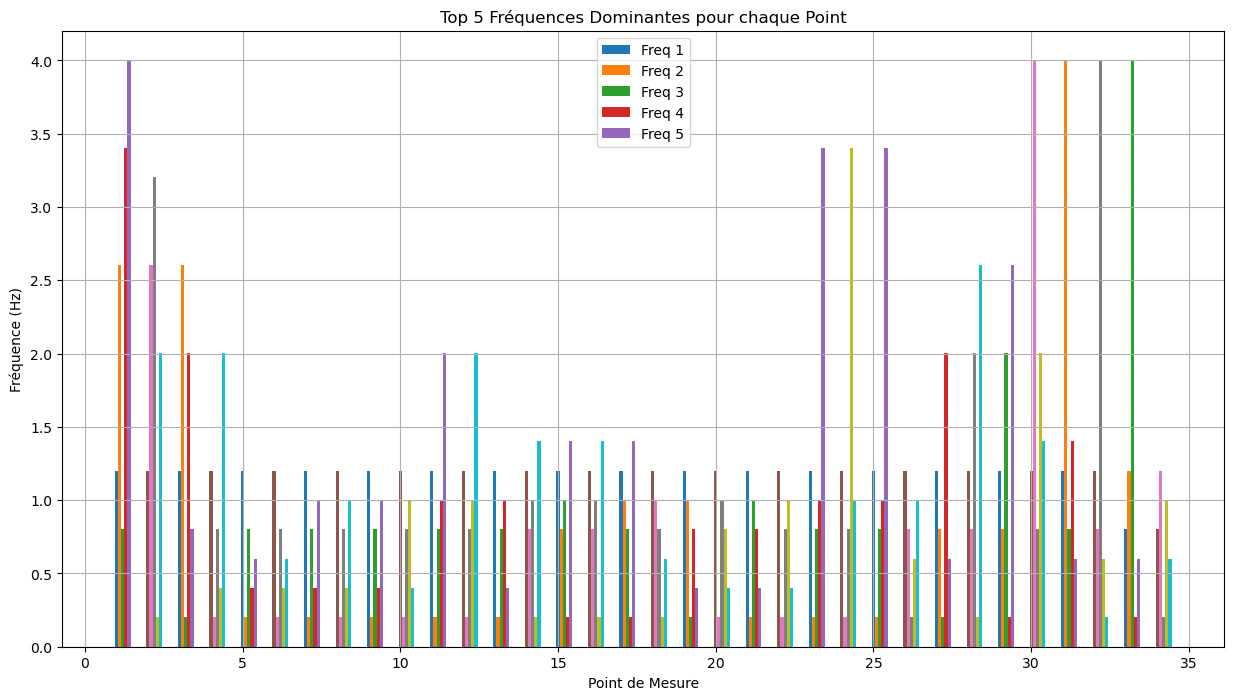

In [244]:
tracer_top_frequences_bars(top_frequencies_df)
